In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

In [4]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]
UNET_EMBEDDING_SIZE = 512

In [6]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")

DIR_CAL_UNET_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings",)
DIR_TEST_UNET_EMB = DIR_CAL_UNET_EMB.replace("cal", "test")



In [7]:
def load_data(pred_probas_dir, res_emb_dir, unet_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    unet_emb = np.zeros((len(os.listdir(unet_emb_dir)), UNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, unet_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(unet_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        unet_emb[i] = np.load(os.path.join(unet_emb_dir, unet_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, unet_emb, labels


In [8]:
load_cal_pred_probas, load_cal_res_emb, load_cal_unet_emb, load_cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_UNET_EMB, DIR_CAL_LABELS
)


0it [00:00, ?it/s]

2it [00:00, 15.06it/s]

35it [00:00, 178.21it/s]

93it [00:00, 349.04it/s]

152it [00:00, 439.38it/s]

210it [00:00, 487.39it/s]

268it [00:00, 516.48it/s]

328it [00:00, 541.56it/s]

388it [00:00, 557.67it/s]

445it [00:00, 559.07it/s]

503it [00:01, 563.17it/s]

561it [00:01, 567.75it/s]

619it [00:01, 571.13it/s]

677it [00:01, 572.82it/s]

736it [00:01, 577.08it/s]

796it [00:01, 582.12it/s]

856it [00:01, 586.44it/s]

917it [00:01, 591.41it/s]

977it [00:01, 586.87it/s]

1036it [00:01, 582.70it/s]

1095it [00:02, 579.79it/s]

1153it [00:02, 577.83it/s]

1211it [00:02, 578.22it/s]

1269it [00:02, 567.74it/s]

1326it [00:02, 560.12it/s]

1383it [00:02, 558.84it/s]

1440it [00:02, 559.39it/s]

1497it [00:02, 561.90it/s]

1500it [00:02, 539.97it/s]

In [9]:
load_test_pred_probas, load_test_res_emb, load_test_unet_emb, load_test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_UNET_EMB, DIR_TEST_LABELS
)

0it [00:00, ?it/s]

57it [00:00, 563.37it/s]

115it [00:00, 567.21it/s]

173it [00:00, 568.81it/s]

231it [00:00, 569.18it/s]

288it [00:00, 567.68it/s]

346it [00:00, 571.72it/s]

404it [00:00, 571.73it/s]

462it [00:00, 570.01it/s]

520it [00:00, 569.43it/s]

578it [00:01, 571.21it/s]

637it [00:01, 573.87it/s]

695it [00:01, 568.14it/s]

752it [00:01, 565.82it/s]

809it [00:01, 564.69it/s]

866it [00:01, 562.78it/s]

923it [00:01, 563.42it/s]

980it [00:01, 563.92it/s]

1037it [00:01, 565.53it/s]

1096it [00:01, 570.51it/s]

1155it [00:02, 574.80it/s]

1214it [00:02, 579.14it/s]

1273it [00:02, 579.76it/s]

1331it [00:02, 579.15it/s]

1390it [00:02, 580.71it/s]

1449it [00:02, 577.14it/s]

1507it [00:02, 574.12it/s]

1565it [00:02, 569.99it/s]

1623it [00:02, 568.22it/s]

1680it [00:02, 568.29it/s]

1738it [00:03, 569.33it/s]

1795it [00:03, 568.46it/s]

1852it [00:03, 564.26it/s]

1909it [00:03, 562.57it/s]

1966it [00:03, 560.48it/s]

2023it [00:03, 558.30it/s]

2079it [00:03, 556.64it/s]

2137it [00:03, 561.97it/s]

2195it [00:03, 567.00it/s]

2254it [00:03, 572.92it/s]

2300it [00:04, 569.35it/s]

In [10]:
all_pred_probas = np.concatenate([load_cal_pred_probas, load_test_pred_probas])
all_res_emb = np.concatenate([load_cal_res_emb, load_test_res_emb])
all_labels = np.concatenate([load_cal_labels, load_test_labels])
all_unet_emb = np.concatenate([load_cal_unet_emb, load_test_unet_emb])

In [11]:
ALPHA = .1
REGULARIZATION = "ridge"

In [12]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [13]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Cross validation

In [14]:
recalls_crc = []
recalls_unet = []
recalls_resnet = []

precisions_crc = []
precisions_unet = []
precisions_resnet = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_unet_emb = all_unet_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_unet_emb = temp_cal_unet_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_unet_emb = all_unet_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    # CRC
    mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
    for i in tqdm(range(len(temp_cal_pred_probas))):
        X, y = temp_cal_pred_probas[i], temp_cal_labels[i]
        mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])
    _, _ = mapie_crc.predict(temp_test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
    th_crc = mapie_crc.lambdas_star

    # ResNet
    lambda_resnet, dist_resnet = grid_search_lambda(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, RESNET_EMBEDDING_SIZE)
    print(lambda_resnet, dist_resnet)
    result_res = minimize(
        J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, len(temp_cal_labels), REGULARIZATION, lambda_resnet), jac=J_prime,
        options={"disp": True, "maxiter": 1000}, tol=1e-10
    )
    ths_res = (temp_test_res_emb @ result_res.x).reshape(-1, 1, 1)

    # UNet
    lambda_unet, dist_unet = grid_search_lambda(temp_cal_labels, temp_cal_pred_probas, temp_cal_unet_emb, UNET_EMBEDDING_SIZE)
    print(lambda_unet, dist_unet)
    result_unet = minimize(
        J, np.random.uniform(0, 1, UNET_EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_unet_emb, ALPHA, len(temp_cal_labels), REGULARIZATION, lambda_unet), jac=J_prime,
        options={"disp": True, "maxiter": 1000}, tol=1e-10
    )
    ths_unet = (temp_test_unet_emb @ result_unet.x).reshape(-1, 1, 1)

    y_pred_test_th_crc = (temp_test_pred_probas >= th_crc).astype(int)
    y_pred_test_th_res = (temp_test_pred_probas >= ths_res).astype(int)
    y_pred_test_th_unet = (temp_test_pred_probas >= ths_unet).astype(int)

    recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
    recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
    recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))

    precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
    precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
    precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
    
    

  0%|                                                                                                                      | 0/100 [00:00<?, ?it/s]

  0%|                                                                                                                     | 0/1557 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 125/1557 [00:00<00:01, 1244.89it/s]

 16%|████████████████▊                                                                                        | 250/1557 [00:00<00:01, 1229.66it/s]

 24%|█████████████████████████▍                                                                               | 378/1557 [00:00<00:00, 1250.31it/s]

 32%|██████████████████████████████████                                                                       | 505/1557 [00:00<00:00, 1257.29it/s]

 41%|██████████████████████████████████████████▌                                                              | 631/1557 [00:00<00:00, 1248.77it/s]

 49%|██████████████████████████████████████████████████▉                                                      | 756/1557 [00:00<00:00, 1206.39it/s]

 56%|███████████████████████████████████████████████████████████▏                                             | 877/1557 [00:00<00:00, 1167.97it/s]

 64%|███████████████████████████████████████████████████████████████████                                      | 995/1557 [00:00<00:00, 1148.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                             | 1111/1557 [00:00<00:00, 1132.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 1225/1557 [00:01<00:00, 1111.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▎              | 1337/1557 [00:01<00:00, 1094.04it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1447/1557 [00:01<00:00, 1095.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:01<00:00, 1152.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:29<02:59, 29.96s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:53<02:11, 26.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:05<01:19, 19.85s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:53, 17.72s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:29, 14.57s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:38<00:12, 12.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 11.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 15.57s/it]

0.001 0.003296356599253314


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945181462171467
            Iterations: 58
            Function evaluations: 88
            Gradient evaluations: 58


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:08<06:48, 68.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:45, 57.11s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:26<02:56, 44.19s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:45<01:42, 34.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:57<00:52, 26.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:12<00:22, 22.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 20.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 29.70s/it]

0.01 0.0020197297430790684


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946587656637723
            Iterations: 64
            Function evaluations: 119
            Gradient evaluations: 64


  0%|                                                                                                                     | 0/1579 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 129/1579 [00:00<00:01, 1280.66it/s]

 16%|█████████████████▏                                                                                       | 258/1579 [00:00<00:01, 1070.89it/s]

 24%|█████████████████████████▌                                                                               | 385/1579 [00:00<00:01, 1150.81it/s]

 32%|█████████████████████████████████▉                                                                       | 511/1579 [00:00<00:00, 1190.56it/s]

 40%|██████████████████████████████████████████                                                               | 632/1579 [00:00<00:00, 1092.38it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 754/1579 [00:00<00:00, 1129.61it/s]

 55%|██████████████████████████████████████████████████████████                                               | 873/1579 [00:00<00:00, 1147.49it/s]

 63%|█████████████████████████████████████████████████████████████████▊                                       | 989/1579 [00:00<00:00, 1147.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████▍                               | 1105/1579 [00:01<00:00, 789.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 1199/1579 [00:01<00:00, 814.36it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 1306/1579 [00:01<00:00, 876.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 1412/1579 [00:01<00:00, 922.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1515/1579 [00:01<00:00, 951.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:01<00:00, 899.70it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:46<04:38, 46.39s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:10<02:45, 33.12s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:27<01:43, 25.99s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:39<01:01, 20.45s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:48<00:32, 16.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:01<00:15, 15.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:08<00:00, 12.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:08<00:00, 18.37s/it]

0.01 0.009700357287586225


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94377797281171
            Iterations: 27
            Function evaluations: 54
            Gradient evaluations: 27


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:21<08:11, 81.99s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:10<05:10, 62.11s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:37<03:05, 46.42s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:03<01:54, 38.29s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:22<01:02, 31.32s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:38<00:25, 25.91s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:55<00:00, 23.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:55<00:00, 33.64s/it]

0.01 0.008208862154968743


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946502199631976
            Iterations: 58
            Function evaluations: 92
            Gradient evaluations: 58


  0%|                                                                                                                     | 0/1573 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1573 [00:00<00:01, 1252.38it/s]

 16%|████████████████▉                                                                                         | 252/1573 [00:00<00:02, 615.03it/s]

 22%|███████████████████████▊                                                                                  | 353/1573 [00:00<00:01, 729.16it/s]

 31%|████████████████████████████████▎                                                                         | 480/1573 [00:00<00:01, 886.19it/s]

 38%|████████████████████████████████████████▎                                                                 | 599/1573 [00:00<00:00, 975.05it/s]

 46%|███████████████████████████████████████████████▊                                                         | 716/1573 [00:00<00:00, 1032.49it/s]

 53%|███████████████████████████████████████████████████████▊                                                  | 828/1573 [00:01<00:01, 699.55it/s]

 58%|█████████████████████████████████████████████████████████████▊                                            | 917/1573 [00:01<00:00, 739.76it/s]

 65%|████████████████████████████████████████████████████████████████████▍                                    | 1026/1573 [00:01<00:00, 822.16it/s]

 73%|████████████████████████████████████████████████████████████████████████████▏                            | 1141/1573 [00:01<00:00, 904.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 1257/1573 [00:01<00:00, 970.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 1363/1573 [00:01<00:00, 669.61it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1449/1573 [00:01<00:00, 708.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1562/1573 [00:01<00:00, 805.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1573/1573 [00:01<00:00, 809.36it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:42<04:15, 42.56s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:04<02:31, 30.38s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:25, 21.26s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:25<00:51, 17.23s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:35<00:28, 14.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:44<00:12, 12.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 11.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.16s/it]

0.01 0.0057959122220438974


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943867115625611
            Iterations: 29
            Function evaluations: 75
            Gradient evaluations: 29


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:32<09:13, 92.25s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:25<05:47, 69.58s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:50<03:16, 49.14s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:15<01:58, 39.46s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:30<01:01, 30.69s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:50<00:27, 27.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 25.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 36.17s/it]

0.1 0.0027653443273000233


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94591504799414
            Iterations: 29
            Function evaluations: 56
            Gradient evaluations: 29


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1573 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1573 [00:00<00:01, 1269.82it/s]

 16%|█████████████████                                                                                        | 255/1573 [00:00<00:01, 1275.71it/s]

 24%|█████████████████████████▌                                                                               | 383/1573 [00:00<00:00, 1276.66it/s]

 32%|██████████████████████████████████▍                                                                       | 511/1573 [00:00<00:01, 778.73it/s]

 39%|█████████████████████████████████████████▌                                                                | 617/1573 [00:00<00:01, 849.64it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 738/1573 [00:00<00:00, 944.09it/s]

 54%|█████████████████████████████████████████████████████████▏                                                | 849/1573 [00:00<00:00, 987.58it/s]

 61%|███████████████████████████████████████████████████████████████▉                                         | 957/1573 [00:00<00:00, 1001.06it/s]

 68%|███████████████████████████████████████████████████████████████████████                                  | 1064/1573 [00:01<00:00, 707.94it/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 1151/1573 [00:01<00:00, 740.11it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 1256/1573 [00:01<00:00, 812.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▊              | 1360/1573 [00:01<00:00, 869.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1460/1573 [00:01<00:00, 902.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1562/1573 [00:01<00:00, 932.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1573/1573 [00:01<00:00, 903.22it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:46<04:41, 46.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:11<02:49, 33.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:27<01:42, 25.72s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:41<01:03, 21.21s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:51<00:33, 16.97s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:04<00:15, 15.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 13.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 19.17s/it]

0.001 0.003424865236682284


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94569275367789
            Iterations: 39
            Function evaluations: 60
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:21<08:09, 81.66s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:13<05:19, 63.97s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:48<03:22, 50.63s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:10<01:59, 39.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:37<01:09, 34.99s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:03<00:31, 31.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:25<00:00, 28.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:25<00:00, 37.99s/it]

0.01 0.002031220545337109


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947459937659003
            Iterations: 59
            Function evaluations: 100
            Gradient evaluations: 59


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))


/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
  4%|████▏                                                                                                     | 4/100 [34:33<14:05:27, 528.4

  0%|                                                                                                                     | 0/1564 [00:00<?, ?it/s]

  4%|████▍                                                                                                      | 65/1564 [00:00<00:02, 645.16it/s]

 12%|████████████▌                                                                                             | 185/1564 [00:00<00:01, 967.51it/s]

 20%|████████████████████▌                                                                                    | 306/1564 [00:00<00:01, 1076.49it/s]

 27%|████████████████████████████▎                                                                            | 422/1564 [00:00<00:01, 1105.52it/s]

 34%|████████████████████████████████████                                                                      | 533/1564 [00:00<00:01, 524.65it/s]

 41%|███████████████████████████████████████████▌                                                              | 642/1564 [00:00<00:01, 634.44it/s]

 47%|█████████████████████████████████████████████████▌                                                        | 732/1564 [00:01<00:01, 610.13it/s]

 53%|████████████████████████████████████████████████████████▎                                                 | 831/1564 [00:01<00:01, 691.79it/s]

 59%|██████████████████████████████████████████████████████████████▏                                           | 917/1564 [00:01<00:00, 728.66it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                     | 1002/1564 [00:01<00:01, 544.58it/s]

 71%|██████████████████████████████████████████████████████████████████████████▎                              | 1107/1564 [00:01<00:00, 647.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 1187/1564 [00:01<00:00, 554.99it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 1258/1564 [00:01<00:00, 576.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 1325/1564 [00:02<00:00, 551.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 1425/1564 [00:02<00:00, 653.38it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1498/1564 [00:02<00:00, 496.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:02<00:00, 622.70it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:35, 55.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:26<03:25, 41.07s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:47<02:07, 31.91s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:02<01:15, 25.11s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:14<00:40, 20.42s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:24<00:17, 17.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 16.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 22.70s/it]

0.001 0.009075234634586371


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944691116306222
            Iterations: 50
            Function evaluations: 69
            Gradient evaluations: 50


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:34, 75.73s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:17<05:38, 67.68s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:53<03:31, 52.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:23<02:11, 43.92s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:45<01:12, 36.24s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:12<00:32, 32.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:33<00:00, 29.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:33<00:00, 39.08s/it]

0.001 0.003262283164868207


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946535897392577
            Iterations: 74
            Function evaluations: 116
            Gradient evaluations: 74


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1584 [00:00<?, ?it/s]

  7%|███████                                                                                                  | 106/1584 [00:00<00:01, 1051.27it/s]

 13%|██████████████▏                                                                                           | 212/1584 [00:00<00:02, 486.95it/s]

 20%|████████████████████▋                                                                                     | 310/1584 [00:00<00:02, 614.91it/s]

 24%|█████████████████████████▉                                                                                | 388/1584 [00:00<00:03, 361.43it/s]

 30%|████████████████████████████████                                                                          | 479/1584 [00:01<00:02, 452.09it/s]

 34%|████████████████████████████████████▍                                                                     | 544/1584 [00:01<00:02, 361.56it/s]

 39%|█████████████████████████████████████████▌                                                                | 621/1584 [00:01<00:02, 432.40it/s]

 45%|███████████████████████████████████████████████▏                                                          | 706/1584 [00:01<00:01, 515.64it/s]

 50%|█████████████████████████████████████████████████████▏                                                    | 794/1584 [00:01<00:01, 595.71it/s]

 55%|██████████████████████████████████████████████████████████                                                | 868/1584 [00:01<00:01, 477.22it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 955/1584 [00:01<00:01, 557.66it/s]

 67%|██████████████████████████████████████████████████████████████████████▎                                  | 1060/1584 [00:02<00:00, 669.16it/s]

 72%|███████████████████████████████████████████████████████████████████████████▉                             | 1145/1584 [00:02<00:00, 688.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 1223/1584 [00:02<00:00, 526.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 1288/1584 [00:02<00:00, 445.90it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 1369/1584 [00:02<00:00, 516.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 1441/1584 [00:02<00:00, 560.58it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1542/1584 [00:02<00:00, 666.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1584/1584 [00:02<00:00, 539.36it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.22s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:30<03:32, 42.59s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:49<02:08, 32.16s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:06<01:17, 25.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:17<00:41, 20.66s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:30<00:18, 18.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:44<00:00, 16.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:44<00:00, 23.45s/it]

0.001 0.016055149315623796


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946316727788359
            Iterations: 40
            Function evaluations: 63
            Gradient evaluations: 40


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:33, 75.54s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:09<05:13, 62.70s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:47<03:25, 51.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:06<01:56, 38.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:30<01:06, 33.27s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:44<00:26, 26.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 25.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 35.21s/it]

0.1 0.0003644144067922461


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9470960025648
            Iterations: 23
            Function evaluations: 46
            Gradient evaluations: 23


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1562 [00:00<?, ?it/s]

  7%|███████▋                                                                                                 | 114/1562 [00:00<00:01, 1126.37it/s]

 15%|███████████████▍                                                                                          | 227/1562 [00:00<00:02, 484.39it/s]

 19%|███████████████████▉                                                                                      | 294/1562 [00:00<00:02, 499.31it/s]

 24%|█████████████████████████▋                                                                                | 379/1562 [00:00<00:02, 590.31it/s]

 32%|█████████████████████████████████▍                                                                        | 493/1562 [00:00<00:01, 738.71it/s]

 38%|████████████████████████████████████████▋                                                                 | 599/1562 [00:00<00:01, 826.63it/s]

 44%|██████████████████████████████████████████████▉                                                           | 692/1562 [00:01<00:01, 589.10it/s]

 50%|█████████████████████████████████████████████████████                                                     | 782/1562 [00:01<00:01, 655.95it/s]

 55%|██████████████████████████████████████████████████████████▍                                               | 861/1562 [00:01<00:01, 479.83it/s]

 59%|██████████████████████████████████████████████████████████████▉                                           | 928/1562 [00:01<00:01, 515.02it/s]

 66%|█████████████████████████████████████████████████████████████████████▎                                   | 1032/1562 [00:01<00:00, 626.74it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                            | 1144/1562 [00:01<00:00, 741.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 1249/1562 [00:01<00:00, 817.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 1350/1562 [00:02<00:00, 867.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1454/1562 [00:02<00:00, 913.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1552/1562 [00:02<00:00, 584.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:02<00:00, 641.85it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:00, 50.12s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<02:59, 35.90s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:42<02:07, 31.80s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:59<01:17, 25.73s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:07<00:38, 19.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:24<00:18, 18.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:35<00:00, 16.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:35<00:00, 22.18s/it]

0.001 0.004055575676717771


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944076240235372
            Iterations: 51
            Function evaluations: 89
            Gradient evaluations: 51


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:22<08:12, 82.13s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:24<05:52, 70.55s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:56<03:32, 53.06s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:21<02:05, 41.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:38<01:05, 32.84s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:58<00:28, 28.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:20<00:00, 26.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:20<00:00, 37.21s/it]

0.01 0.0024281279490966368


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946018474934576
            Iterations: 54
            Function evaluations: 89
            Gradient evaluations: 54


  0%|                                                                                                                     | 0/1582 [00:00<?, ?it/s]

  2%|██▍                                                                                                        | 36/1582 [00:00<00:04, 353.58it/s]

  7%|███████▏                                                                                                  | 107/1582 [00:00<00:02, 558.96it/s]

 12%|████████████▍                                                                                             | 185/1582 [00:00<00:02, 659.07it/s]

 19%|████████████████████▎                                                                                     | 304/1582 [00:00<00:01, 865.47it/s]

 27%|████████████████████████████▏                                                                             | 420/1582 [00:00<00:01, 968.74it/s]

 34%|███████████████████████████████████▌                                                                     | 536/1582 [00:00<00:01, 1033.18it/s]

 40%|██████████████████████████████████████████▉                                                               | 640/1582 [00:00<00:01, 662.13it/s]

 46%|████████████████████████████████████████████████▍                                                         | 723/1582 [00:01<00:01, 536.71it/s]

 52%|███████████████████████████████████████████████████████                                                   | 821/1582 [00:01<00:01, 625.12it/s]

 59%|██████████████████████████████████████████████████████████████▍                                           | 932/1582 [00:01<00:00, 733.04it/s]

 66%|█████████████████████████████████████████████████████████████████████▏                                   | 1043/1582 [00:01<00:00, 822.53it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 1143/1582 [00:01<00:00, 867.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 1240/1582 [00:01<00:00, 503.79it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 1315/1582 [00:02<00:00, 467.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 1379/1582 [00:02<00:00, 488.47it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▋         | 1441/1582 [00:02<00:00, 357.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1506/1582 [00:02<00:00, 405.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1582/1582 [00:02<00:00, 582.14it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:52<05:13, 52.30s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:23<03:18, 39.73s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:37<01:53, 28.30s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:11, 23.68s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:06<00:38, 19.39s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:18<00:17, 17.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 15.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 21.38s/it]

0.1 0.015321233483175933


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943713204937296
            Iterations: 21
            Function evaluations: 44
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:32<09:15, 92.53s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:29<05:59, 71.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:08<03:46, 56.64s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:36<02:15, 45.25s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:59<01:14, 37.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:16<00:30, 30.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:35<00:00, 26.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:35<00:00, 39.43s/it]

0.7 0.0008464952705319329


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944038726146207
            Iterations: 20
            Function evaluations: 62
            Gradient evaluations: 20


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))


/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
  8%|████████▎                                                                                               | 8/100 [1:13:36<14:27:57, 566.0

  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  1%|▊                                                                                                           | 11/1565 [00:00<00:16, 96.16it/s]

  5%|█████▎                                                                                                     | 77/1565 [00:00<00:03, 406.84it/s]

 12%|█████████████▏                                                                                            | 194/1565 [00:00<00:01, 740.66it/s]

 20%|█████████████████████▍                                                                                    | 317/1565 [00:00<00:01, 927.00it/s]

 26%|███████████████████████████▉                                                                              | 412/1565 [00:00<00:01, 646.95it/s]

 31%|█████████████████████████████████▎                                                                        | 492/1565 [00:00<00:01, 685.28it/s]

 36%|██████████████████████████████████████▌                                                                   | 569/1565 [00:00<00:01, 543.23it/s]

 40%|██████████████████████████████████████████▊                                                               | 633/1565 [00:01<00:01, 561.99it/s]

 47%|██████████████████████████████████████████████████▎                                                       | 742/1565 [00:01<00:01, 690.55it/s]

 55%|██████████████████████████████████████████████████████████▏                                               | 859/1565 [00:01<00:00, 812.85it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 949/1565 [00:01<00:01, 557.95it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                    | 1021/1565 [00:01<00:00, 556.65it/s]

 70%|████████████████████████████████████████████████████████████████████████▉                                | 1088/1565 [00:01<00:00, 527.27it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 1187/1565 [00:01<00:00, 627.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 1299/1565 [00:02<00:00, 744.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 1410/1565 [00:02<00:00, 836.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1513/1565 [00:02<00:00, 887.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:02<00:00, 606.82it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:50, 48.44s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<03:01, 36.21s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:59, 29.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:53<01:12, 24.23s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:10<00:42, 21.29s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:19<00:17, 17.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 15.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 21.74s/it]

0.001 0.007275247133583629


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945152893502849
            Iterations: 51
            Function evaluations: 73
            Gradient evaluations: 51


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:36<09:39, 96.59s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:42<06:32, 78.50s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:11<03:44, 56.02s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:37<02:12, 44.09s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:53<01:07, 33.87s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:13<00:29, 29.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:31<00:00, 25.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:31<00:00, 38.74s/it]

0.1 0.0009683292146429601


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945865201914375
            Iterations: 28
            Function evaluations: 55
            Gradient evaluations: 28


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1563 [00:00<?, ?it/s]

  5%|█████▏                                                                                                     | 75/1563 [00:00<00:02, 742.51it/s]

 12%|█████████████                                                                                             | 192/1563 [00:00<00:01, 992.88it/s]

 20%|█████████████████████▍                                                                                   | 319/1563 [00:00<00:01, 1117.13it/s]

 28%|█████████████████████████████▉                                                                           | 445/1563 [00:00<00:00, 1170.95it/s]

 36%|██████████████████████████████████████▏                                                                  | 568/1563 [00:00<00:00, 1191.19it/s]

 44%|██████████████████████████████████████████████▋                                                           | 688/1563 [00:00<00:01, 574.61it/s]

 50%|████████████████████████████████████████████████████▋                                                     | 777/1563 [00:01<00:01, 634.21it/s]

 57%|████████████████████████████████████████████████████████████                                              | 885/1563 [00:01<00:00, 728.76it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                      | 993/1563 [00:01<00:00, 810.24it/s]

 70%|█████████████████████████████████████████████████████████████████████████▎                               | 1092/1563 [00:01<00:00, 674.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████                          | 1176/1563 [00:01<00:00, 702.74it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 1259/1563 [00:01<00:00, 536.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 1340/1563 [00:01<00:00, 590.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1446/1563 [00:01<00:00, 692.58it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1528/1563 [00:02<00:00, 575.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:02<00:00, 696.49it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:58, 59.70s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:28<03:27, 41.42s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:45<02:01, 30.43s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:04<01:17, 25.70s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:16<00:41, 20.72s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:43<00:23, 23.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:56<00:00, 19.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:56<00:00, 25.20s/it]

0.001 0.01668117811463099


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944093410951092
            Iterations: 39
            Function evaluations: 56
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:35<09:32, 95.35s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:29<05:54, 70.99s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:00<03:31, 52.82s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:25<02:06, 42.01s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:43<01:06, 33.29s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:05<00:29, 29.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:24<00:00, 25.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:24<00:00, 37.74s/it]

0.01 3.7410191645603774e-06


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94617960169334
            Iterations: 59
            Function evaluations: 105
            Gradient evaluations: 59


  0%|                                                                                                                     | 0/1584 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1584 [00:00<00:01, 1266.51it/s]

 16%|████████████████▊                                                                                        | 254/1584 [00:00<00:01, 1240.77it/s]

 24%|█████████████████████████▎                                                                                | 379/1584 [00:00<00:01, 724.81it/s]

 30%|███████████████████████████████▍                                                                          | 469/1584 [00:00<00:01, 764.83it/s]

 37%|███████████████████████████████████████▏                                                                  | 585/1584 [00:00<00:01, 872.71it/s]

 45%|███████████████████████████████████████████████▍                                                          | 708/1584 [00:00<00:00, 972.84it/s]

 52%|██████████████████████████████████████████████████████▌                                                  | 824/1584 [00:00<00:00, 1025.57it/s]

 59%|██████████████████████████████████████████████████████████████▍                                          | 941/1584 [00:00<00:00, 1065.59it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                   | 1053/1584 [00:01<00:00, 697.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 1166/1584 [00:01<00:00, 789.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 1280/1584 [00:01<00:00, 870.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 1394/1584 [00:01<00:00, 937.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1503/1584 [00:01<00:00, 976.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1584/1584 [00:01<00:00, 835.01it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:09, 41.56s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:08<02:44, 32.90s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:22<01:38, 24.52s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:38<01:03, 21.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:56<00:39, 19.71s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:02<00:15, 15.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 13.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 18.95s/it]

0.01 0.015481933522153657


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94384998919735
            Iterations: 22
            Function evaluations: 46
            Gradient evaluations: 22


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:30<09:03, 90.65s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:21<05:35, 67.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:51<03:21, 50.49s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:15<01:59, 39.70s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:33<01:03, 31.84s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:51<00:27, 27.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 25.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 36.22s/it]

0.01 0.004528722578695743


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947379653403083
            Iterations: 51
            Function evaluations: 83
            Gradient evaluations: 51


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1564 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 125/1564 [00:00<00:01, 1239.94it/s]

 16%|████████████████▋                                                                                        | 249/1564 [00:00<00:01, 1183.85it/s]

 24%|█████████████████████████                                                                                | 374/1564 [00:00<00:00, 1210.09it/s]

 32%|█████████████████████████████████▌                                                                        | 496/1564 [00:00<00:01, 730.18it/s]

 38%|███████████████████████████████████████▊                                                                  | 588/1564 [00:00<00:01, 573.85it/s]

 44%|██████████████████████████████████████████████▊                                                           | 690/1564 [00:00<00:01, 666.13it/s]

 49%|████████████████████████████████████████████████████▎                                                     | 772/1564 [00:01<00:01, 544.37it/s]

 54%|█████████████████████████████████████████████████████████▎                                                | 845/1564 [00:01<00:01, 581.66it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 943/1564 [00:01<00:00, 670.21it/s]

 68%|███████████████████████████████████████████████████████████████████████                                  | 1058/1564 [00:01<00:00, 785.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▌                          | 1171/1564 [00:01<00:00, 873.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▌                   | 1274/1564 [00:01<00:00, 914.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 1373/1564 [00:01<00:00, 638.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1485/1564 [00:02<00:00, 740.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:02<00:00, 688.67it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:21, 53.59s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:19<03:07, 37.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:52, 28.01s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:50<01:07, 22.57s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:36, 18.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:09<00:14, 14.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 13.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 19.87s/it]

0.001 0.0115215951658727


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9455477488372
            Iterations: 42
            Function evaluations: 79
            Gradient evaluations: 42


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:30<09:04, 90.83s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:22<05:39, 67.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:47<03:12, 48.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:06<01:50, 36.74s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:22<00:58, 29.22s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:40<00:25, 25.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:56<00:00, 22.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:56<00:00, 33.78s/it]

0.01 0.0023594589042379432


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947712410416548
            Iterations: 74
            Function evaluations: 190
            Gradient evaluations: 74


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
 12%|████████████▎                                                                                          | 12/100 [1:52:28<14:12:32, 581.28s/it]

  0%|                                                                                                                     | 0/1556 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 123/1556 [00:00<00:01, 1229.14it/s]

 16%|████████████████▊                                                                                        | 250/1556 [00:00<00:01, 1253.03it/s]

 24%|█████████████████████████▍                                                                               | 377/1556 [00:00<00:00, 1259.91it/s]

 32%|█████████████████████████████████▉                                                                       | 503/1556 [00:00<00:00, 1223.57it/s]

 40%|██████████████████████████████████████████▋                                                               | 626/1556 [00:00<00:01, 684.36it/s]

 46%|████████████████████████████████████████████████▉                                                         | 719/1556 [00:00<00:01, 734.02it/s]

 53%|████████████████████████████████████████████████████████▌                                                 | 830/1556 [00:00<00:00, 822.42it/s]

 61%|████████████████████████████████████████████████████████████████▍                                         | 946/1556 [00:01<00:00, 906.74it/s]

 68%|███████████████████████████████████████████████████████████████████████▎                                 | 1057/1556 [00:01<00:00, 960.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 1163/1556 [00:01<00:00, 680.21it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 1249/1556 [00:01<00:00, 685.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 1363/1556 [00:01<00:00, 787.47it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1476/1556 [00:01<00:00, 869.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1556/1556 [00:01<00:00, 866.01it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:57<05:45, 57.56s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<02:54, 34.98s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:46, 26.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:02, 20.96s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:33, 16.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:14, 14.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 12.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 18.94s/it]

0.1 0.009181531210585625


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943963011479903
            Iterations: 19
            Function evaluations: 39
            Gradient evaluations: 19


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:18<07:48, 78.14s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:09<05:12, 62.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:42<03:15, 48.82s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:04<01:55, 38.53s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:20<01:00, 30.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:39<00:26, 26.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:55<00:00, 23.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:55<00:00, 33.71s/it]

0.01 0.0014982677152112212


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947790588623453
            Iterations: 48
            Function evaluations: 78
            Gradient evaluations: 48


  0%|                                                                                                                     | 0/1588 [00:00<?, ?it/s]

  5%|████▉                                                                                                      | 74/1588 [00:00<00:02, 735.81it/s]

 12%|████████████▉                                                                                            | 196/1588 [00:00<00:01, 1016.17it/s]

 20%|█████████████████████                                                                                    | 318/1588 [00:00<00:01, 1108.76it/s]

 28%|████████████████████████████▉                                                                            | 438/1588 [00:00<00:01, 1142.32it/s]

 35%|████████████████████████████████████▋                                                                    | 555/1588 [00:00<00:00, 1150.14it/s]

 42%|████████████████████████████████████████████▊                                                             | 671/1588 [00:00<00:01, 705.70it/s]

 49%|███████████████████████████████████████████████████▉                                                      | 779/1588 [00:00<00:01, 789.87it/s]

 56%|███████████████████████████████████████████████████████████▍                                              | 891/1588 [00:00<00:00, 870.19it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 1007/1588 [00:01<00:00, 944.19it/s]

 70%|█████████████████████████████████████████████████████████████████████████▊                               | 1116/1588 [00:01<00:00, 983.50it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 1223/1588 [00:01<00:00, 688.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 1324/1588 [00:01<00:00, 756.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 1435/1588 [00:01<00:00, 838.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1532/1588 [00:01<00:00, 610.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1588/1588 [00:01<00:00, 801.06it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:02, 40.44s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:37, 31.50s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:19<01:33, 23.34s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:30<00:56, 18.67s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:41<00:31, 15.94s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:55<00:15, 15.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:04<00:00, 13.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:04<00:00, 17.75s/it]

0.01 0.0049247363160864754


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944769215720557
            Iterations: 21
            Function evaluations: 38
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:10<07:03, 70.52s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:00<04:52, 58.58s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:34<03:08, 47.17s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:56<01:52, 37.37s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:12<00:59, 29.68s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:32<00:26, 26.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:53<00:00, 24.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:53<00:00, 33.37s/it]

0.1 0.003497042853727206


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946797806839204
            Iterations: 28
            Function evaluations: 62
            Gradient evaluations: 28


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 128/1560 [00:00<00:01, 1266.57it/s]

 16%|█████████████████▏                                                                                       | 255/1560 [00:00<00:01, 1042.40it/s]

 25%|█████████████████████████▊                                                                               | 383/1560 [00:00<00:01, 1137.34it/s]

 33%|██████████████████████████████████▎                                                                      | 510/1560 [00:00<00:00, 1185.83it/s]

 41%|██████████████████████████████████████████▉                                                              | 638/1560 [00:00<00:00, 1217.08it/s]

 49%|███████████████████████████████████████████████████▊                                                      | 762/1560 [00:00<00:01, 763.39it/s]

 56%|███████████████████████████████████████████████████████████▋                                              | 878/1560 [00:00<00:00, 853.18it/s]

 63%|██████████████████████████████████████████████████████████████████▋                                       | 981/1560 [00:01<00:00, 618.92it/s]

 69%|████████████████████████████████████████████████████████████████████████▋                                | 1079/1560 [00:01<00:00, 688.78it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 1195/1560 [00:01<00:00, 789.94it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 1313/1560 [00:01<00:00, 880.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 1416/1560 [00:01<00:00, 880.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1533/1560 [00:01<00:00, 954.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 892.11it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:56<05:38, 56.49s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:18, 39.75s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:37<01:50, 27.63s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:46<01:01, 20.37s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:58<00:34, 17.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:10<00:15, 15.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 13.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 19.97s/it]

0.2 0.011855807955173714


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942328264124344
            Iterations: 11
            Function evaluations: 28
            Gradient evaluations: 11


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:27<08:46, 87.79s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:32<06:09, 73.99s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:03<03:37, 54.39s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:25<02:04, 41.66s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:39<01:03, 31.93s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:00<00:27, 27.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:17<00:00, 24.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:17<00:00, 36.75s/it]

0.1 0.005374920732582278


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945652643412846
            Iterations: 31
            Function evaluations: 85
            Gradient evaluations: 31


  0%|                                                                                                                     | 0/1579 [00:00<?, ?it/s]

  5%|█████▍                                                                                                     | 80/1579 [00:00<00:01, 791.46it/s]

 13%|█████████████▏                                                                                           | 198/1579 [00:00<00:01, 1016.81it/s]

 21%|█████████████████████▌                                                                                   | 324/1579 [00:00<00:01, 1126.35it/s]

 29%|█████████████████████████████▉                                                                           | 451/1579 [00:00<00:00, 1179.40it/s]

 37%|██████████████████████████████████████▍                                                                  | 578/1579 [00:00<00:00, 1208.64it/s]

 44%|██████████████████████████████████████████████▌                                                          | 700/1579 [00:00<00:00, 1211.75it/s]

 52%|███████████████████████████████████████████████████████▏                                                  | 822/1579 [00:00<00:01, 704.60it/s]

 59%|██████████████████████████████████████████████████████████████▋                                           | 933/1579 [00:01<00:00, 789.14it/s]

 66%|█████████████████████████████████████████████████████████████████████                                    | 1039/1579 [00:01<00:00, 851.92it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 1141/1579 [00:01<00:00, 849.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 1253/1579 [00:01<00:00, 916.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 1354/1579 [00:01<00:00, 931.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1454/1579 [00:01<00:00, 891.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1559/1579 [00:01<00:00, 932.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:01<00:00, 930.37it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:48, 48.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:06<02:34, 30.85s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:20<01:31, 22.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:33<00:56, 18.93s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:43<00:31, 15.76s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:53<00:14, 14.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:04<00:00, 12.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:04<00:00, 17.77s/it]

0.01 0.011141436017223616


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944008313947924
            Iterations: 38
            Function evaluations: 96
            Gradient evaluations: 38


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:11<07:11, 71.88s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:05<05:05, 61.02s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:45<03:25, 51.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:11<02:03, 41.30s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:28<01:05, 32.72s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:46<00:27, 27.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 25.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 35.19s/it]

0.1 0.004076378417837145


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94666805975952
            Iterations: 29
            Function evaluations: 64
            Gradient evaluations: 29


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1548 [00:00<?, ?it/s]

  5%|█████▍                                                                                                     | 79/1548 [00:00<00:02, 698.29it/s]

 10%|██████████▏                                                                                               | 149/1548 [00:00<00:02, 472.58it/s]

 17%|█████████████████▊                                                                                        | 261/1548 [00:00<00:01, 698.87it/s]

 25%|██████████████████████████▋                                                                               | 389/1548 [00:00<00:01, 892.44it/s]

 32%|█████████████████████████████████▊                                                                        | 494/1548 [00:00<00:01, 939.67it/s]

 39%|█████████████████████████████████████████▏                                                                | 602/1548 [00:00<00:00, 982.95it/s]

 47%|████████████████████████████████████████████████▉                                                        | 721/1548 [00:00<00:00, 1045.73it/s]

 54%|████████████████████████████████████████████████████████▎                                                | 831/1548 [00:00<00:00, 1060.40it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 940/1548 [00:01<00:00, 992.48it/s]

 68%|██████████████████████████████████████████████████████████████████████▌                                 | 1051/1548 [00:01<00:00, 1024.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████                          | 1161/1548 [00:01<00:00, 1044.96it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 1267/1548 [00:01<00:00, 990.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▉           | 1383/1548 [00:01<00:00, 1038.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1499/1548 [00:01<00:00, 1071.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:01<00:00, 971.84it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:57, 39.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:10, 26.04s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:09<01:20, 20.03s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:26<00:56, 18.87s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:36<00:31, 15.70s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:47<00:14, 14.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 13.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 17.09s/it]

0.1 0.017018158439874642


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942246060646102
            Iterations: 15
            Function evaluations: 33
            Gradient evaluations: 15


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:21<08:07, 81.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:18<05:35, 67.18s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:46<03:17, 49.26s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:10<01:58, 39.40s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:32<01:05, 33.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:50<00:28, 28.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 26.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 36.21s/it]

0.01 0.0028112798548797224


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9456607007128
            Iterations: 52
            Function evaluations: 78
            Gradient evaluations: 52


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1577 [00:00<?, ?it/s]

  8%|████████                                                                                                 | 121/1577 [00:00<00:01, 1203.23it/s]

 15%|████████████████                                                                                         | 242/1577 [00:00<00:01, 1194.42it/s]

 23%|████████████████████████▎                                                                                | 365/1577 [00:00<00:01, 1208.92it/s]

 31%|████████████████████████████████▋                                                                        | 491/1577 [00:00<00:00, 1224.71it/s]

 39%|█████████████████████████████████████████▎                                                                | 614/1577 [00:00<00:01, 719.23it/s]

 46%|█████████████████████████████████████████████████▎                                                        | 733/1577 [00:00<00:01, 827.24it/s]

 54%|████████████████████████████████████████████████████████▉                                                 | 848/1577 [00:00<00:00, 905.24it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 957/1577 [00:01<00:00, 952.18it/s]

 68%|███████████████████████████████████████████████████████████████████████                                  | 1068/1577 [00:01<00:00, 992.66it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▎                          | 1176/1577 [00:01<00:00, 677.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 1277/1577 [00:01<00:00, 746.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 1386/1577 [00:01<00:00, 824.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1501/1577 [00:01<00:00, 903.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1577/1577 [00:01<00:00, 898.19it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:52<05:12, 52.15s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<03:02, 36.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:54, 28.60s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:48<01:06, 22.07s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:59<00:35, 17.86s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:11<00:16, 16.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 14.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 20.26s/it]

0.001 0.009386735416033298


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945984708994978
            Iterations: 62
            Function evaluations: 160
            Gradient evaluations: 62


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:20<08:02, 80.41s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:07<05:03, 60.70s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:26<02:47, 41.91s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:49<01:42, 34.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:05<00:55, 27.80s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:24<00:24, 24.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 22.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 31.59s/it]

0.001 0.0007821694786963596


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947876240158044
            Iterations: 98
            Function evaluations: 153
            Gradient evaluations: 98


  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 124/1565 [00:00<00:01, 1232.87it/s]

 16%|████████████████▊                                                                                         | 248/1565 [00:00<00:02, 633.34it/s]

 21%|██████████████████████▏                                                                                   | 327/1565 [00:00<00:01, 668.33it/s]

 28%|█████████████████████████████▎                                                                            | 433/1565 [00:00<00:01, 782.66it/s]

 35%|████████████████████████████████████▉                                                                     | 545/1565 [00:00<00:01, 882.36it/s]

 42%|████████████████████████████████████████████▉                                                             | 664/1565 [00:00<00:00, 972.06it/s]

 50%|████████████████████████████████████████████████████                                                     | 776/1565 [00:00<00:00, 1014.45it/s]

 57%|███████████████████████████████████████████████████████████▌                                             | 888/1565 [00:00<00:00, 1043.49it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                      | 996/1565 [00:01<00:00, 704.25it/s]

 69%|████████████████████████████████████████████████████████████████████████▋                                | 1083/1565 [00:01<00:00, 735.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 1195/1565 [00:01<00:00, 827.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 1310/1565 [00:01<00:00, 908.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 1421/1565 [00:01<00:00, 962.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████  | 1536/1565 [00:01<00:00, 1012.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:01<00:00, 884.25it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:20, 43.41s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:10<02:50, 34.06s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:28<01:46, 26.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:43<01:05, 21.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:52<00:34, 17.29s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:04<00:15, 15.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 13.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 19.03s/it]

0.001 0.014410009309334115


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946221096031971
            Iterations: 48
            Function evaluations: 106
            Gradient evaluations: 48


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:12<07:12, 72.14s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:59<04:48, 57.77s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:30<03:02, 45.52s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:59<01:57, 39.02s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:16<01:02, 31.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:32<00:25, 25.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:46<00:00, 21.92s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:46<00:00, 32.34s/it]

0.01 0.0010935353896469602


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947465442142681
            Iterations: 57
            Function evaluations: 101
            Gradient evaluations: 57


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1561 [00:00<?, ?it/s]

  3%|███▍                                                                                                       | 51/1561 [00:00<00:02, 509.17it/s]

 10%|██████████▋                                                                                               | 157/1561 [00:00<00:01, 832.38it/s]

 18%|██████████████████▉                                                                                      | 281/1561 [00:00<00:01, 1015.73it/s]

 26%|███████████████████████████▌                                                                             | 409/1561 [00:00<00:01, 1118.69it/s]

 34%|███████████████████████████████████▍                                                                     | 526/1561 [00:00<00:00, 1133.79it/s]

 42%|███████████████████████████████████████████▋                                                             | 649/1561 [00:00<00:00, 1164.83it/s]

 49%|████████████████████████████████████████████████████                                                      | 766/1561 [00:00<00:01, 715.72it/s]

 56%|███████████████████████████████████████████████████████████▋                                              | 879/1561 [00:00<00:00, 806.94it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                      | 991/1561 [00:01<00:00, 881.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████▌                               | 1094/1561 [00:01<00:00, 873.07it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 1201/1561 [00:01<00:00, 922.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 1307/1561 [00:01<00:00, 959.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 1409/1561 [00:01<00:00, 974.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1511/1561 [00:01<00:00, 983.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:01<00:00, 857.10it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:37<03:46, 37.83s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:02<02:29, 29.92s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:19<01:36, 24.17s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:37<01:05, 21.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:46<00:34, 17.11s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:58<00:15, 15.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 13.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 18.24s/it]

0.001 0.012860931792152752


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944970781791074
            Iterations: 32
            Function evaluations: 46
            Gradient evaluations: 32


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:29<08:55, 89.23s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:30<06:02, 72.58s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:56<03:26, 51.57s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:20<02:01, 40.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:40<01:06, 33.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:01<00:29, 29.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:25<00:00, 27.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:25<00:00, 37.88s/it]

0.001 0.0007190309398613648


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94690086536136
            Iterations: 96
            Function evaluations: 144
            Gradient evaluations: 96


  0%|                                                                                                                     | 0/1558 [00:00<?, ?it/s]

  5%|█████▋                                                                                                     | 82/1558 [00:00<00:01, 784.49it/s]

 10%|██████████▉                                                                                               | 161/1558 [00:00<00:02, 470.01it/s]

 18%|██████████████████▉                                                                                       | 278/1558 [00:00<00:01, 700.71it/s]

 26%|███████████████████████████▌                                                                              | 406/1558 [00:00<00:01, 884.15it/s]

 34%|███████████████████████████████████▉                                                                     | 533/1558 [00:00<00:01, 1003.59it/s]

 42%|████████████████████████████████████████████▏                                                            | 655/1558 [00:00<00:00, 1070.11it/s]

 49%|███████████████████████████████████████████████████▉                                                     | 771/1558 [00:00<00:00, 1096.91it/s]

 57%|████████████████████████████████████████████████████████████▎                                             | 886/1558 [00:01<00:00, 689.40it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                      | 989/1558 [00:01<00:00, 760.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████▎                              | 1103/1558 [00:01<00:00, 848.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 1207/1558 [00:01<00:00, 893.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 1308/1558 [00:01<00:00, 920.43it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 1409/1558 [00:01<00:00, 935.95it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1509/1558 [00:01<00:00, 590.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:02<00:00, 774.71it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:54, 39.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:32, 30.55s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:18<01:33, 23.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:32<00:59, 19.84s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:43<00:32, 16.42s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:55<00:14, 14.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:02<00:00, 12.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:02<00:00, 17.54s/it]

0.001 0.007576405292029742


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945079570374743
            Iterations: 58
            Function evaluations: 93
            Gradient evaluations: 58


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:05<06:35, 65.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:47, 57.43s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:22<02:51, 42.78s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:42, 34.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:01<00:56, 28.14s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:18<00:24, 24.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 21.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 30.73s/it]

0.1 0.0037590298668133126


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9461263338259
            Iterations: 29
            Function evaluations: 61
            Gradient evaluations: 29


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))


/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
 21%|█████████████████████▋                                                                                 | 21/100 [3:11:25<11:54:27, 542.62s/it]

  0%|                                                                                                                     | 0/1564 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1564 [00:00<00:01, 1251.75it/s]

 16%|█████████████████                                                                                        | 255/1564 [00:00<00:01, 1269.64it/s]

 24%|█████████████████████████▋                                                                               | 382/1564 [00:00<00:00, 1220.18it/s]

 33%|██████████████████████████████████▏                                                                      | 510/1564 [00:00<00:00, 1239.75it/s]

 41%|███████████████████████████████████████████                                                               | 635/1564 [00:00<00:01, 852.36it/s]

 47%|█████████████████████████████████████████████████▊                                                        | 735/1564 [00:00<00:00, 856.29it/s]

 54%|█████████████████████████████████████████████████████████▌                                                | 850/1564 [00:00<00:00, 932.38it/s]

 62%|█████████████████████████████████████████████████████████████████▍                                        | 965/1564 [00:00<00:00, 989.98it/s]

 68%|███████████████████████████████████████████████████████████████████████▉                                 | 1071/1564 [00:01<00:00, 998.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▏                         | 1176/1564 [00:01<00:00, 1012.35it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 1281/1564 [00:01<00:00, 683.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 1368/1564 [00:01<00:00, 722.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1470/1564 [00:01<00:00, 790.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1560/1564 [00:01<00:00, 797.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:01<00:00, 892.05it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:45<04:34, 45.67s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:07<02:37, 31.41s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:22<01:37, 24.32s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:38<01:02, 20.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:46<00:32, 16.04s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:58<00:14, 14.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 13.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 18.57s/it]

0.1 0.01385545324328652


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9428295273553
            Iterations: 19
            Function evaluations: 46
            Gradient evaluations: 19


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:35, 75.96s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:11<05:19, 63.89s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:38<03:08, 47.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:00<01:51, 37.07s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:19<01:01, 30.71s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:39<00:27, 27.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:59<00:00, 24.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:59<00:00, 34.28s/it]

0.01 0.0029340304249926286


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946732906709864
            Iterations: 57
            Function evaluations: 90
            Gradient evaluations: 57


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  4%|████▏                                                                                                      | 61/1565 [00:00<00:02, 540.67it/s]

  7%|███████▊                                                                                                  | 116/1565 [00:00<00:03, 391.05it/s]

 14%|██████████████▍                                                                                           | 214/1565 [00:00<00:02, 604.44it/s]

 22%|███████████████████████▏                                                                                  | 342/1565 [00:00<00:01, 834.98it/s]

 29%|██████████████████████████████▋                                                                           | 453/1565 [00:00<00:01, 924.31it/s]

 36%|█████████████████████████████████████▊                                                                    | 559/1565 [00:00<00:01, 965.46it/s]

 44%|█████████████████████████████████████████████▉                                                           | 684/1565 [00:00<00:00, 1053.28it/s]

 51%|█████████████████████████████████████████████████████▋                                                   | 800/1565 [00:00<00:00, 1086.16it/s]

 58%|█████████████████████████████████████████████████████████████                                            | 911/1565 [00:01<00:00, 1027.36it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                   | 1027/1565 [00:01<00:00, 1064.42it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                            | 1138/1565 [00:01<00:00, 1076.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████                     | 1249/1565 [00:01<00:00, 1083.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 1359/1565 [00:01<00:00, 707.98it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 1447/1565 [00:01<00:00, 713.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1552/1565 [00:01<00:00, 789.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:01<00:00, 857.73it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:17, 32.89s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:15, 27.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:32, 23.21s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:58, 19.64s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:31, 15.83s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:48<00:14, 14.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 12.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 17.02s/it]

0.001 0.003220298841643876


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945441235664418
            Iterations: 41
            Function evaluations: 62
            Gradient evaluations: 41


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:26<08:36, 86.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:23<05:45, 69.17s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:48<03:15, 48.98s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:14<01:59, 39.80s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:33<01:04, 32.48s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:51<00:27, 27.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:09<00:00, 24.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:09<00:00, 35.65s/it]

0.01 0.00505155149414549


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946721788202694
            Iterations: 50
            Function evaluations: 92
            Gradient evaluations: 50


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1541 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 126/1541 [00:00<00:01, 1252.35it/s]

 16%|█████████████████▎                                                                                        | 252/1541 [00:00<00:02, 627.82it/s]

 22%|███████████████████████                                                                                   | 336/1541 [00:00<00:01, 689.65it/s]

 30%|███████████████████████████████▋                                                                          | 461/1541 [00:00<00:01, 855.05it/s]

 38%|████████████████████████████████████████▍                                                                 | 587/1541 [00:00<00:00, 975.24it/s]

 46%|████████████████████████████████████████████████                                                         | 705/1541 [00:00<00:00, 1036.18it/s]

 53%|███████████████████████████████████████████████████████▋                                                 | 818/1541 [00:00<00:00, 1063.17it/s]

 60%|███████████████████████████████████████████████████████████████▉                                          | 930/1541 [00:01<00:00, 721.17it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                  | 1035/1541 [00:01<00:00, 783.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 1128/1541 [00:01<00:00, 571.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 1231/1541 [00:01<00:00, 659.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 1338/1541 [00:01<00:00, 746.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1445/1541 [00:01<00:00, 822.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1541/1541 [00:01<00:00, 800.52it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:45<04:31, 45.24s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:09<02:43, 32.71s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:28<01:46, 26.54s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:08, 22.77s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:34, 17.43s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:02<00:14, 14.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:11<00:00, 12.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:11<00:00, 18.84s/it]

0.001 0.010806270280203645


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944785427017878
            Iterations: 29
            Function evaluations: 46
            Gradient evaluations: 29


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:24<08:25, 84.32s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:24<05:50, 70.05s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:49<03:17, 49.39s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:17<02:02, 40.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:32<01:03, 31.63s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:50<00:27, 27.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:09<00:00, 24.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:09<00:00, 35.69s/it]

0.01 0.0020659752426700484


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947072989078372
            Iterations: 61
            Function evaluations: 140
            Gradient evaluations: 61


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1547 [00:00<?, ?it/s]

  8%|████████▉                                                                                                | 131/1547 [00:00<00:01, 1302.45it/s]

 17%|█████████████████▉                                                                                        | 262/1547 [00:00<00:01, 676.95it/s]

 23%|███████████████████████▉                                                                                  | 350/1547 [00:00<00:01, 737.58it/s]

 29%|███████████████████████████████                                                                           | 454/1547 [00:00<00:01, 828.66it/s]

 37%|███████████████████████████████████████▍                                                                  | 575/1547 [00:00<00:01, 942.36it/s]

 45%|███████████████████████████████████████████████▍                                                         | 699/1547 [00:00<00:00, 1030.01it/s]

 53%|███████████████████████████████████████████████████████▎                                                 | 815/1547 [00:00<00:00, 1067.93it/s]

 60%|███████████████████████████████████████████████████████████████▌                                          | 927/1547 [00:01<00:00, 729.94it/s]

 66%|█████████████████████████████████████████████████████████████████████                                    | 1017/1547 [00:01<00:00, 742.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████████                            | 1136/1547 [00:01<00:00, 847.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▏                   | 1256/1547 [00:01<00:00, 934.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 1370/1547 [00:01<00:00, 986.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1479/1547 [00:01<00:00, 1014.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1547/1547 [00:01<00:00, 829.60it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:09, 41.51s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:11<02:52, 34.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:24<01:39, 24.84s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:38<01:01, 20.50s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:48<00:33, 16.70s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:00<00:15, 15.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 13.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 18.66s/it]

0.01 0.014986000019552304


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943820234822228
            Iterations: 30
            Function evaluations: 73
            Gradient evaluations: 30


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:20<08:01, 80.17s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:12<05:19, 63.88s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:43<03:14, 48.70s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:05<01:54, 38.23s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:19<00:59, 29.61s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:36<00:25, 25.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:52<00:00, 22.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:52<00:00, 33.27s/it]

0.001 0.0002557812745888066


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946861517780254
            Iterations: 87
            Function evaluations: 134
            Gradient evaluations: 87


  0%|                                                                                                                     | 0/1563 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 123/1563 [00:00<00:01, 1229.02it/s]

 16%|████████████████▋                                                                                        | 249/1563 [00:00<00:01, 1245.46it/s]

 24%|█████████████████████████▎                                                                                | 374/1563 [00:00<00:01, 605.68it/s]

 31%|█████████████████████████████████▎                                                                        | 491/1563 [00:00<00:01, 740.81it/s]

 39%|█████████████████████████████████████████▍                                                                | 611/1563 [00:00<00:01, 857.70it/s]

 47%|█████████████████████████████████████████████████▊                                                        | 734/1563 [00:00<00:00, 956.23it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 854/1563 [00:00<00:00, 1021.78it/s]

 62%|█████████████████████████████████████████████████████████████████▍                                       | 974/1563 [00:01<00:00, 1069.59it/s]

 70%|█████████████████████████████████████████████████████████████████████████▏                               | 1090/1563 [00:01<00:00, 681.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 1207/1563 [00:01<00:00, 780.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 1323/1563 [00:01<00:00, 864.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1439/1563 [00:01<00:00, 935.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1549/1563 [00:01<00:00, 977.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:01<00:00, 887.30it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:44<04:24, 44.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:07<02:40, 32.19s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:19<01:31, 22.93s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:29<00:53, 17.78s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:28, 14.16s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:47<00:12, 12.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:58<00:00, 12.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:58<00:00, 16.93s/it]

0.001 0.009142254831653096


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94481901030532
            Iterations: 51
            Function evaluations: 78
            Gradient evaluations: 51


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:24<08:25, 84.22s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:17<05:30, 66.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:54<03:30, 52.54s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:15<02:01, 40.39s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:33<01:04, 32.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:49<00:26, 26.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:02<00:00, 22.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:02<00:00, 34.71s/it]

0.001 0.010993928424425814


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946780898743192
            Iterations: 93
            Function evaluations: 134
            Gradient evaluations: 93


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))


/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
 26%|██████████████████████████▊                                                                            | 26/100 [3:56:38<11:22:36, 553.46s/it]

  0%|                                                                                                                     | 0/1576 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1576 [00:00<00:01, 1261.80it/s]

 16%|████████████████▉                                                                                        | 254/1576 [00:00<00:01, 1263.06it/s]

 24%|█████████████████████████▍                                                                               | 381/1576 [00:00<00:00, 1262.15it/s]

 32%|██████████████████████████████████▏                                                                       | 508/1576 [00:00<00:01, 750.18it/s]

 38%|████████████████████████████████████████▌                                                                 | 603/1576 [00:00<00:01, 777.38it/s]

 46%|████████████████████████████████████████████████▉                                                         | 727/1576 [00:00<00:00, 895.69it/s]

 54%|█████████████████████████████████████████████████████████                                                 | 849/1576 [00:00<00:00, 981.22it/s]

 61%|████████████████████████████████████████████████████████████████▌                                        | 969/1576 [00:00<00:00, 1039.67it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 1088/1576 [00:01<00:00, 1080.28it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 1202/1576 [00:01<00:00, 713.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 1310/1576 [00:01<00:00, 790.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 1428/1576 [00:01<00:00, 879.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 1546/1576 [00:01<00:00, 953.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:01<00:00, 924.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:51, 48.65s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:50, 34.03s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:48, 27.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:48<01:09, 23.18s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:58<00:37, 18.59s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:13<00:17, 17.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 14.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 20.20s/it]

0.2 0.015514464451898191


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943150169122287
            Iterations: 17
            Function evaluations: 37
            Gradient evaluations: 17


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:20<08:05, 80.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:14<05:24, 64.94s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:44<03:16, 49.03s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:10<01:59, 39.74s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:28<01:04, 32.14s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:46<00:27, 27.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 24.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 35.15s/it]

0.001 0.0034634607348167368


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947584737946864
            Iterations: 79
            Function evaluations: 108
            Gradient evaluations: 79


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1569 [00:00<?, ?it/s]

  5%|█████▎                                                                                                     | 78/1569 [00:00<00:01, 774.92it/s]

 13%|█████████████▊                                                                                           | 206/1569 [00:00<00:01, 1066.60it/s]

 21%|██████████████████████▎                                                                                  | 334/1569 [00:00<00:01, 1159.85it/s]

 29%|██████████████████████████████▊                                                                          | 460/1569 [00:00<00:00, 1198.07it/s]

 37%|███████████████████████████████████████▎                                                                 | 587/1569 [00:00<00:00, 1223.19it/s]

 45%|███████████████████████████████████████████████▉                                                          | 710/1569 [00:00<00:01, 735.80it/s]

 51%|██████████████████████████████████████████████████████▍                                                   | 805/1569 [00:00<00:00, 771.59it/s]

 58%|█████████████████████████████████████████████████████████████▉                                            | 916/1569 [00:01<00:00, 852.67it/s]

 65%|████████████████████████████████████████████████████████████████████▋                                    | 1026/1569 [00:01<00:00, 915.20it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 1132/1569 [00:01<00:00, 951.68it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 1239/1569 [00:01<00:00, 984.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 1344/1569 [00:01<00:00, 625.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1447/1569 [00:01<00:00, 706.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1550/1569 [00:01<00:00, 777.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1569/1569 [00:01<00:00, 852.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:18, 53.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:18<03:04, 36.92s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:35<01:50, 27.61s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:51<01:09, 23.16s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:36, 18.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:10<00:15, 15.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 13.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 19.88s/it]

0.001 0.008166371396046368


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945124994568857
            Iterations: 49
            Function evaluations: 68
            Gradient evaluations: 49


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:22<08:17, 82.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:11<05:14, 62.89s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:49<03:24, 51.23s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:16<02:05, 41.94s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:35<01:07, 33.55s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:57<00:29, 29.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:20<00:00, 27.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:20<00:00, 37.24s/it]

0.001 0.005902796669998267


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947162548567094
            Iterations: 94
            Function evaluations: 130
            Gradient evaluations: 94


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1577 [00:00<?, ?it/s]

  5%|█████▏                                                                                                     | 76/1577 [00:00<00:01, 750.52it/s]

 12%|████████████▌                                                                                             | 187/1577 [00:00<00:01, 957.86it/s]

 20%|████████████████████▉                                                                                    | 315/1577 [00:00<00:01, 1100.75it/s]

 28%|█████████████████████████████▍                                                                           | 442/1577 [00:00<00:00, 1166.41it/s]

 36%|█████████████████████████████████████▉                                                                   | 569/1577 [00:00<00:00, 1201.05it/s]

 44%|██████████████████████████████████████████████▍                                                           | 690/1577 [00:00<00:01, 799.65it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 786/1577 [00:00<00:00, 797.19it/s]

 57%|████████████████████████████████████████████████████████████▍                                             | 899/1577 [00:00<00:00, 878.77it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                     | 1011/1577 [00:01<00:00, 941.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████▎                              | 1117/1577 [00:01<00:00, 971.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                       | 1226/1577 [00:01<00:00, 1004.36it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 1331/1577 [00:01<00:00, 687.98it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 1416/1577 [00:01<00:00, 721.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 1518/1577 [00:01<00:00, 790.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1577/1577 [00:01<00:00, 874.34it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:37<03:46, 37.81s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:28, 29.72s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:16<01:31, 22.81s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:32<01:00, 20.30s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:42<00:32, 16.35s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:56<00:15, 15.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 14.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 18.17s/it]

0.001 0.007624770045037477


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945680327395733
            Iterations: 41
            Function evaluations: 71
            Gradient evaluations: 41


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|███████████████▊                                                                                               | 1/7 [01:40<10:01, 100.29s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:54<07:04, 84.99s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:37<04:23, 65.76s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [04:03<02:29, 49.93s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [04:29<01:23, 41.50s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:52<00:35, 35.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:14<00:00, 30.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:14<00:00, 44.96s/it]

0.001 0.00782388035636894


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947104967228194
            Iterations: 84
            Function evaluations: 150
            Gradient evaluations: 84


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1571 [00:00<?, ?it/s]

  3%|███▌                                                                                                       | 52/1571 [00:00<00:02, 518.86it/s]

  7%|███████                                                                                                   | 104/1571 [00:00<00:06, 234.75it/s]

 12%|████████████▊                                                                                             | 189/1571 [00:00<00:03, 403.94it/s]

 17%|██████████████████▏                                                                                       | 270/1571 [00:00<00:02, 517.89it/s]

 22%|███████████████████████▏                                                                                  | 344/1571 [00:00<00:02, 574.76it/s]

 26%|███████████████████████████▊                                                                              | 412/1571 [00:00<00:02, 535.16it/s]

 30%|███████████████████████████████▉                                                                          | 473/1571 [00:01<00:02, 391.08it/s]

 37%|██████████████████████████████████████▊                                                                   | 576/1571 [00:01<00:01, 525.81it/s]

 42%|████████████████████████████████████████████▋                                                             | 662/1571 [00:01<00:01, 595.82it/s]

 47%|█████████████████████████████████████████████████▍                                                        | 733/1571 [00:01<00:02, 382.89it/s]

 53%|████████████████████████████████████████████████████████                                                  | 831/1571 [00:01<00:01, 488.91it/s]

 57%|████████████████████████████████████████████████████████████▋                                             | 900/1571 [00:02<00:01, 404.65it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                     | 1010/1571 [00:02<00:01, 530.38it/s]

 70%|█████████████████████████████████████████████████████████████████████████▋                               | 1103/1571 [00:02<00:00, 611.71it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 1214/1571 [00:02<00:00, 723.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 1302/1571 [00:02<00:00, 496.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 1372/1571 [00:02<00:00, 366.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1454/1571 [00:03<00:00, 435.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1565/1571 [00:03<00:00, 556.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1571/1571 [00:03<00:00, 490.23it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:26<08:37, 86.17s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:07<04:58, 59.65s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:25<02:43, 40.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:51<01:44, 34.97s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:04<00:54, 27.13s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:21<00:23, 23.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:39<00:00, 21.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:39<00:00, 31.35s/it]

0.001 0.008093132408664827


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945605255743198
            Iterations: 59
            Function evaluations: 108
            Gradient evaluations: 59


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:18<07:52, 78.74s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:14<05:26, 65.35s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:42<03:13, 48.34s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:05<01:54, 38.21s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:21<01:00, 30.28s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:39<00:25, 25.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:56<00:00, 23.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:56<00:00, 33.81s/it]

0.01 0.000825574693015807


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947381991576624
            Iterations: 46
            Function evaluations: 80
            Gradient evaluations: 46


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  6%|██████▎                                                                                                    | 92/1560 [00:00<00:01, 915.28it/s]

 14%|██████████████▋                                                                                          | 219/1560 [00:00<00:01, 1118.58it/s]

 22%|███████████████████████▏                                                                                 | 345/1560 [00:00<00:01, 1180.46it/s]

 30%|███████████████████████████████▎                                                                         | 465/1560 [00:00<00:00, 1185.95it/s]

 38%|███████████████████████████████████████▋                                                                 | 589/1560 [00:00<00:00, 1204.90it/s]

 46%|████████████████████████████████████████████████▏                                                         | 710/1560 [00:00<00:01, 743.12it/s]

 52%|███████████████████████████████████████████████████████▍                                                  | 815/1560 [00:00<00:00, 812.96it/s]

 59%|██████████████████████████████████████████████████████████████▉                                           | 927/1560 [00:00<00:00, 888.44it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                   | 1037/1560 [00:01<00:00, 942.95it/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 1142/1560 [00:01<00:00, 970.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                    | 1256/1560 [00:01<00:00, 1017.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 1364/1560 [00:01<00:00, 676.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████      | 1471/1560 [00:01<00:00, 758.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 889.38it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:52, 38.67s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:27, 29.51s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:32, 23.14s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:31<00:58, 19.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:43<00:33, 17.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:54<00:14, 14.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:03<00:00, 12.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:03<00:00, 17.64s/it]

0.01 0.006157993604402057


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943774995042483
            Iterations: 23
            Function evaluations: 37
            Gradient evaluations: 23


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:23<08:20, 83.36s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:15<05:25, 65.05s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:43<03:12, 48.07s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:01<01:48, 36.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:14<00:55, 27.85s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:31<00:24, 24.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 21.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 32.63s/it]

0.1 0.004107198919166666


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945541453097501
            Iterations: 31
            Function evaluations: 96
            Gradient evaluations: 31


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

/tmp/ipykernel_3637969/958987852.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / y_pred_test_th_unet.sum(axis=1)))
 31%|███████████████████████████████▉                                                                       | 31/100 [4:48:06<11:31:25, 601.23s/it]

  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  7%|███████▏                                                                                                 | 107/1560 [00:00<00:01, 1065.32it/s]

 15%|███████████████▊                                                                                         | 235/1560 [00:00<00:01, 1189.74it/s]

 23%|████████████████████████▍                                                                                | 363/1560 [00:00<00:00, 1228.72it/s]

 31%|████████████████████████████████▋                                                                        | 486/1560 [00:00<00:00, 1225.36it/s]

 39%|█████████████████████████████████████████▎                                                               | 613/1560 [00:00<00:00, 1238.04it/s]

 47%|██████████████████████████████████████████████████                                                        | 737/1560 [00:00<00:01, 804.20it/s]

 54%|████████████████████████████████████████████████████████▋                                                 | 835/1560 [00:00<00:00, 816.15it/s]

 61%|████████████████████████████████████████████████████████████████▍                                         | 948/1560 [00:00<00:00, 892.29it/s]

 68%|███████████████████████████████████████████████████████████████████████▌                                 | 1064/1560 [00:01<00:00, 961.49it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 1172/1560 [00:01<00:00, 993.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 1278/1560 [00:01<00:00, 999.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████            | 1383/1560 [00:01<00:00, 674.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1478/1560 [00:01<00:00, 730.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 894.29it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:53, 38.84s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:32, 30.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:13<01:25, 21.28s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:55, 18.65s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:38<00:30, 15.40s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:47<00:13, 13.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 12.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 16.73s/it]

0.01 0.013808632334864623


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944209052574015
            Iterations: 23
            Function evaluations: 35
            Gradient evaluations: 23


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:16<07:41, 76.90s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:11<05:17, 63.59s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:39<03:10, 47.51s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:06<01:58, 39.36s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:23<01:02, 31.32s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:42<00:27, 27.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:59<00:00, 23.73s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:59<00:00, 34.16s/it]

0.01 0.0031024957147016696


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946988845006457
            Iterations: 52
            Function evaluations: 86
            Gradient evaluations: 52


  0%|                                                                                                                     | 0/1559 [00:00<?, ?it/s]

  5%|█████▎                                                                                                     | 77/1559 [00:00<00:01, 767.98it/s]

 13%|█████████████▋                                                                                           | 204/1559 [00:00<00:01, 1058.93it/s]

 21%|██████████████████████▎                                                                                  | 332/1559 [00:00<00:01, 1156.82it/s]

 29%|██████████████████████████████▊                                                                          | 458/1559 [00:00<00:00, 1195.49it/s]

 37%|███████████████████████████████████████▎                                                                 | 584/1559 [00:00<00:00, 1215.27it/s]

 45%|████████████████████████████████████████████████                                                          | 706/1559 [00:00<00:01, 744.45it/s]

 52%|██████████████████████████████████████████████████████▋                                                   | 805/1559 [00:00<00:00, 799.38it/s]

 59%|██████████████████████████████████████████████████████████████▍                                           | 918/1559 [00:00<00:00, 879.14it/s]

 66%|█████████████████████████████████████████████████████████████████████▏                                   | 1028/1559 [00:01<00:00, 936.26it/s]

 73%|████████████████████████████████████████████████████████████████████████████▌                            | 1136/1559 [00:01<00:00, 974.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 1242/1559 [00:01<00:00, 873.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 1337/1559 [00:01<00:00, 704.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1438/1559 [00:01<00:00, 772.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1525/1559 [00:01<00:00, 576.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1559/1559 [00:01<00:00, 798.38it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:48, 48.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:14<02:55, 35.11s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:32<01:49, 27.29s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:43<01:03, 21.18s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:33, 16.88s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:06<00:15, 15.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:17<00:00, 14.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:17<00:00, 19.64s/it]

0.2 0.011220504528513864


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943199488172644
            Iterations: 30
            Function evaluations: 77
            Gradient evaluations: 30


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:01<06:09, 61.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:04<05:11, 62.37s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:38<03:16, 49.21s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:59<01:55, 38.37s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:20<01:04, 32.06s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:43<00:29, 29.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:01<00:00, 25.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:01<00:00, 34.51s/it]

0.01 0.0023342240489105937


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946810348425643
            Iterations: 51
            Function evaluations: 90
            Gradient evaluations: 51


  0%|                                                                                                                     | 0/1579 [00:00<?, ?it/s]

  8%|████████                                                                                                 | 121/1579 [00:00<00:01, 1205.29it/s]

 15%|████████████████▏                                                                                         | 242/1579 [00:00<00:02, 604.35it/s]

 23%|████████████████████████▉                                                                                 | 371/1579 [00:00<00:01, 805.91it/s]

 32%|█████████████████████████████████▋                                                                        | 501/1579 [00:00<00:01, 950.73it/s]

 39%|█████████████████████████████████████████▏                                                                | 613/1579 [00:00<00:01, 719.11it/s]

 46%|████████████████████████████████████████████████▋                                                         | 725/1579 [00:00<00:01, 812.12it/s]

 53%|████████████████████████████████████████████████████████▎                                                 | 838/1579 [00:01<00:00, 891.25it/s]

 60%|███████████████████████████████████████████████████████████████▋                                          | 948/1579 [00:01<00:00, 945.70it/s]

 67%|██████████████████████████████████████████████████████████████████████                                   | 1053/1579 [00:01<00:00, 685.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████▋                             | 1138/1579 [00:01<00:00, 701.09it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 1243/1579 [00:01<00:00, 780.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 1353/1579 [00:01<00:00, 858.26it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1464/1579 [00:01<00:00, 923.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1564/1579 [00:01<00:00, 887.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:01<00:00, 826.51it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:44<04:26, 44.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:14<02:59, 35.97s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:52, 28.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:44<01:04, 21.56s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:35, 17.74s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:06<00:15, 15.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 13.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.52s/it]

0.001 0.008505635727874106


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94597315766521
            Iterations: 49
            Function evaluations: 106
            Gradient evaluations: 49


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:16<07:36, 76.04s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:18<05:40, 68.19s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:46<03:18, 49.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:19<02:08, 42.95s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:36<01:07, 33.72s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:56<00:29, 29.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:17<00:00, 26.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:17<00:00, 36.83s/it]

0.1 0.0020875348249287384


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94700181533749
            Iterations: 34
            Function evaluations: 106
            Gradient evaluations: 34


  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 125/1560 [00:00<00:01, 1242.91it/s]

 16%|████████████████▊                                                                                        | 250/1560 [00:00<00:01, 1218.20it/s]

 24%|█████████████████████████                                                                                | 372/1560 [00:00<00:00, 1210.60it/s]

 32%|█████████████████████████████████▎                                                                       | 494/1560 [00:00<00:00, 1205.10it/s]

 39%|█████████████████████████████████████████▍                                                               | 615/1560 [00:00<00:00, 1198.60it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 735/1560 [00:00<00:00, 1158.69it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 852/1560 [00:00<00:00, 1146.73it/s]

 62%|█████████████████████████████████████████████████████████████████                                        | 967/1560 [00:00<00:00, 1121.54it/s]

 69%|████████████████████████████████████████████████████████████████████████                                | 1080/1560 [00:00<00:00, 1106.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▍                        | 1191/1560 [00:01<00:00, 1098.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                 | 1304/1560 [00:01<00:00, 1106.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▍         | 1416/1560 [00:01<00:00, 1110.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1528/1560 [00:01<00:00, 1106.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 1136.80it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:35<03:33, 35.51s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:23, 28.78s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:15<01:31, 22.78s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:27<00:55, 18.44s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:34<00:29, 14.58s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:46<00:13, 13.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 11.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.20s/it]

0.001 0.008017726316939422


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944208570502417
            Iterations: 54
            Function evaluations: 95
            Gradient evaluations: 54


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:10<07:02, 70.33s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:50<04:21, 52.32s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:10<02:31, 37.91s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:28, 29.52s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:41<00:48, 24.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:54<00:20, 20.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:07<00:00, 17.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:07<00:00, 26.85s/it]

0.001 0.003309673963902915


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945784091552962
            Iterations: 75
            Function evaluations: 110
            Gradient evaluations: 75


  0%|                                                                                                                     | 0/1553 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1553 [00:00<00:01, 1305.05it/s]

 17%|█████████████████▋                                                                                       | 262/1553 [00:00<00:00, 1306.63it/s]

 25%|██████████████████████████▌                                                                              | 393/1553 [00:00<00:00, 1292.50it/s]

 34%|███████████████████████████████████▎                                                                     | 523/1553 [00:00<00:00, 1267.30it/s]

 42%|███████████████████████████████████████████▉                                                             | 650/1553 [00:00<00:00, 1264.40it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 777/1553 [00:00<00:00, 1235.59it/s]

 58%|████████████████████████████████████████████████████████████▉                                            | 901/1553 [00:00<00:00, 1212.05it/s]

 66%|████████████████████████████████████████████████████████████████████▌                                   | 1023/1553 [00:00<00:00, 1187.57it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                           | 1142/1553 [00:00<00:00, 1163.05it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▌                   | 1263/1553 [00:01<00:00, 1175.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 1382/1553 [00:01<00:00, 1178.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1500/1553 [00:01<00:00, 1168.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1553/1553 [00:01<00:00, 1203.49it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:03, 40.59s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:02<02:27, 29.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:22, 20.57s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:21<00:48, 16.08s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:31<00:27, 13.90s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:42<00:12, 12.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 11.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 15.75s/it]

0.01 0.002628654309922651


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943375346043156
            Iterations: 21
            Function evaluations: 33
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:17<07:47, 77.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:02<04:50, 58.14s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:24<02:47, 41.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:44<01:39, 33.00s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:01<00:54, 27.35s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:19<00:24, 24.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:34<00:00, 21.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:34<00:00, 30.65s/it]

0.001 0.0016863768312918026


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947039578603485
            Iterations: 83
            Function evaluations: 113
            Gradient evaluations: 83


  0%|                                                                                                                     | 0/1561 [00:00<?, ?it/s]

  8%|████████                                                                                                 | 119/1561 [00:00<00:01, 1188.39it/s]

 15%|████████████████                                                                                         | 239/1561 [00:00<00:01, 1194.90it/s]

 23%|████████████████████████▏                                                                                | 359/1561 [00:00<00:01, 1196.45it/s]

 31%|████████████████████████████████▎                                                                        | 480/1561 [00:00<00:00, 1198.36it/s]

 39%|████████████████████████████████████████▍                                                                | 601/1561 [00:00<00:00, 1200.50it/s]

 46%|████████████████████████████████████████████████▌                                                        | 722/1561 [00:00<00:00, 1191.33it/s]

 54%|████████████████████████████████████████████████████████▋                                                | 842/1561 [00:00<00:00, 1180.46it/s]

 62%|████████████████████████████████████████████████████████████████▋                                        | 961/1561 [00:00<00:00, 1173.42it/s]

 69%|███████████████████████████████████████████████████████████████████████▉                                | 1079/1561 [00:00<00:00, 1165.42it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                        | 1196/1561 [00:01<00:00, 1157.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▍                | 1312/1561 [00:01<00:00, 1150.37it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 1428/1561 [00:01<00:00, 1141.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1543/1561 [00:01<00:00, 1131.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:01<00:00, 1162.09it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:29<02:54, 29.10s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:50<02:01, 24.36s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:02<01:15, 18.82s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:15<00:49, 16.49s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:23<00:26, 13.33s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:33<00:12, 12.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 10.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.36s/it]

0.001 0.012254266796432711


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94598532708501
            Iterations: 62
            Function evaluations: 162
            Gradient evaluations: 62


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:51<05:08, 51.40s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:36<03:58, 47.71s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:00<02:28, 37.01s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:15<01:24, 28.15s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:27<00:44, 22.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:39<00:19, 19.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 16.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 24.67s/it]

0.2 0.006691295648946993


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945876778406424
            Iterations: 21
            Function evaluations: 58
            Gradient evaluations: 21


  0%|                                                                                                                     | 0/1557 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1557 [00:00<00:01, 1303.66it/s]

 17%|█████████████████▋                                                                                       | 263/1557 [00:00<00:00, 1312.06it/s]

 25%|██████████████████████████▋                                                                              | 395/1557 [00:00<00:00, 1315.14it/s]

 34%|███████████████████████████████████▌                                                                     | 527/1557 [00:00<00:00, 1312.80it/s]

 42%|████████████████████████████████████████████▍                                                            | 659/1557 [00:00<00:00, 1311.65it/s]

 51%|█████████████████████████████████████████████████████▎                                                   | 791/1557 [00:00<00:00, 1284.10it/s]

 59%|██████████████████████████████████████████████████████████████                                           | 920/1557 [00:00<00:00, 1259.46it/s]

 67%|█████████████████████████████████████████████████████████████████████▉                                  | 1047/1557 [00:00<00:00, 1242.93it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▎                         | 1172/1557 [00:00<00:00, 1217.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▌                 | 1296/1557 [00:01<00:00, 1224.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▊         | 1419/1557 [00:01<00:00, 1220.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1542/1557 [00:01<00:00, 1208.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:01<00:00, 1247.88it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:50, 28.46s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:50<02:03, 24.76s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:00<01:12, 18.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:12<00:46, 15.59s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:18<00:23, 11.97s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:27<00:10, 10.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 10.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.76s/it]

0.001 0.021202172429441668


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94397432159494
            Iterations: 39
            Function evaluations: 58
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:06<06:36, 66.10s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:45<04:10, 50.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:10<02:35, 38.85s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:26<01:29, 29.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:43<00:50, 25.03s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:57<00:21, 21.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 19.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 27.51s/it]

0.1 0.0025166485303993458


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945070177904325
            Iterations: 31
            Function evaluations: 74
            Gradient evaluations: 31


  0%|                                                                                                                     | 0/1567 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 128/1567 [00:00<00:01, 1276.24it/s]

 16%|█████████████████▏                                                                                       | 257/1567 [00:00<00:01, 1278.82it/s]

 25%|█████████████████████████▊                                                                               | 385/1567 [00:00<00:00, 1274.43it/s]

 33%|██████████████████████████████████▎                                                                      | 513/1567 [00:00<00:00, 1271.35it/s]

 41%|██████████████████████████████████████████▉                                                              | 641/1567 [00:00<00:00, 1270.27it/s]

 49%|███████████████████████████████████████████████████▌                                                     | 769/1567 [00:00<00:00, 1245.03it/s]

 57%|███████████████████████████████████████████████████████████▉                                             | 894/1567 [00:00<00:00, 1220.68it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                    | 1017/1567 [00:00<00:00, 1201.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                            | 1138/1567 [00:00<00:00, 1182.65it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▍                    | 1257/1567 [00:01<00:00, 1177.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 1375/1567 [00:01<00:00, 1168.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 1492/1567 [00:01<00:00, 1165.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:01<00:00, 1203.05it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:31<03:10, 31.82s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:50<02:01, 24.37s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:05<01:19, 19.89s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:18<00:51, 17.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:26<00:27, 13.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:35<00:12, 12.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 11.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.91s/it]

0.001 0.011408691521728742


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945441964813767
            Iterations: 39
            Function evaluations: 54
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:10<07:05, 70.90s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:50<04:23, 52.70s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:15<02:40, 40.00s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:32<01:32, 30.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:45<00:48, 24.39s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:00<00:21, 21.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 18.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 27.55s/it]

0.001 0.001341575830107966


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947477603440223
            Iterations: 83
            Function evaluations: 127
            Gradient evaluations: 83


  0%|                                                                                                                     | 0/1555 [00:00<?, ?it/s]

  8%|████████▉                                                                                                | 132/1555 [00:00<00:01, 1314.53it/s]

 17%|█████████████████▉                                                                                       | 265/1555 [00:00<00:00, 1320.33it/s]

 26%|██████████████████████████▊                                                                              | 398/1555 [00:00<00:00, 1293.59it/s]

 34%|███████████████████████████████████▋                                                                     | 528/1555 [00:00<00:00, 1281.56it/s]

 42%|████████████████████████████████████████████▎                                                            | 657/1555 [00:00<00:00, 1271.48it/s]

 50%|█████████████████████████████████████████████████████                                                    | 785/1555 [00:00<00:00, 1258.40it/s]

 59%|█████████████████████████████████████████████████████████████▌                                           | 911/1555 [00:00<00:00, 1223.85it/s]

 66%|█████████████████████████████████████████████████████████████████████▏                                  | 1034/1555 [00:00<00:00, 1193.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 1154/1555 [00:00<00:00, 1169.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 1276/1555 [00:01<00:00, 1182.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 1396/1555 [00:01<00:00, 1184.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1515/1555 [00:01<00:00, 1182.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1555/1555 [00:01<00:00, 1213.38it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:37<03:45, 37.55s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:58<02:18, 27.79s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:22, 20.69s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:23<00:52, 17.60s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:32<00:28, 14.39s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:42<00:12, 13.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 11.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 15.74s/it]

0.2 0.0056837711343363795


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942382477099745
            Iterations: 15
            Function evaluations: 34
            Gradient evaluations: 15


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:55<05:30, 55.12s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:31<03:40, 44.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:55<02:20, 35.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:12<01:23, 27.80s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:30<00:48, 24.16s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:42<00:20, 20.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:59<00:00, 19.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:59<00:00, 25.67s/it]

0.001 0.003990014828291422


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946605366157149
            Iterations: 76
            Function evaluations: 113
            Gradient evaluations: 76


  0%|                                                                                                                     | 0/1588 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1588 [00:00<00:01, 1267.25it/s]

 16%|████████████████▊                                                                                        | 254/1588 [00:00<00:01, 1253.30it/s]

 24%|█████████████████████████▏                                                                               | 380/1588 [00:00<00:00, 1249.46it/s]

 32%|█████████████████████████████████▍                                                                       | 505/1588 [00:00<00:00, 1245.62it/s]

 40%|█████████████████████████████████████████▊                                                               | 633/1588 [00:00<00:00, 1257.16it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 759/1588 [00:00<00:00, 1237.52it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 883/1588 [00:00<00:00, 1190.42it/s]

 63%|█████████████████████████████████████████████████████████████████▋                                      | 1003/1588 [00:00<00:00, 1139.41it/s]

 70%|█████████████████████████████████████████████████████████████████████████▏                              | 1118/1588 [00:00<00:00, 1123.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 1235/1588 [00:01<00:00, 1135.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 1351/1588 [00:01<00:00, 1139.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 1466/1588 [00:01<00:00, 1108.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1578/1588 [00:01<00:00, 1101.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1588/1588 [00:01<00:00, 1160.92it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:56, 39.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:00<02:22, 28.50s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:19, 19.95s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:48, 16.06s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:26<00:25, 12.56s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:36<00:11, 11.73s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 10.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.94s/it]

0.01 0.014926898895029073


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944746943053186
            Iterations: 36
            Function evaluations: 73
            Gradient evaluations: 36


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:56<05:41, 56.85s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:41<04:08, 49.63s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:08<02:36, 39.23s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:33, 31.17s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:44<00:52, 26.15s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:01<00:23, 23.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 21.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 28.34s/it]

0.001 0.0011619244633019887


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94872751239784
            Iterations: 84
            Function evaluations: 144
            Gradient evaluations: 84


  0%|                                                                                                                     | 0/1578 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1578 [00:00<00:01, 1252.30it/s]

 16%|████████████████▊                                                                                        | 252/1578 [00:00<00:01, 1255.49it/s]

 24%|█████████████████████████▏                                                                               | 378/1578 [00:00<00:00, 1254.43it/s]

 32%|█████████████████████████████████▌                                                                       | 504/1578 [00:00<00:00, 1253.33it/s]

 40%|█████████████████████████████████████████▉                                                               | 630/1578 [00:00<00:00, 1250.17it/s]

 48%|██████████████████████████████████████████████████▎                                                      | 756/1578 [00:00<00:00, 1231.19it/s]

 56%|██████████████████████████████████████████████████████████▌                                              | 880/1578 [00:00<00:00, 1211.47it/s]

 63%|██████████████████████████████████████████████████████████████████                                      | 1002/1578 [00:00<00:00, 1192.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████▉                              | 1122/1578 [00:00<00:00, 1183.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 1241/1578 [00:01<00:00, 1175.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▌              | 1359/1578 [00:01<00:00, 1166.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1476/1578 [00:01<00:00, 1156.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [00:01<00:00, 1192.87it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:42<04:14, 42.50s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:30, 30.00s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:24, 21.07s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:24<00:50, 16.96s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:27, 13.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:44<00:13, 13.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 11.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 16.07s/it]

0.001 0.00891207733725874


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945589784941484
            Iterations: 41
            Function evaluations: 63
            Gradient evaluations: 41


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:28<08:48, 88.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:31<06:08, 73.72s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [03:05<03:41, 55.50s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:30<02:09, 43.33s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:56<01:14, 37.07s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [04:16<00:31, 31.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:35<00:00, 27.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:35<00:00, 39.29s/it]

0.01 0.0008190450243062974


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947557350056556
            Iterations: 52
            Function evaluations: 85
            Gradient evaluations: 52


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1565 [00:00<00:01, 1254.97it/s]

 16%|████████████████▉                                                                                        | 252/1565 [00:00<00:01, 1245.95it/s]

 24%|█████████████████████████▎                                                                               | 377/1565 [00:00<00:00, 1233.81it/s]

 32%|█████████████████████████████████▌                                                                       | 501/1565 [00:00<00:00, 1227.60it/s]

 40%|██████████████████████████████████████████                                                               | 627/1565 [00:00<00:00, 1236.82it/s]

 48%|██████████████████████████████████████████████████▍                                                      | 751/1565 [00:00<00:00, 1223.69it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 874/1565 [00:00<00:00, 1205.53it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                      | 995/1565 [00:00<00:00, 1184.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████                              | 1114/1565 [00:00<00:00, 1171.40it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 1232/1565 [00:01<00:00, 1149.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▌              | 1348/1565 [00:01<00:00, 1146.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1463/1565 [00:01<00:00, 1146.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:01<00:00, 1182.89it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:07, 51.29s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<03:00, 36.17s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:29<01:41, 25.41s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:04, 21.55s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:33, 16.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:04<00:14, 14.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 13.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.46s/it]

0.01 0.009693145058243702


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94443299869851
            Iterations: 38
            Function evaluations: 107
            Gradient evaluations: 38


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:27<08:44, 87.40s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:19<05:34, 66.92s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:51<03:23, 50.83s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:20<02:05, 41.95s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:36<01:05, 32.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:56<00:28, 28.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 24.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:13<00:00, 36.15s/it]

0.01 0.002182421692713432


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947195759615012
            Iterations: 54
            Function evaluations: 80
            Gradient evaluations: 54


  0%|                                                                                                                     | 0/1566 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1566 [00:00<00:01, 1256.95it/s]

 16%|████████████████▉                                                                                        | 252/1566 [00:00<00:01, 1228.83it/s]

 24%|█████████████████████████▎                                                                               | 378/1566 [00:00<00:00, 1242.36it/s]

 32%|█████████████████████████████████▊                                                                       | 504/1566 [00:00<00:00, 1246.64it/s]

 40%|██████████████████████████████████████████▏                                                              | 629/1566 [00:00<00:00, 1230.24it/s]

 48%|██████████████████████████████████████████████████▍                                                      | 753/1566 [00:00<00:00, 1214.30it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 875/1566 [00:00<00:00, 1196.06it/s]

 64%|██████████████████████████████████████████████████████████████████▋                                      | 995/1566 [00:00<00:00, 1147.97it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 1111/1566 [00:00<00:00, 1048.14it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 1218/1566 [00:01<00:00, 576.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 1300/1566 [00:01<00:00, 362.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 1362/1566 [00:02<00:00, 309.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1464/1566 [00:02<00:00, 399.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:02<00:00, 659.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:20, 43.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:10<02:48, 33.65s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:23<01:36, 24.18s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:40<01:03, 21.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:51<00:35, 17.60s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:15, 15.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 14.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 19.32s/it]

0.001 0.002312805350535019


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94515100994271
            Iterations: 48
            Function evaluations: 69
            Gradient evaluations: 48


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:38<09:48, 98.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:28<05:50, 70.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:49<03:10, 47.55s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:05<01:45, 35.15s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:18<00:54, 27.01s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:32<00:22, 22.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:47<00:00, 20.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:47<00:00, 32.56s/it]

0.01 0.0029994754054338824


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945917585665628
            Iterations: 52
            Function evaluations: 82
            Gradient evaluations: 52


  0%|                                                                                                                     | 0/1572 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 128/1572 [00:00<00:01, 1277.61it/s]

 16%|█████████████████▎                                                                                       | 259/1572 [00:00<00:01, 1293.26it/s]

 25%|██████████████████████████                                                                               | 390/1572 [00:00<00:00, 1298.49it/s]

 33%|██████████████████████████████████▋                                                                      | 520/1572 [00:00<00:00, 1298.34it/s]

 41%|███████████████████████████████████████████▍                                                             | 650/1572 [00:00<00:00, 1297.43it/s]

 50%|████████████████████████████████████████████████████                                                     | 780/1572 [00:00<00:00, 1254.77it/s]

 58%|████████████████████████████████████████████████████████████▌                                            | 906/1572 [00:00<00:00, 1219.35it/s]

 65%|████████████████████████████████████████████████████████████████████                                    | 1029/1572 [00:00<00:00, 1185.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 1148/1572 [00:00<00:00, 1158.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 1265/1572 [00:01<00:00, 1145.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 1380/1572 [00:01<00:00, 1122.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1493/1572 [00:01<00:00, 1101.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1572/1572 [00:01<00:00, 1173.91it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:36<03:39, 36.57s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:54<02:09, 25.87s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:05<01:16, 19.03s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:16<00:47, 15.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:24<00:25, 12.97s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:10, 10.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 10.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.31s/it]

0.01 0.006380023962730963


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944940374041163
            Iterations: 25
            Function evaluations: 47
            Gradient evaluations: 25


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:23<08:19, 83.18s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:00<04:42, 56.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:23<02:44, 41.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:38, 32.78s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:56<00:51, 25.64s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:12<00:22, 22.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 19.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 29.57s/it]

0.01 0.0008900826917891402


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947873824167575
            Iterations: 67
            Function evaluations: 134
            Gradient evaluations: 67


  0%|                                                                                                                     | 0/1545 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 127/1545 [00:00<00:01, 1264.51it/s]

 17%|█████████████████▎                                                                                       | 255/1545 [00:00<00:01, 1271.14it/s]

 25%|██████████████████████████                                                                               | 383/1545 [00:00<00:00, 1272.35it/s]

 33%|██████████████████████████████████▋                                                                      | 511/1545 [00:00<00:00, 1250.56it/s]

 41%|███████████████████████████████████████████▎                                                             | 638/1545 [00:00<00:00, 1257.34it/s]

 49%|███████████████████████████████████████████████████▉                                                     | 764/1545 [00:00<00:00, 1247.40it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 889/1545 [00:00<00:00, 1232.50it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                   | 1013/1545 [00:00<00:00, 1195.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████▎                           | 1133/1545 [00:00<00:00, 1176.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 1251/1545 [00:01<00:00, 1157.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████            | 1367/1545 [00:01<00:00, 1130.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1481/1545 [00:01<00:00, 1106.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1545/1545 [00:01<00:00, 1176.42it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:59, 39.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:24, 28.89s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:20, 20.14s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:21<00:49, 16.38s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:26, 13.28s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:12, 12.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:47<00:00, 10.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:47<00:00, 15.29s/it]

0.01 0.008186183486478593


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942457898483214
            Iterations: 24
            Function evaluations: 47
            Gradient evaluations: 24


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:13<07:18, 73.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:48<04:15, 51.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:15<02:39, 39.93s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:33<01:33, 31.26s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:49<00:51, 25.64s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:05<00:22, 22.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:20<00:00, 20.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:20<00:00, 28.68s/it]

0.001 0.007820379086976637


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945744733976655
            Iterations: 74
            Function evaluations: 112
            Gradient evaluations: 74


  0%|                                                                                                                     | 0/1573 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 130/1573 [00:00<00:01, 1298.31it/s]

 17%|█████████████████▎                                                                                       | 260/1573 [00:00<00:01, 1279.85it/s]

 25%|██████████████████████████▏                                                                              | 392/1573 [00:00<00:00, 1294.43it/s]

 33%|██████████████████████████████████▊                                                                      | 522/1573 [00:00<00:00, 1295.03it/s]

 41%|███████████████████████████████████████████▌                                                             | 652/1573 [00:00<00:00, 1281.58it/s]

 50%|████████████████████████████████████████████████████▏                                                    | 781/1573 [00:00<00:00, 1228.94it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 905/1573 [00:00<00:00, 1200.00it/s]

 65%|███████████████████████████████████████████████████████████████████▊                                    | 1026/1573 [00:00<00:00, 1183.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████▋                            | 1145/1573 [00:00<00:00, 1183.22it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▌                    | 1264/1573 [00:01<00:00, 1153.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 1381/1573 [00:01<00:00, 1155.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 1499/1573 [00:01<00:00, 1161.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1573/1573 [00:01<00:00, 1201.82it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:34<03:25, 34.18s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:15, 27.01s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:19, 19.96s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:16<00:46, 15.46s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:24<00:25, 12.73s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:35<00:12, 12.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 11.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.90s/it]

0.01 0.01607190086151311


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945094741889548
            Iterations: 25
            Function evaluations: 46
            Gradient evaluations: 25


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:04<06:26, 64.39s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:45<04:14, 50.88s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:13<02:41, 40.32s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:32<01:35, 31.81s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:47<00:51, 25.70s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:03<00:22, 22.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:16<00:00, 19.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:16<00:00, 28.10s/it]

0.1 0.000356259470531195


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94679464384816
            Iterations: 26
            Function evaluations: 53
            Gradient evaluations: 26


  0%|                                                                                                                     | 0/1573 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 130/1573 [00:00<00:01, 1294.96it/s]

 17%|█████████████████▍                                                                                       | 261/1573 [00:00<00:01, 1301.47it/s]

 25%|██████████████████████████▏                                                                              | 392/1573 [00:00<00:00, 1301.23it/s]

 33%|██████████████████████████████████▉                                                                      | 523/1573 [00:00<00:00, 1299.75it/s]

 42%|███████████████████████████████████████████▌                                                             | 653/1573 [00:00<00:00, 1299.01it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 783/1573 [00:00<00:00, 1273.99it/s]

 58%|████████████████████████████████████████████████████████████▊                                            | 911/1573 [00:00<00:00, 1250.05it/s]

 66%|████████████████████████████████████████████████████████████████████▌                                   | 1037/1573 [00:00<00:00, 1233.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████▊                           | 1161/1573 [00:00<00:00, 1222.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                   | 1284/1573 [00:01<00:00, 1213.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▉           | 1406/1573 [00:01<00:00, 1199.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1526/1573 [00:01<00:00, 1198.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1573/1573 [00:01<00:00, 1237.01it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:51, 28.50s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:42<01:38, 19.69s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [00:56<01:08, 17.23s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:06<00:43, 14.35s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:13<00:23, 11.83s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:24<00:11, 11.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:32<00:00, 10.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:32<00:00, 13.26s/it]

0.001 0.012061858297662487


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945623736798302
            Iterations: 51
            Function evaluations: 78
            Gradient evaluations: 51


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:08<06:48, 68.10s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:44<04:06, 49.32s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:05<02:25, 36.38s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:21<01:24, 28.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:34<00:45, 22.93s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:49<00:20, 20.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 17.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 25.99s/it]

0.01 0.0036061830877311962


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947103864370224
            Iterations: 49
            Function evaluations: 81
            Gradient evaluations: 49


  0%|                                                                                                                     | 0/1555 [00:00<?, ?it/s]

  8%|████████▉                                                                                                | 132/1555 [00:00<00:01, 1318.15it/s]

 17%|█████████████████▉                                                                                       | 265/1555 [00:00<00:00, 1320.68it/s]

 26%|██████████████████████████▊                                                                              | 398/1555 [00:00<00:00, 1319.66it/s]

 34%|███████████████████████████████████▊                                                                     | 530/1555 [00:00<00:00, 1295.33it/s]

 42%|████████████████████████████████████████████▌                                                            | 660/1555 [00:00<00:00, 1276.01it/s]

 51%|█████████████████████████████████████████████████████▏                                                   | 788/1555 [00:00<00:00, 1244.45it/s]

 59%|█████████████████████████████████████████████████████████████▋                                           | 913/1555 [00:00<00:00, 1235.67it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                  | 1037/1555 [00:00<00:00, 1210.27it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                          | 1159/1555 [00:00<00:00, 1186.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▍                  | 1278/1555 [00:01<00:00, 1158.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏          | 1394/1555 [00:01<00:00, 1137.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1508/1555 [00:01<00:00, 1118.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1555/1555 [00:01<00:00, 1194.05it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:52, 28.77s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:49<01:59, 23.91s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:01<01:14, 18.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:14<00:49, 16.47s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:20<00:25, 12.75s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:11, 11.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 10.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.03s/it]

0.01 0.014568027425399865


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942912576701426
            Iterations: 31
            Function evaluations: 72
            Gradient evaluations: 31


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:08<06:49, 68.18s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:46<04:13, 50.79s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:13<02:39, 39.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:29<01:30, 30.22s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:44<00:49, 24.86s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:00<00:21, 21.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:17<00:00, 20.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:17<00:00, 28.24s/it]

0.001 0.002036044511991575


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946371832991318
            Iterations: 79
            Function evaluations: 111
            Gradient evaluations: 79


  0%|                                                                                                                     | 0/1547 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 124/1547 [00:00<00:01, 1230.54it/s]

 16%|████████████████▉                                                                                        | 249/1547 [00:00<00:01, 1238.60it/s]

 24%|█████████████████████████▎                                                                               | 373/1547 [00:00<00:00, 1225.53it/s]

 32%|█████████████████████████████████▋                                                                       | 496/1547 [00:00<00:00, 1220.22it/s]

 40%|██████████████████████████████████████████                                                               | 620/1547 [00:00<00:00, 1225.65it/s]

 48%|██████████████████████████████████████████████████▍                                                      | 743/1547 [00:00<00:00, 1212.37it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 865/1547 [00:00<00:00, 1188.65it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                      | 984/1547 [00:00<00:00, 1180.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                             | 1103/1547 [00:00<00:00, 1165.16it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████                      | 1220/1547 [00:01<00:00, 1149.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 1336/1547 [00:01<00:00, 1151.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1452/1547 [00:01<00:00, 1149.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1547/1547 [00:01<00:00, 1178.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:03, 40.64s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:24, 28.83s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:24, 21.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:26<00:54, 18.26s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:34<00:29, 14.57s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:45<00:13, 13.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 11.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.28s/it]

0.001 0.007653709023876187


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944214677276381
            Iterations: 58
            Function evaluations: 109
            Gradient evaluations: 58


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:01<06:08, 61.36s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:39<03:57, 47.52s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:03<02:27, 36.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:18<01:25, 28.45s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:33<00:47, 23.61s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:49<00:20, 20.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:04<00:00, 19.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:04<00:00, 26.40s/it]

0.01 0.0019193579381262538


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946592737795688
            Iterations: 60
            Function evaluations: 112
            Gradient evaluations: 60


  0%|                                                                                                                     | 0/1582 [00:00<?, ?it/s]

  8%|████████▉                                                                                                | 134/1582 [00:00<00:01, 1330.46it/s]

 17%|█████████████████▊                                                                                       | 268/1582 [00:00<00:00, 1324.94it/s]

 25%|██████████████████████████▌                                                                              | 401/1582 [00:00<00:00, 1324.86it/s]

 34%|███████████████████████████████████▍                                                                     | 534/1582 [00:00<00:00, 1323.12it/s]

 42%|████████████████████████████████████████████▎                                                            | 667/1582 [00:00<00:00, 1317.28it/s]

 51%|█████████████████████████████████████████████████████                                                    | 799/1582 [00:00<00:00, 1271.28it/s]

 59%|█████████████████████████████████████████████████████████████▌                                           | 927/1582 [00:00<00:00, 1236.03it/s]

 66%|█████████████████████████████████████████████████████████████████████                                   | 1051/1582 [00:00<00:00, 1230.22it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 1175/1582 [00:00<00:00, 1221.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 1298/1582 [00:01<00:00, 1199.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▍          | 1421/1582 [00:01<00:00, 1207.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1543/1582 [00:01<00:00, 1208.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1582/1582 [00:01<00:00, 1244.11it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:34<03:26, 34.40s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:54<02:08, 25.72s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:25, 21.28s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:25<00:57, 19.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:30, 15.04s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:12, 12.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 11.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 15.69s/it]

0.01 0.013143788573478199


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944640107335063
            Iterations: 23
            Function evaluations: 35
            Gradient evaluations: 23


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:49<04:54, 49.02s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:30<03:42, 44.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:00<02:31, 38.00s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:20<01:33, 31.03s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:37<00:51, 25.78s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:52<00:22, 22.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:07<00:00, 19.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:07<00:00, 26.73s/it]

0.1 0.0027776779158631415


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946868048568088
            Iterations: 35
            Function evaluations: 81
            Gradient evaluations: 35


  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 127/1565 [00:00<00:01, 1261.06it/s]

 16%|█████████████████                                                                                        | 254/1565 [00:00<00:01, 1264.73it/s]

 24%|█████████████████████████▌                                                                               | 381/1565 [00:00<00:00, 1258.10it/s]

 32%|██████████████████████████████████                                                                       | 507/1565 [00:00<00:00, 1254.31it/s]

 40%|██████████████████████████████████████████▍                                                              | 633/1565 [00:00<00:00, 1239.42it/s]

 48%|██████████████████████████████████████████████████▊                                                      | 757/1565 [00:00<00:00, 1216.54it/s]

 56%|██████████████████████████████████████████████████████████▉                                              | 879/1565 [00:00<00:00, 1198.52it/s]

 64%|███████████████████████████████████████████████████████████████████                                      | 999/1565 [00:00<00:00, 1177.00it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                             | 1117/1565 [00:00<00:00, 1152.57it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 1233/1565 [00:01<00:00, 1127.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▋              | 1349/1565 [00:01<00:00, 1134.37it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1463/1565 [00:01<00:00, 1127.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:01<00:00, 1165.78it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:14, 32.46s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:51<02:02, 24.51s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:21, 20.48s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:18<00:50, 16.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:26<00:27, 13.58s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:34<00:11, 11.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 11.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.85s/it]

0.001 0.00873197996647146


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944943806176328
            Iterations: 43
            Function evaluations: 74
            Gradient evaluations: 43


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:55<05:31, 55.17s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:41<04:10, 50.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:02<02:27, 36.84s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:22<01:30, 30.14s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:38<00:49, 24.82s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:54<00:21, 21.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 19.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 26.96s/it]

0.01 0.0002979564400755752


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9473987084449
            Iterations: 60
            Function evaluations: 108
            Gradient evaluations: 60


  0%|                                                                                                                     | 0/1589 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 131/1589 [00:00<00:01, 1308.26it/s]

 17%|█████████████████▍                                                                                       | 263/1589 [00:00<00:01, 1313.62it/s]

 25%|██████████████████████████                                                                               | 395/1589 [00:00<00:00, 1315.33it/s]

 33%|██████████████████████████████████▊                                                                      | 527/1589 [00:00<00:00, 1316.10it/s]

 41%|███████████████████████████████████████████▌                                                             | 659/1589 [00:00<00:00, 1313.77it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 791/1589 [00:00<00:00, 1268.70it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 919/1589 [00:00<00:00, 1243.17it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                   | 1044/1589 [00:00<00:00, 1227.17it/s]

 73%|████████████████████████████████████████████████████████████████████████████▍                           | 1167/1589 [00:00<00:00, 1216.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 1289/1589 [00:01<00:00, 1182.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 1408/1589 [00:01<00:00, 1154.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1525/1589 [00:01<00:00, 1158.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1589/1589 [00:01<00:00, 1213.61it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:03, 40.66s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:18, 27.73s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:28, 22.07s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:25<00:52, 17.57s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:28, 14.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:11, 11.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 10.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 15.52s/it]

0.01 0.014080188266433313


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944701043603299
            Iterations: 24
            Function evaluations: 40
            Gradient evaluations: 24


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:02<06:13, 62.17s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:44<04:11, 50.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:07<02:32, 38.10s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:23<01:27, 29.22s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:37<00:47, 23.73s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:54<00:21, 21.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 19.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 26.90s/it]

0.1 0.005520204289921504


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946588505302854
            Iterations: 28
            Function evaluations: 57
            Gradient evaluations: 28


  0%|                                                                                                                     | 0/1568 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1568 [00:00<00:01, 1306.94it/s]

 17%|█████████████████▌                                                                                       | 262/1568 [00:00<00:01, 1279.81it/s]

 25%|██████████████████████████▏                                                                              | 391/1568 [00:00<00:00, 1268.26it/s]

 33%|██████████████████████████████████▋                                                                      | 518/1568 [00:00<00:00, 1262.32it/s]

 41%|███████████████████████████████████████████▏                                                             | 645/1568 [00:00<00:00, 1257.55it/s]

 49%|███████████████████████████████████████████████████▋                                                     | 771/1568 [00:00<00:00, 1215.96it/s]

 57%|███████████████████████████████████████████████████████████▊                                             | 893/1568 [00:00<00:00, 1190.08it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                    | 1013/1568 [00:00<00:00, 1165.45it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 1130/1568 [00:00<00:00, 1142.08it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                     | 1245/1568 [00:01<00:00, 1121.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 1363/1568 [00:01<00:00, 1138.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1480/1568 [00:01<00:00, 1145.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [00:01<00:00, 1181.86it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:36<03:41, 36.97s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:57<02:17, 27.55s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:16, 19.12s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:15<00:44, 14.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:23<00:24, 12.32s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:10, 10.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00,  9.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.16s/it]

0.001 0.0010279650876184876


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946308602450863
            Iterations: 36
            Function evaluations: 48
            Gradient evaluations: 36


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:52<05:12, 52.02s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:41<04:12, 50.55s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:05<02:33, 38.36s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:23<01:30, 30.28s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:36<00:48, 24.13s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:51<00:21, 21.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:06<00:00, 19.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:06<00:00, 26.64s/it]

0.01 0.0038887347748938206


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947662897802775
            Iterations: 51
            Function evaluations: 97
            Gradient evaluations: 51


  0%|                                                                                                                     | 0/1563 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 127/1563 [00:00<00:01, 1265.05it/s]

 16%|█████████████████▏                                                                                       | 255/1563 [00:00<00:01, 1268.82it/s]

 24%|█████████████████████████▋                                                                               | 382/1563 [00:00<00:00, 1267.01it/s]

 33%|██████████████████████████████████▏                                                                      | 509/1563 [00:00<00:00, 1267.29it/s]

 41%|██████████████████████████████████████████▋                                                              | 636/1563 [00:00<00:00, 1249.33it/s]

 49%|███████████████████████████████████████████████████                                                      | 761/1563 [00:00<00:00, 1220.35it/s]

 57%|███████████████████████████████████████████████████████████▍                                             | 884/1563 [00:00<00:00, 1180.81it/s]

 64%|██████████████████████████████████████████████████████████████████▋                                     | 1003/1563 [00:00<00:00, 1149.07it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                             | 1119/1563 [00:00<00:00, 1135.76it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████                      | 1233/1563 [00:01<00:00, 1136.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 1352/1563 [00:01<00:00, 1151.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1468/1563 [00:01<00:00, 1150.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:01<00:00, 1172.66it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:36<03:41, 36.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:14, 26.86s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:06<01:15, 18.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:51, 17.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:28<00:27, 13.77s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:38<00:12, 12.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 11.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 15.21s/it]

0.01 0.014328771308281474


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944269257439764
            Iterations: 20
            Function evaluations: 37
            Gradient evaluations: 20


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:04<06:26, 64.45s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:40<03:57, 47.53s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:02<02:24, 36.16s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:20<01:26, 28.80s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:33<00:46, 23.06s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:45<00:19, 19.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 17.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 25.76s/it]

0.001 0.002003482224544384


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947606439807409
            Iterations: 89
            Function evaluations: 145
            Gradient evaluations: 89


  0%|                                                                                                                     | 0/1546 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 128/1546 [00:00<00:01, 1279.92it/s]

 17%|█████████████████▍                                                                                       | 256/1546 [00:00<00:01, 1240.85it/s]

 25%|██████████████████████████▏                                                                              | 386/1546 [00:00<00:00, 1265.55it/s]

 33%|██████████████████████████████████▉                                                                      | 515/1546 [00:00<00:00, 1272.96it/s]

 42%|███████████████████████████████████████████▋                                                             | 643/1546 [00:00<00:00, 1264.25it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 770/1546 [00:00<00:00, 1240.82it/s]

 58%|████████████████████████████████████████████████████████████▊                                            | 895/1546 [00:00<00:00, 1221.41it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                   | 1018/1546 [00:00<00:00, 1207.95it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                           | 1139/1546 [00:00<00:00, 1196.25it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 1260/1546 [00:01<00:00, 1197.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 1380/1546 [00:01<00:00, 1189.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1500/1546 [00:01<00:00, 1186.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1546/1546 [00:01<00:00, 1209.94it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:33<03:20, 33.47s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:52<02:04, 24.98s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:22, 20.56s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:16<00:47, 15.97s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:22<00:24, 12.43s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:11, 11.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 11.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 14.70s/it]

0.001 0.013810265792757348


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944374157823258
            Iterations: 39
            Function evaluations: 58
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:57<05:42, 57.05s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:38<03:59, 47.89s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:02<02:27, 36.83s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:23<01:32, 30.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:39<00:50, 25.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:55<00:22, 22.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:11<00:00, 20.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:11<00:00, 27.41s/it]

0.1 0.001824695501039808


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94559646253011
            Iterations: 29
            Function evaluations: 61
            Gradient evaluations: 29


  0%|                                                                                                                     | 0/1573 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 125/1573 [00:00<00:01, 1242.92it/s]

 16%|████████████████▋                                                                                        | 250/1573 [00:00<00:01, 1227.91it/s]

 24%|████████████████████████▉                                                                                | 373/1573 [00:00<00:00, 1220.36it/s]

 32%|█████████████████████████████████                                                                        | 496/1573 [00:00<00:00, 1215.91it/s]

 39%|█████████████████████████████████████████▎                                                               | 618/1573 [00:00<00:00, 1213.63it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 740/1573 [00:00<00:00, 1197.27it/s]

 55%|█████████████████████████████████████████████████████████▍                                               | 860/1573 [00:00<00:00, 1180.78it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                       | 979/1573 [00:00<00:00, 1164.62it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                               | 1096/1573 [00:00<00:00, 1152.90it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 1212/1573 [00:01<00:00, 1135.24it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▋                | 1326/1573 [00:01<00:00, 1135.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 1440/1573 [00:01<00:00, 1135.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1554/1573 [00:01<00:00, 1112.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1573/1573 [00:01<00:00, 1157.23it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:15, 32.52s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:51<02:03, 24.78s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:02<01:13, 18.36s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:11<00:43, 14.50s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:18<00:24, 12.07s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:29<00:11, 11.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 10.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.75s/it]

0.001 0.012867417230056799


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944440664392637
            Iterations: 43
            Function evaluations: 67
            Gradient evaluations: 43


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:20<08:03, 80.55s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:04<04:56, 59.24s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:28<02:51, 42.82s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:48<01:41, 33.75s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:02<00:53, 26.95s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:19<00:23, 23.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 20.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 30.72s/it]

0.01 0.0004416511933567069


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94621593265241
            Iterations: 59
            Function evaluations: 119
            Gradient evaluations: 59


  0%|                                                                                                                     | 0/1557 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 129/1557 [00:00<00:01, 1287.06it/s]

 17%|█████████████████▍                                                                                       | 259/1557 [00:00<00:01, 1293.28it/s]

 25%|██████████████████████████▏                                                                              | 389/1557 [00:00<00:00, 1294.02it/s]

 33%|███████████████████████████████████                                                                      | 519/1557 [00:00<00:00, 1293.89it/s]

 42%|███████████████████████████████████████████▊                                                             | 649/1557 [00:00<00:00, 1293.85it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 779/1557 [00:00<00:00, 1262.86it/s]

 58%|█████████████████████████████████████████████████████████████                                            | 906/1557 [00:00<00:00, 1239.23it/s]

 66%|████████████████████████████████████████████████████████████████████▊                                   | 1031/1557 [00:00<00:00, 1205.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 1152/1557 [00:00<00:00, 1191.35it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                   | 1272/1557 [00:01<00:00, 1153.34it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▋           | 1388/1557 [00:01<00:00, 1123.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1501/1557 [00:01<00:00, 1098.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:01<00:00, 1183.98it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:54, 39.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:20, 28.17s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:20, 20.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:48, 16.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:28<00:26, 13.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:39<00:12, 12.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 10.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 15.24s/it]

0.1 0.011791375723133712


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.942305905109304
            Iterations: 16
            Function evaluations: 31
            Gradient evaluations: 16


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:07<06:42, 67.02s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:50<04:26, 53.21s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:12<02:36, 39.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:29<01:31, 30.39s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:42<00:48, 24.06s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:58<00:21, 21.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:13<00:00, 19.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:13<00:00, 27.68s/it]

0.001 0.0021957360324663666


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94652734008297
            Iterations: 84
            Function evaluations: 130
            Gradient evaluations: 84


  0%|                                                                                                                     | 0/1566 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 130/1566 [00:00<00:01, 1292.15it/s]

 17%|█████████████████▍                                                                                       | 260/1566 [00:00<00:01, 1271.87it/s]

 25%|██████████████████████████                                                                               | 388/1566 [00:00<00:00, 1262.94it/s]

 33%|██████████████████████████████████▌                                                                      | 515/1566 [00:00<00:00, 1243.03it/s]

 41%|███████████████████████████████████████████▏                                                             | 645/1566 [00:00<00:00, 1260.31it/s]

 49%|███████████████████████████████████████████████████▊                                                     | 772/1566 [00:00<00:00, 1251.68it/s]

 57%|████████████████████████████████████████████████████████████▏                                            | 898/1566 [00:00<00:00, 1249.27it/s]

 65%|███████████████████████████████████████████████████████████████████▉                                    | 1023/1566 [00:00<00:00, 1242.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████▏                           | 1148/1566 [00:00<00:00, 1203.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 1269/1566 [00:01<00:00, 1165.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████            | 1386/1566 [00:01<00:00, 1133.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1500/1566 [00:01<00:00, 1105.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:01<00:00, 1182.63it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:17, 32.97s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:54<02:12, 26.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:05<01:17, 19.29s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:13<00:44, 14.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:20<00:23, 11.80s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:26<00:09,  9.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:35<00:00,  9.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:35<00:00, 13.60s/it]

0.001 0.004093687965121884


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94566256346548
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:02<06:14, 62.48s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:44<04:11, 50.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:05<02:28, 37.22s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:32, 30.86s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:43<00:51, 25.55s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:57<00:21, 21.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:14<00:00, 20.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:14<00:00, 27.72s/it]

0.001 0.0029963312423655353


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.948040677848217
            Iterations: 90
            Function evaluations: 140
            Gradient evaluations: 90


  0%|                                                                                                                     | 0/1552 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 126/1552 [00:00<00:01, 1252.05it/s]

 16%|█████████████████                                                                                        | 252/1552 [00:00<00:01, 1256.14it/s]

 24%|█████████████████████████▋                                                                               | 379/1552 [00:00<00:00, 1259.87it/s]

 33%|██████████████████████████████████▏                                                                      | 505/1552 [00:00<00:00, 1256.25it/s]

 41%|██████████████████████████████████████████▋                                                              | 631/1552 [00:00<00:00, 1256.44it/s]

 49%|███████████████████████████████████████████████████▏                                                     | 757/1552 [00:00<00:00, 1236.92it/s]

 57%|███████████████████████████████████████████████████████████▌                                             | 881/1552 [00:00<00:00, 1230.98it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                    | 1005/1552 [00:00<00:00, 1214.50it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                            | 1127/1552 [00:00<00:00, 1201.25it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 1248/1552 [00:01<00:00, 1153.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▍            | 1364/1552 [00:01<00:00, 1121.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1477/1552 [00:01<00:00, 1089.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1552/1552 [00:01<00:00, 1175.19it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:33<03:21, 33.51s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:55<02:13, 26.72s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:09<01:22, 20.74s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:18<00:49, 16.40s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:23<00:24, 12.24s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:10, 10.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00,  9.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.12s/it]

1 0.017361463341627692


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.941004555980694
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:09<06:58, 69.80s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:46<04:11, 50.35s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:08<02:29, 37.26s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:24<01:27, 29.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:37<00:46, 23.02s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:48<00:19, 19.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 16.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 25.81s/it]

0.1 0.00027196921677230534


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945675287638768
            Iterations: 28
            Function evaluations: 52
            Gradient evaluations: 28


  0%|                                                                                                                     | 0/1555 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 123/1555 [00:00<00:01, 1228.20it/s]

 16%|████████████████▌                                                                                        | 246/1555 [00:00<00:01, 1228.77it/s]

 24%|█████████████████████████                                                                                | 371/1555 [00:00<00:00, 1238.24it/s]

 32%|█████████████████████████████████▍                                                                       | 496/1555 [00:00<00:00, 1242.85it/s]

 40%|█████████████████████████████████████████▉                                                               | 621/1555 [00:00<00:00, 1225.63it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 744/1555 [00:00<00:00, 1198.08it/s]

 56%|██████████████████████████████████████████████████████████▎                                              | 864/1555 [00:00<00:00, 1195.81it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                      | 984/1555 [00:00<00:00, 1191.95it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 1104/1555 [00:00<00:00, 1165.42it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                      | 1221/1555 [00:01<00:00, 1146.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▎              | 1336/1555 [00:01<00:00, 1142.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████       | 1451/1555 [00:01<00:00, 1126.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1555/1555 [00:01<00:00, 1169.18it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:31<03:07, 31.25s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:53<02:08, 25.71s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:06<01:19, 19.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:13<00:44, 14.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:20<00:24, 12.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:11, 11.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 10.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.28s/it]

0.001 0.009934565479785107


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945457541389679
            Iterations: 56
            Function evaluations: 106
            Gradient evaluations: 56


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:00<06:02, 60.35s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:35<03:47, 45.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:57<02:18, 34.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:14<01:23, 27.72s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:27<00:44, 22.36s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:40<00:19, 19.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:54<00:00, 17.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:54<00:00, 24.88s/it]

0.01 0.0012520652217676842


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947244932350037
            Iterations: 58
            Function evaluations: 100
            Gradient evaluations: 58


  0%|                                                                                                                     | 0/1567 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1567 [00:00<00:01, 1252.56it/s]

 16%|████████████████▉                                                                                        | 253/1567 [00:00<00:01, 1260.04it/s]

 24%|█████████████████████████▌                                                                               | 381/1567 [00:00<00:00, 1265.50it/s]

 32%|██████████████████████████████████                                                                       | 508/1567 [00:00<00:00, 1266.58it/s]

 41%|██████████████████████████████████████████▌                                                              | 635/1567 [00:00<00:00, 1264.79it/s]

 49%|███████████████████████████████████████████████████                                                      | 762/1567 [00:00<00:00, 1244.64it/s]

 57%|███████████████████████████████████████████████████████████▍                                             | 887/1567 [00:00<00:00, 1233.26it/s]

 65%|███████████████████████████████████████████████████████████████████                                     | 1011/1567 [00:00<00:00, 1221.08it/s]

 72%|███████████████████████████████████████████████████████████████████████████▎                            | 1134/1567 [00:00<00:00, 1192.02it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 1254/1567 [00:01<00:00, 1178.40it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████             | 1372/1567 [00:01<00:00, 1168.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1489/1567 [00:01<00:00, 1158.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:01<00:00, 1199.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:36<03:36, 36.06s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:00<02:27, 29.41s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:09<01:19, 19.83s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:18<00:46, 15.49s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:27<00:26, 13.13s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:37<00:12, 12.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 10.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 15.01s/it]

0.001 0.015510264360406256


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945946257556637
            Iterations: 59
            Function evaluations: 138
            Gradient evaluations: 59


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:12<07:15, 72.51s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:41, 56.29s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:21<02:45, 41.46s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:40<01:38, 32.70s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:53<00:51, 25.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:06<00:21, 21.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:21<00:00, 19.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:21<00:00, 28.80s/it]

0.1 0.0019106275866133116


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94731583705456
            Iterations: 31
            Function evaluations: 71
            Gradient evaluations: 31


  0%|                                                                                                                     | 0/1568 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1568 [00:00<00:01, 1256.41it/s]

 16%|████████████████▉                                                                                        | 252/1568 [00:00<00:01, 1257.47it/s]

 24%|█████████████████████████▎                                                                               | 378/1568 [00:00<00:00, 1241.57it/s]

 32%|█████████████████████████████████▋                                                                       | 503/1568 [00:00<00:00, 1240.28it/s]

 40%|██████████████████████████████████████████▏                                                              | 630/1568 [00:00<00:00, 1248.19it/s]

 48%|██████████████████████████████████████████████████▌                                                      | 755/1568 [00:00<00:00, 1206.28it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 876/1568 [00:00<00:00, 1174.13it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 994/1568 [00:00<00:00, 1147.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                              | 1109/1568 [00:00<00:00, 1133.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▎                      | 1225/1568 [00:01<00:00, 1141.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉               | 1340/1568 [00:01<00:00, 1142.48it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1455/1568 [00:01<00:00, 1141.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [00:01<00:00, 1174.62it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:54, 39.10s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:58<02:17, 27.42s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:25, 21.34s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:21<00:49, 16.66s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:27, 13.50s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:12, 12.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 10.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 15.25s/it]

0.01 0.005922688710659152


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94372652417762
            Iterations: 31
            Function evaluations: 49
            Gradient evaluations: 31


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:43<04:18, 43.00s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:31, 42.26s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:46<02:11, 32.83s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:06<01:23, 27.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:20<00:45, 22.75s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:33<00:19, 19.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:47<00:00, 17.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:47<00:00, 23.96s/it]

0.01 0.0018129354820960453


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946992218596288
            Iterations: 64
            Function evaluations: 133
            Gradient evaluations: 64


  0%|                                                                                                                     | 0/1566 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 130/1566 [00:00<00:01, 1298.85it/s]

 17%|█████████████████▍                                                                                       | 260/1566 [00:00<00:01, 1291.84it/s]

 25%|██████████████████████████▏                                                                              | 390/1566 [00:00<00:00, 1291.78it/s]

 33%|██████████████████████████████████▊                                                                      | 520/1566 [00:00<00:00, 1285.08it/s]

 42%|███████████████████████████████████████████▌                                                             | 650/1566 [00:00<00:00, 1287.24it/s]

 50%|████████████████████████████████████████████████████▏                                                    | 779/1566 [00:00<00:00, 1263.86it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 906/1566 [00:00<00:00, 1251.94it/s]

 66%|████████████████████████████████████████████████████████████████████▌                                   | 1032/1566 [00:00<00:00, 1246.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████▊                           | 1157/1566 [00:00<00:00, 1239.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 1282/1566 [00:01<00:00, 1224.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 1405/1566 [00:01<00:00, 1205.93it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1526/1566 [00:01<00:00, 1201.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:01<00:00, 1238.45it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:54, 39.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:20, 28.16s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:15<01:30, 22.50s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:24<00:51, 17.25s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:28, 14.16s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:42<00:12, 12.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 10.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:50<00:00, 15.72s/it]

0.001 0.010578933828569115


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945147227696651
            Iterations: 50
            Function evaluations: 113
            Gradient evaluations: 50


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:47<04:44, 47.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:33<03:53, 46.63s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:56<02:23, 35.78s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:13<01:24, 28.32s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:26<00:46, 23.02s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:44<00:21, 21.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 19.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 25.81s/it]

0.01 0.004277625027390597


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947061704246396
            Iterations: 59
            Function evaluations: 132
            Gradient evaluations: 59


  0%|                                                                                                                     | 0/1575 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 131/1575 [00:00<00:01, 1302.89it/s]

 17%|█████████████████▍                                                                                       | 262/1575 [00:00<00:01, 1301.28it/s]

 25%|██████████████████████████▏                                                                              | 393/1575 [00:00<00:00, 1291.39it/s]

 33%|██████████████████████████████████▊                                                                      | 523/1575 [00:00<00:00, 1293.75it/s]

 42%|███████████████████████████████████████████▌                                                             | 654/1575 [00:00<00:00, 1299.27it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 784/1575 [00:00<00:00, 1270.57it/s]

 58%|████████████████████████████████████████████████████████████▊                                            | 912/1575 [00:00<00:00, 1229.53it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                   | 1036/1575 [00:00<00:00, 1200.96it/s]

 73%|████████████████████████████████████████████████████████████████████████████▍                           | 1157/1575 [00:00<00:00, 1177.45it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 1276/1575 [00:01<00:00, 1178.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████            | 1394/1575 [00:01<00:00, 1170.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1512/1575 [00:01<00:00, 1134.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:01<00:00, 1198.58it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:01, 40.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:58<02:17, 27.58s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:33, 23.32s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:29<00:56, 18.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:36<00:29, 14.78s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:46<00:13, 13.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 11.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 16.32s/it]

0.2 0.02340811729937231


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94263885896483
            Iterations: 17
            Function evaluations: 35
            Gradient evaluations: 17


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:03<06:23, 63.86s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:52<04:34, 54.93s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:17<02:44, 41.14s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:36<01:37, 32.35s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:52<00:52, 26.43s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:10<00:23, 23.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 20.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 29.17s/it]

0.01 0.003066182347188584


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.9468181267424
            Iterations: 54
            Function evaluations: 88
            Gradient evaluations: 54


  0%|                                                                                                                     | 0/1559 [00:00<?, ?it/s]

  8%|████████▏                                                                                                | 121/1559 [00:00<00:01, 1202.38it/s]

 16%|████████████████▎                                                                                        | 242/1559 [00:00<00:01, 1205.12it/s]

 24%|████████████████████████▋                                                                                | 367/1559 [00:00<00:00, 1221.26it/s]

 31%|█████████████████████████████████                                                                        | 490/1559 [00:00<00:00, 1194.64it/s]

 39%|█████████████████████████████████████████                                                                | 610/1559 [00:00<00:00, 1192.98it/s]

 47%|█████████████████████████████████████████████████▏                                                       | 730/1559 [00:00<00:00, 1190.50it/s]

 55%|█████████████████████████████████████████████████████████▏                                               | 850/1559 [00:00<00:00, 1162.40it/s]

 62%|█████████████████████████████████████████████████████████████████▏                                       | 967/1559 [00:00<00:00, 1144.36it/s]

 69%|████████████████████████████████████████████████████████████████████████▏                               | 1082/1559 [00:00<00:00, 1114.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                        | 1194/1559 [00:01<00:00, 1103.38it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████                 | 1305/1559 [00:01<00:00, 1094.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▍         | 1415/1559 [00:01<00:00, 1079.39it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1523/1559 [00:01<00:00, 1064.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1559/1559 [00:01<00:00, 1123.56it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:52, 38.83s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:00<02:24, 28.87s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:11<01:23, 20.80s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:23<00:51, 17.11s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:26, 13.18s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:38<00:11, 11.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 10.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 15.13s/it]

0.001 0.015767991741305276


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945300799455563
            Iterations: 63
            Function evaluations: 151
            Gradient evaluations: 63


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:33, 75.56s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:53<04:27, 53.43s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:16<02:37, 39.50s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:31<01:29, 29.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:44<00:47, 23.87s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:58<00:20, 20.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 18.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 27.53s/it]

0.1 7.923690348299317e-05


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946665003123554
            Iterations: 29
            Function evaluations: 62
            Gradient evaluations: 29


  0%|                                                                                                                     | 0/1554 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 130/1554 [00:00<00:01, 1291.27it/s]

 17%|█████████████████▌                                                                                       | 260/1554 [00:00<00:01, 1270.87it/s]

 25%|██████████████████████████▏                                                                              | 388/1554 [00:00<00:00, 1273.45it/s]

 33%|██████████████████████████████████▊                                                                      | 516/1554 [00:00<00:00, 1269.13it/s]

 42%|███████████████████████████████████████████▌                                                             | 645/1554 [00:00<00:00, 1275.03it/s]

 50%|████████████████████████████████████████████████████▏                                                    | 773/1554 [00:00<00:00, 1250.78it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 899/1554 [00:00<00:00, 1229.46it/s]

 66%|████████████████████████████████████████████████████████████████████▍                                   | 1023/1554 [00:00<00:00, 1211.30it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                           | 1145/1554 [00:00<00:00, 1185.25it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▌                   | 1264/1554 [00:01<00:00, 1183.92it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 1383/1554 [00:01<00:00, 1180.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1502/1554 [00:01<00:00, 1171.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1554/1554 [00:01<00:00, 1212.28it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:30<03:02, 30.36s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:46<01:51, 22.20s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:02<01:16, 19.16s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:11<00:45, 15.02s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:18<00:24, 12.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:26<00:10, 10.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00,  9.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00, 13.47s/it]

0.01 0.011400624639512968


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944197481436317
            Iterations: 21
            Function evaluations: 43
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:56<05:37, 56.29s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:31<03:40, 44.10s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:54<02:16, 34.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:12<01:24, 28.08s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:26<00:45, 22.75s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:39<00:19, 19.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:54<00:00, 17.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:54<00:00, 24.90s/it]

0.2 0.0023074838329787406


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94507462576416
            Iterations: 26
            Function evaluations: 74
            Gradient evaluations: 26


  0%|                                                                                                                     | 0/1561 [00:00<?, ?it/s]

  8%|████████▏                                                                                                | 121/1561 [00:00<00:01, 1209.03it/s]

 16%|████████████████▎                                                                                        | 243/1561 [00:00<00:01, 1210.33it/s]

 23%|████████████████████████▌                                                                                | 365/1561 [00:00<00:00, 1206.32it/s]

 31%|████████████████████████████████▋                                                                        | 486/1561 [00:00<00:00, 1202.02it/s]

 39%|████████████████████████████████████████▊                                                                | 607/1561 [00:00<00:00, 1199.42it/s]

 47%|████████████████████████████████████████████████▉                                                        | 727/1561 [00:00<00:00, 1173.07it/s]

 54%|████████████████████████████████████████████████████████▊                                                | 845/1561 [00:00<00:00, 1151.02it/s]

 62%|████████████████████████████████████████████████████████████████▋                                        | 961/1561 [00:00<00:00, 1152.36it/s]

 69%|███████████████████████████████████████████████████████████████████████▊                                | 1077/1561 [00:00<00:00, 1148.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▍                        | 1192/1561 [00:01<00:00, 1142.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████                 | 1307/1561 [00:01<00:00, 1138.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 1421/1561 [00:01<00:00, 1135.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1536/1561 [00:01<00:00, 1139.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:01<00:00, 1158.20it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:00, 40.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:57<02:14, 26.86s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:17, 19.26s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:17<00:45, 15.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:25<00:25, 12.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:34<00:11, 11.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 10.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 14.62s/it]

0.7 0.01802403975556066


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.941176782181563
            Iterations: 13
            Function evaluations: 29
            Gradient evaluations: 13


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:06<06:40, 66.80s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:52<04:31, 54.32s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:15<02:40, 40.17s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:33<01:33, 31.24s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:49<00:51, 25.69s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:03<00:21, 21.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:19<00:00, 19.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:19<00:00, 28.46s/it]

0.001 0.010061199473247684


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946440963415847
            Iterations: 95
            Function evaluations: 157
            Gradient evaluations: 95


  0%|                                                                                                                     | 0/1543 [00:00<?, ?it/s]

  9%|████████▉                                                                                                | 132/1543 [00:00<00:01, 1317.21it/s]

 17%|█████████████████▉                                                                                       | 264/1543 [00:00<00:00, 1303.64it/s]

 26%|██████████████████████████▉                                                                              | 396/1543 [00:00<00:00, 1310.40it/s]

 34%|███████████████████████████████████▉                                                                     | 528/1543 [00:00<00:00, 1313.48it/s]

 43%|████████████████████████████████████████████▉                                                            | 660/1543 [00:00<00:00, 1311.62it/s]

 51%|█████████████████████████████████████████████████████▉                                                   | 792/1543 [00:00<00:00, 1292.68it/s]

 60%|██████████████████████████████████████████████████████████████▋                                          | 922/1543 [00:00<00:00, 1279.07it/s]

 68%|██████████████████████████████████████████████████████████████████████▊                                 | 1050/1543 [00:00<00:00, 1265.07it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▎                        | 1177/1543 [00:00<00:00, 1248.96it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▊                | 1302/1543 [00:01<00:00, 1230.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 1426/1543 [00:01<00:00, 1214.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1543/1543 [00:01<00:00, 1254.20it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:13, 32.30s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:57<02:20, 28.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:11<01:27, 21.84s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:50, 16.67s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:28<00:26, 13.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:38<00:12, 12.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 11.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 15.47s/it]

0.001 0.000496585891986312


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944260579713644
            Iterations: 39
            Function evaluations: 57
            Gradient evaluations: 39


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:02<06:15, 62.57s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:41<04:04, 48.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:04<02:26, 36.74s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:22<01:27, 29.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:38<00:49, 24.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:53<00:21, 21.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 19.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 26.93s/it]

0.01 0.0004321758752753313


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946016841281498
            Iterations: 45
            Function evaluations: 74
            Gradient evaluations: 45


  0%|                                                                                                                     | 0/1565 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 129/1565 [00:00<00:01, 1289.61it/s]

 17%|█████████████████▍                                                                                       | 260/1565 [00:00<00:01, 1296.89it/s]

 25%|██████████████████████████▏                                                                              | 391/1565 [00:00<00:00, 1298.52it/s]

 33%|███████████████████████████████████                                                                      | 522/1565 [00:00<00:00, 1299.45it/s]

 42%|███████████████████████████████████████████▋                                                             | 652/1565 [00:00<00:00, 1276.63it/s]

 50%|████████████████████████████████████████████████████▎                                                    | 780/1565 [00:00<00:00, 1243.07it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 905/1565 [00:00<00:00, 1216.59it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                   | 1027/1565 [00:00<00:00, 1202.96it/s]

 73%|████████████████████████████████████████████████████████████████████████████▎                           | 1148/1565 [00:00<00:00, 1190.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 1268/1565 [00:01<00:00, 1189.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 1387/1565 [00:01<00:00, 1186.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1507/1565 [00:01<00:00, 1188.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:01<00:00, 1220.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:52, 28.80s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:49<01:59, 23.95s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:02<01:15, 18.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:13<00:47, 15.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:21<00:26, 13.02s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:32<00:12, 12.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 10.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.36s/it]

0.001 0.007100007438954226


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944338640720279
            Iterations: 43
            Function evaluations: 66
            Gradient evaluations: 43


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:30, 75.05s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:54<04:29, 53.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:16<02:37, 39.30s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:29<01:27, 29.14s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:42<00:46, 23.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:52<00:18, 18.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 17.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 26.54s/it]

0.01 0.001616792586615845


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945464787181585
            Iterations: 66
            Function evaluations: 137
            Gradient evaluations: 66


  0%|                                                                                                                     | 0/1570 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 132/1570 [00:00<00:01, 1310.55it/s]

 17%|█████████████████▊                                                                                       | 266/1570 [00:00<00:00, 1322.49it/s]

 25%|██████████████████████████▋                                                                              | 399/1570 [00:00<00:00, 1322.67it/s]

 34%|███████████████████████████████████▌                                                                     | 532/1570 [00:00<00:00, 1319.80it/s]

 42%|████████████████████████████████████████████▍                                                            | 664/1570 [00:00<00:00, 1296.38it/s]

 51%|█████████████████████████████████████████████████████                                                    | 794/1570 [00:00<00:00, 1270.63it/s]

 59%|█████████████████████████████████████████████████████████████▋                                           | 922/1570 [00:00<00:00, 1230.66it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                  | 1046/1570 [00:00<00:00, 1209.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▎                          | 1168/1570 [00:00<00:00, 1191.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 1288/1570 [00:01<00:00, 1159.37it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████           | 1405/1570 [00:01<00:00, 1132.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1519/1570 [00:01<00:00, 1128.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:01<00:00, 1205.52it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:34<03:29, 34.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:31, 30.31s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:33, 23.49s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:29<00:56, 18.90s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:30, 15.11s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:48<00:13, 13.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:58<00:00, 12.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:58<00:00, 16.97s/it]

0.01 0.001040064236903837


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944494268038879
            Iterations: 37
            Function evaluations: 90
            Gradient evaluations: 37


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:07<06:44, 67.39s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:50<04:24, 52.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:09<02:30, 37.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:24<01:26, 28.70s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:34<00:44, 22.13s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:48<00:19, 19.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:02<00:00, 17.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:02<00:00, 26.03s/it]

0.01 0.007845580430814292


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94711715806229
            Iterations: 46
            Function evaluations: 64
            Gradient evaluations: 46


  0%|                                                                                                                     | 0/1554 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 128/1554 [00:00<00:01, 1273.48it/s]

 16%|█████████████████▎                                                                                       | 256/1554 [00:00<00:01, 1274.06it/s]

 25%|█████████████████████████▉                                                                               | 384/1554 [00:00<00:00, 1272.19it/s]

 33%|██████████████████████████████████▌                                                                      | 512/1554 [00:00<00:00, 1274.43it/s]

 41%|███████████████████████████████████████████▏                                                             | 640/1554 [00:00<00:00, 1273.53it/s]

 49%|███████████████████████████████████████████████████▉                                                     | 768/1554 [00:00<00:00, 1250.62it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 894/1554 [00:00<00:00, 1219.44it/s]

 65%|████████████████████████████████████████████████████████████████████                                    | 1017/1554 [00:00<00:00, 1194.15it/s]

 73%|████████████████████████████████████████████████████████████████████████████                            | 1137/1554 [00:00<00:00, 1172.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▉                    | 1255/1554 [00:01<00:00, 1138.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▋            | 1370/1554 [00:01<00:00, 1109.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1482/1554 [00:01<00:00, 1084.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1554/1554 [00:01<00:00, 1166.28it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:30<03:01, 30.25s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:49<01:59, 23.93s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:03<01:16, 19.16s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:16<00:50, 16.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:22<00:25, 12.93s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:33<00:12, 12.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 10.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 14.53s/it]

0.001 0.0038702268686415797


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944605092430706
            Iterations: 49
            Function evaluations: 87
            Gradient evaluations: 49


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:54<05:26, 54.34s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:33<03:47, 45.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:58<02:23, 35.99s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:17<01:28, 29.40s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:31<00:47, 23.75s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:47<00:21, 21.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 20.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 26.54s/it]

0.01 0.0006862816638745217


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946128545968442
            Iterations: 49
            Function evaluations: 76
            Gradient evaluations: 49


  0%|                                                                                                                     | 0/1570 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 125/1570 [00:00<00:01, 1246.78it/s]

 16%|████████████████▋                                                                                        | 250/1570 [00:00<00:01, 1240.36it/s]

 24%|█████████████████████████                                                                                | 375/1570 [00:00<00:00, 1236.68it/s]

 32%|█████████████████████████████████▎                                                                       | 499/1570 [00:00<00:00, 1232.47it/s]

 40%|█████████████████████████████████████████▉                                                               | 627/1570 [00:00<00:00, 1248.62it/s]

 48%|██████████████████████████████████████████████████▎                                                      | 752/1570 [00:00<00:00, 1214.05it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 874/1570 [00:00<00:00, 1181.58it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                      | 993/1570 [00:00<00:00, 1165.05it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                              | 1110/1570 [00:00<00:00, 1157.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                      | 1229/1570 [00:01<00:00, 1164.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 1346/1570 [00:01<00:00, 1162.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1463/1570 [00:01<00:00, 1155.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:01<00:00, 1181.77it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:53, 28.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:50<02:02, 24.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:02<01:15, 18.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:15<00:49, 16.49s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:20<00:24, 12.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:31<00:11, 11.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 10.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.03s/it]

0.01 0.0006162929458514155


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943692781909755
            Iterations: 30
            Function evaluations: 67
            Gradient evaluations: 30


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:09<06:58, 69.67s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:43, 56.76s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:28<03:00, 45.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:50<01:47, 35.86s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:06<00:57, 28.60s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:23<00:24, 24.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 22.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 31.60s/it]

0.1 0.0016140502002399693


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946440687790925
            Iterations: 24
            Function evaluations: 58
            Gradient evaluations: 24


  0%|                                                                                                                     | 0/1557 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 127/1557 [00:00<00:01, 1263.50it/s]

 16%|█████████████████▏                                                                                       | 255/1557 [00:00<00:01, 1269.28it/s]

 25%|█████████████████████████▊                                                                               | 383/1557 [00:00<00:00, 1269.51it/s]

 33%|██████████████████████████████████▍                                                                      | 511/1557 [00:00<00:00, 1269.80it/s]

 41%|███████████████████████████████████████████                                                              | 638/1557 [00:00<00:00, 1260.37it/s]

 49%|███████████████████████████████████████████████████▌                                                     | 765/1557 [00:00<00:00, 1208.80it/s]

 57%|███████████████████████████████████████████████████████████▊                                             | 887/1557 [00:00<00:00, 1171.00it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                    | 1005/1557 [00:00<00:00, 1144.14it/s]

 72%|██████████████████████████████████████████████████████████████████████████▊                             | 1120/1557 [00:00<00:00, 1127.40it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▍                     | 1235/1557 [00:01<00:00, 1132.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▏             | 1350/1557 [00:01<00:00, 1136.06it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1464/1557 [00:01<00:00, 1134.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:01<00:00, 1172.26it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:56, 39.36s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:21, 28.28s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:15<01:29, 22.38s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:55, 18.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:30, 15.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:47<00:13, 13.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:55<00:00, 11.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:55<00:00, 16.55s/it]

0.01 0.015357641794117027


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94312885266007
            Iterations: 28
            Function evaluations: 55
            Gradient evaluations: 28


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:54<05:25, 54.19s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:31<03:40, 44.10s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:52<02:14, 33.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:08<01:19, 26.64s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:21<00:43, 21.89s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:37<00:19, 19.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 18.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 24.57s/it]

0.01 0.0003424649762687748


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946251666894536
            Iterations: 62
            Function evaluations: 101
            Gradient evaluations: 62


  0%|                                                                                                                     | 0/1571 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1571 [00:00<00:01, 1257.51it/s]

 16%|████████████████▉                                                                                        | 254/1571 [00:00<00:01, 1266.36it/s]

 24%|█████████████████████████▍                                                                               | 381/1571 [00:00<00:00, 1262.61it/s]

 32%|█████████████████████████████████▉                                                                       | 508/1571 [00:00<00:00, 1264.61it/s]

 40%|██████████████████████████████████████████▍                                                              | 635/1571 [00:00<00:00, 1265.41it/s]

 49%|██████████████████████████████████████████████████▉                                                      | 762/1571 [00:00<00:00, 1226.77it/s]

 56%|███████████████████████████████████████████████████████████▏                                             | 885/1571 [00:00<00:00, 1192.80it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 1005/1571 [00:00<00:00, 1163.99it/s]

 71%|██████████████████████████████████████████████████████████████████████████▎                             | 1122/1571 [00:00<00:00, 1141.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 1238/1571 [00:01<00:00, 1145.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 1357/1571 [00:01<00:00, 1156.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1475/1571 [00:01<00:00, 1160.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1571/1571 [00:01<00:00, 1188.39it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:14, 32.38s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:55<02:14, 26.95s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:25, 21.37s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:19<00:49, 16.48s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:27<00:26, 13.37s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:34<00:11, 11.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 10.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 14.56s/it]

0.01 0.006840730971818143


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945059937317847
            Iterations: 25
            Function evaluations: 38
            Gradient evaluations: 25


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:55<05:33, 55.53s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:33<03:45, 45.13s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:01<02:29, 37.43s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:21<01:31, 30.35s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:36<00:49, 24.99s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:52<00:21, 21.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 19.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 26.53s/it]

0.001 0.0006766847813733934


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94826716502053
            Iterations: 87
            Function evaluations: 130
            Gradient evaluations: 87


  0%|                                                                                                                     | 0/1578 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1578 [00:00<00:01, 1254.77it/s]

 16%|████████████████▊                                                                                        | 253/1578 [00:00<00:01, 1260.92it/s]

 24%|█████████████████████████▎                                                                               | 380/1578 [00:00<00:00, 1260.48it/s]

 32%|█████████████████████████████████▋                                                                       | 507/1578 [00:00<00:00, 1258.86it/s]

 40%|██████████████████████████████████████████                                                               | 633/1578 [00:00<00:00, 1257.77it/s]

 48%|██████████████████████████████████████████████████▌                                                      | 759/1578 [00:00<00:00, 1225.73it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 882/1578 [00:00<00:00, 1196.09it/s]

 63%|██████████████████████████████████████████████████████████████████                                      | 1002/1578 [00:00<00:00, 1173.07it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 1120/1578 [00:00<00:00, 1158.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                      | 1236/1578 [00:01<00:00, 1127.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉               | 1349/1578 [00:01<00:00, 1099.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1460/1578 [00:01<00:00, 1075.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1568/1578 [00:01<00:00, 1055.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [00:01<00:00, 1146.99it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:28<02:49, 28.22s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:52<02:10, 26.16s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:23, 20.91s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:21<00:54, 18.13s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:29, 14.62s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:13, 13.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 11.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 15.48s/it]

0.1 0.0037591680039328335


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943989919799908
            Iterations: 21
            Function evaluations: 60
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:21<08:06, 81.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:03<04:52, 58.40s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:26<02:48, 42.13s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:36, 32.13s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:56<00:50, 25.33s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:09<00:21, 21.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:23<00:00, 18.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:23<00:00, 29.06s/it]

0.001 0.0008630867482827265


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.948449296793452
            Iterations: 83
            Function evaluations: 121
            Gradient evaluations: 83


  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  8%|████████▏                                                                                                | 122/1560 [00:00<00:01, 1218.60it/s]

 16%|████████████████▍                                                                                        | 244/1560 [00:00<00:01, 1217.14it/s]

 23%|████████████████████████▋                                                                                | 366/1560 [00:00<00:00, 1214.96it/s]

 31%|████████████████████████████████▉                                                                        | 489/1560 [00:00<00:00, 1218.07it/s]

 39%|█████████████████████████████████████████▎                                                               | 613/1560 [00:00<00:00, 1224.16it/s]

 47%|█████████████████████████████████████████████████▌                                                       | 736/1560 [00:00<00:00, 1208.70it/s]

 55%|█████████████████████████████████████████████████████████▋                                               | 857/1560 [00:00<00:00, 1179.82it/s]

 63%|█████████████████████████████████████████████████████████████████▋                                       | 976/1560 [00:00<00:00, 1162.42it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 1093/1560 [00:00<00:00, 1148.62it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▌                       | 1208/1560 [00:01<00:00, 1136.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▏               | 1322/1560 [00:01<00:00, 1130.32it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 1436/1560 [00:01<00:00, 1120.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1550/1560 [00:01<00:00, 1123.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 1160.20it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:13, 32.27s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:53<02:10, 26.05s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:08<01:23, 20.76s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:21<00:52, 17.65s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:29<00:28, 14.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:36<00:11, 11.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 10.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:45<00:00, 15.08s/it]

0.001 0.019526208977083792


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944096983129528
            Iterations: 43
            Function evaluations: 78
            Gradient evaluations: 43


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:04<06:24, 64.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:53<04:37, 55.52s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:20<02:49, 42.35s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:38<01:38, 32.96s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:53<00:52, 26.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:09<00:22, 22.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 21.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 29.56s/it]

0.1 0.0051586918554069605


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944918719943836
            Iterations: 27
            Function evaluations: 60
            Gradient evaluations: 27


  0%|                                                                                                                     | 0/1575 [00:00<?, ?it/s]

  8%|███████▉                                                                                                 | 119/1575 [00:00<00:01, 1181.55it/s]

 16%|████████████████▍                                                                                        | 246/1575 [00:00<00:01, 1230.33it/s]

 24%|████████████████████████▊                                                                                | 372/1575 [00:00<00:00, 1241.17it/s]

 32%|█████████████████████████████████▏                                                                       | 498/1575 [00:00<00:00, 1244.88it/s]

 40%|█████████████████████████████████████████▌                                                               | 624/1575 [00:00<00:00, 1247.20it/s]

 48%|█████████████████████████████████████████████████▉                                                       | 749/1575 [00:00<00:00, 1233.73it/s]

 55%|██████████████████████████████████████████████████████████▏                                              | 873/1575 [00:00<00:00, 1223.69it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                      | 996/1575 [00:00<00:00, 1215.02it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 1118/1575 [00:00<00:00, 1206.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 1239/1575 [00:01<00:00, 1193.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▋              | 1359/1575 [00:01<00:00, 1179.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1477/1575 [00:01<00:00, 1158.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:01<00:00, 1190.97it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:35<03:32, 35.35s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:15, 27.20s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:09<01:21, 20.46s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:17<00:47, 15.75s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:26<00:26, 13.11s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:37<00:12, 12.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 10.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.97s/it]

0.01 0.00044324723708200064


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944618355236276
            Iterations: 23
            Function evaluations: 38
            Gradient evaluations: 23


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:34, 75.74s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:06<05:04, 60.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:34<03:04, 46.01s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:50<01:43, 34.34s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:05<00:54, 27.29s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:23<00:24, 24.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:38<00:00, 21.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:38<00:00, 31.25s/it]

0.001 0.0004945582481897803


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947565950947375
            Iterations: 94
            Function evaluations: 142
            Gradient evaluations: 94


  0%|                                                                                                                     | 0/1588 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 128/1588 [00:00<00:01, 1276.29it/s]

 16%|█████████████████                                                                                        | 258/1588 [00:00<00:01, 1288.24it/s]

 24%|█████████████████████████▋                                                                               | 388/1588 [00:00<00:00, 1289.43it/s]

 33%|██████████████████████████████████▎                                                                      | 518/1588 [00:00<00:00, 1291.21it/s]

 41%|██████████████████████████████████████████▊                                                              | 648/1588 [00:00<00:00, 1290.78it/s]

 49%|███████████████████████████████████████████████████▍                                                     | 778/1588 [00:00<00:00, 1234.11it/s]

 57%|███████████████████████████████████████████████████████████▋                                             | 902/1588 [00:00<00:00, 1195.35it/s]

 64%|██████████████████████████████████████████████████████████████████▉                                     | 1022/1588 [00:00<00:00, 1166.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                             | 1139/1588 [00:00<00:00, 1149.50it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                     | 1260/1588 [00:01<00:00, 1166.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 1381/1588 [00:01<00:00, 1178.02it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1499/1588 [00:01<00:00, 1133.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1588/1588 [00:01<00:00, 1183.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:33<03:20, 33.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:53<02:08, 25.77s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:01<01:10, 17.69s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:15<00:47, 15.96s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:25<00:27, 13.91s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:36<00:12, 12.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 11.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.82s/it]

0.001 0.01533329036320985


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94577843774037
            Iterations: 43
            Function evaluations: 67
            Gradient evaluations: 43


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:03<06:21, 63.53s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:49<04:26, 53.22s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:14<02:40, 40.23s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:35<01:38, 32.77s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:51<00:53, 26.56s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:05<00:22, 22.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 19.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 28.40s/it]

0.001 0.0023719455232819042


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.948022110064114
            Iterations: 79
            Function evaluations: 128
            Gradient evaluations: 79


  0%|                                                                                                                     | 0/1567 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 125/1567 [00:00<00:01, 1242.73it/s]

 16%|████████████████▊                                                                                        | 250/1567 [00:00<00:01, 1245.43it/s]

 24%|█████████████████████████▏                                                                               | 375/1567 [00:00<00:00, 1245.01it/s]

 32%|█████████████████████████████████▌                                                                       | 500/1567 [00:00<00:00, 1242.93it/s]

 40%|█████████████████████████████████████████▉                                                               | 625/1567 [00:00<00:00, 1240.47it/s]

 48%|██████████████████████████████████████████████████▎                                                      | 750/1567 [00:00<00:00, 1213.76it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 872/1567 [00:00<00:00, 1188.59it/s]

 63%|██████████████████████████████████████████████████████████████████▍                                      | 991/1567 [00:00<00:00, 1168.28it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                              | 1108/1567 [00:00<00:00, 1153.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▏                      | 1224/1567 [00:01<00:00, 1142.25it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 1341/1567 [00:01<00:00, 1149.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1456/1567 [00:01<00:00, 1139.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:01<00:00, 1173.91it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:08, 41.39s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:23, 28.74s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:11<01:21, 20.29s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:23<00:51, 17.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:31<00:27, 13.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:40<00:12, 12.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 10.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 15.51s/it]

0.001 0.004139464775449908


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94644196380122
            Iterations: 42
            Function evaluations: 62
            Gradient evaluations: 42


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:42<04:08, 49.74s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:05<02:31, 37.76s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:22<01:28, 29.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:34<00:46, 23.04s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:47<00:19, 19.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 17.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:00<00:00, 25.77s/it]

0.1 0.0008181338657826664


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946993539488629
            Iterations: 31
            Function evaluations: 68
            Gradient evaluations: 31


  0%|                                                                                                                     | 0/1558 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1558 [00:00<00:01, 1307.29it/s]

 17%|█████████████████▋                                                                                       | 262/1558 [00:00<00:00, 1303.17it/s]

 25%|██████████████████████████▍                                                                              | 393/1558 [00:00<00:00, 1299.78it/s]

 34%|███████████████████████████████████▏                                                                     | 523/1558 [00:00<00:00, 1295.87it/s]

 42%|████████████████████████████████████████████                                                             | 653/1558 [00:00<00:00, 1293.95it/s]

 50%|████████████████████████████████████████████████████▊                                                    | 783/1558 [00:00<00:00, 1262.43it/s]

 58%|█████████████████████████████████████████████████████████████▎                                           | 910/1558 [00:00<00:00, 1236.24it/s]

 66%|█████████████████████████████████████████████████████████████████████                                   | 1034/1558 [00:00<00:00, 1213.77it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 1156/1558 [00:00<00:00, 1194.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 1276/1558 [00:01<00:00, 1169.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████           | 1394/1558 [00:01<00:00, 1135.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1508/1558 [00:01<00:00, 1107.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:01<00:00, 1191.06it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:34<03:24, 34.14s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:50<01:58, 23.61s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:01<01:11, 17.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:14<00:47, 15.98s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:22<00:26, 13.13s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:33<00:12, 12.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 10.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.34s/it]

0.01 0.009831301349382926


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94366392072489
            Iterations: 23
            Function evaluations: 40
            Gradient evaluations: 23


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:00<06:05, 60.90s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:49<04:27, 53.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:08<02:32, 38.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:31, 30.41s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:43<00:50, 25.03s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:59<00:21, 21.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:13<00:00, 19.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:13<00:00, 27.63s/it]

0.001 0.0066444042831397265


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946356270328533
            Iterations: 77
            Function evaluations: 106
            Gradient evaluations: 77


  0%|                                                                                                                     | 0/1574 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 131/1574 [00:00<00:01, 1303.13it/s]

 17%|█████████████████▋                                                                                       | 265/1574 [00:00<00:00, 1319.18it/s]

 25%|██████████████████████████▌                                                                              | 398/1574 [00:00<00:00, 1321.78it/s]

 34%|███████████████████████████████████▍                                                                     | 531/1574 [00:00<00:00, 1322.35it/s]

 42%|████████████████████████████████████████████▎                                                            | 664/1574 [00:00<00:00, 1307.68it/s]

 51%|█████████████████████████████████████████████████████                                                    | 795/1574 [00:00<00:00, 1266.88it/s]

 59%|█████████████████████████████████████████████████████████████▌                                           | 922/1574 [00:00<00:00, 1231.14it/s]

 66%|█████████████████████████████████████████████████████████████████████                                   | 1046/1574 [00:00<00:00, 1186.29it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 1165/1574 [00:00<00:00, 1174.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 1283/1574 [00:01<00:00, 1162.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 1400/1574 [00:01<00:00, 1136.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████    | 1514/1574 [00:01<00:00, 1111.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:01<00:00, 1191.93it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:35<03:33, 35.57s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:22, 28.54s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:11<01:24, 21.15s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:24<00:54, 18.03s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:29, 14.50s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:43<00:13, 13.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 11.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 15.87s/it]

0.1 0.012551155223253008


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943537518041598
            Iterations: 13
            Function evaluations: 26
            Gradient evaluations: 13


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:59<05:54, 59.09s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:42<04:09, 49.98s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:08<02:35, 38.75s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:26<01:32, 30.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:42<00:50, 25.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:58<00:22, 22.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 19.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:12<00:00, 27.43s/it]

0.2 0.006401735596318403


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945492641828727
            Iterations: 22
            Function evaluations: 52
            Gradient evaluations: 22


  0%|                                                                                                                     | 0/1575 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1575 [00:00<00:01, 1266.11it/s]

 16%|█████████████████                                                                                        | 256/1575 [00:00<00:01, 1275.58it/s]

 24%|█████████████████████████▋                                                                               | 385/1575 [00:00<00:00, 1279.71it/s]

 33%|██████████████████████████████████▏                                                                      | 513/1575 [00:00<00:00, 1278.30it/s]

 41%|██████████████████████████████████████████▋                                                              | 641/1575 [00:00<00:00, 1273.46it/s]

 49%|███████████████████████████████████████████████████▎                                                     | 769/1575 [00:00<00:00, 1254.67it/s]

 57%|███████████████████████████████████████████████████████████▋                                             | 895/1575 [00:00<00:00, 1244.83it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                    | 1020/1575 [00:00<00:00, 1235.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                            | 1144/1575 [00:00<00:00, 1212.21it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▌                    | 1266/1575 [00:01<00:00, 1205.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 1387/1575 [00:01<00:00, 1189.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1506/1575 [00:01<00:00, 1131.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:01<00:00, 1199.00it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:17, 32.88s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:53<02:06, 25.38s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:03<01:14, 18.69s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:14<00:46, 15.55s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:21<00:24, 12.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:30<00:11, 11.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:37<00:00, 10.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:37<00:00, 13.99s/it]

0.01 0.014828876368934374


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94339007175647
            Iterations: 31
            Function evaluations: 70
            Gradient evaluations: 31


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:06<06:37, 66.28s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:46, 57.23s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:30<03:05, 46.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:52<01:49, 36.65s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:09<00:59, 29.61s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:25<00:24, 24.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 22.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 31.69s/it]

0.1 0.0015154762115598963


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945800459131586
            Iterations: 33
            Function evaluations: 66
            Gradient evaluations: 33


  0%|                                                                                                                     | 0/1566 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 127/1566 [00:00<00:01, 1267.08it/s]

 16%|█████████████████                                                                                        | 255/1566 [00:00<00:01, 1269.98it/s]

 24%|█████████████████████████▌                                                                               | 382/1566 [00:00<00:00, 1269.72it/s]

 33%|██████████████████████████████████▏                                                                      | 509/1566 [00:00<00:00, 1269.07it/s]

 41%|██████████████████████████████████████████▋                                                              | 636/1566 [00:00<00:00, 1265.78it/s]

 49%|███████████████████████████████████████████████████▏                                                     | 763/1566 [00:00<00:00, 1226.72it/s]

 57%|███████████████████████████████████████████████████████████▍                                             | 886/1566 [00:00<00:00, 1191.81it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                     | 1006/1566 [00:00<00:00, 1162.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████▌                             | 1123/1566 [00:00<00:00, 1140.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▎                     | 1239/1566 [00:01<00:00, 1144.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 1354/1566 [00:01<00:00, 1127.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1467/1566 [00:01<00:00, 1127.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:01<00:00, 1175.11it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:42<04:13, 42.31s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:30, 30.12s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:25, 21.41s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:25<00:51, 17.11s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:32<00:26, 13.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:39<00:11, 11.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00,  9.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:46<00:00, 15.24s/it]

0.001 0.0010863320723137893


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945100917720287
            Iterations: 41
            Function evaluations: 70
            Gradient evaluations: 41


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:17<07:44, 77.35s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:10<05:15, 63.05s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:39<03:10, 47.75s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [03:04<01:55, 38.58s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:23<01:03, 31.69s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:39<00:26, 26.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:57<00:00, 23.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:57<00:00, 33.94s/it]

0.01 0.0031488265161969675


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94677493512935
            Iterations: 69
            Function evaluations: 148
            Gradient evaluations: 69


  0%|                                                                                                                     | 0/1574 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1574 [00:00<00:01, 1260.98it/s]

 16%|████████████████▉                                                                                        | 254/1574 [00:00<00:01, 1262.69it/s]

 24%|█████████████████████████▍                                                                               | 381/1574 [00:00<00:00, 1264.76it/s]

 32%|█████████████████████████████████▉                                                                       | 508/1574 [00:00<00:00, 1264.03it/s]

 40%|██████████████████████████████████████████▎                                                              | 635/1574 [00:00<00:00, 1260.31it/s]

 48%|██████████████████████████████████████████████████▊                                                      | 762/1574 [00:00<00:00, 1225.86it/s]

 56%|███████████████████████████████████████████████████████████                                              | 885/1574 [00:00<00:00, 1179.17it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                     | 1004/1574 [00:00<00:00, 1155.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████                              | 1120/1574 [00:00<00:00, 1132.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 1234/1574 [00:01<00:00, 1116.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▉               | 1346/1574 [00:01<00:00, 1082.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1455/1574 [00:01<00:00, 1065.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1562/1574 [00:01<00:00, 1048.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:01<00:00, 1139.03it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:53, 38.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:25, 29.17s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:16<01:31, 22.80s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:56, 18.71s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:33<00:26, 13.46s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:44<00:12, 12.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 11.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 16.07s/it]

0.001 0.008884294899496048


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94589217272715
            Iterations: 51
            Function evaluations: 78
            Gradient evaluations: 51


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:13<07:23, 73.95s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:00<04:50, 58.01s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:23<02:47, 41.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:42<01:38, 32.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:57<00:52, 26.35s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:11<00:22, 22.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:28<00:00, 20.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:28<00:00, 29.76s/it]

0.001 0.0001781755598807555


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94768123162939
            Iterations: 75
            Function evaluations: 114
            Gradient evaluations: 75


  0%|                                                                                                                     | 0/1558 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 126/1558 [00:00<00:01, 1251.30it/s]

 16%|█████████████████                                                                                        | 253/1558 [00:00<00:01, 1261.34it/s]

 24%|█████████████████████████▌                                                                               | 380/1558 [00:00<00:00, 1261.96it/s]

 33%|██████████████████████████████████▏                                                                      | 507/1558 [00:00<00:00, 1260.47it/s]

 41%|██████████████████████████████████████████▋                                                              | 634/1558 [00:00<00:00, 1230.45it/s]

 49%|███████████████████████████████████████████████████                                                      | 758/1558 [00:00<00:00, 1194.94it/s]

 56%|███████████████████████████████████████████████████████████▏                                             | 878/1558 [00:00<00:00, 1168.53it/s]

 64%|███████████████████████████████████████████████████████████████████                                      | 996/1558 [00:00<00:00, 1144.06it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                             | 1111/1558 [00:00<00:00, 1121.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                      | 1224/1558 [00:01<00:00, 1110.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 1336/1558 [00:01<00:00, 1101.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1447/1558 [00:01<00:00, 1097.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1557/1558 [00:01<00:00, 1087.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:01<00:00, 1147.40it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:10, 41.78s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:01<02:24, 28.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:16<01:30, 22.64s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:25<00:51, 17.16s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:38<00:31, 15.59s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:46<00:13, 13.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 11.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 16.37s/it]

0.001 0.009400115151993571


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945112161543312
            Iterations: 40
            Function evaluations: 63
            Gradient evaluations: 40


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:09<06:56, 69.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:52<04:30, 54.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:18<02:45, 41.31s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:37<01:37, 32.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:51<00:51, 25.54s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:04<00:21, 21.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:20<00:00, 19.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:20<00:00, 28.70s/it]

0.001 0.001381380041324487


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946396882191227
            Iterations: 78
            Function evaluations: 116
            Gradient evaluations: 78


  0%|                                                                                                                     | 0/1568 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1568 [00:00<00:01, 1300.65it/s]

 17%|█████████████████▌                                                                                       | 263/1568 [00:00<00:00, 1310.67it/s]

 25%|██████████████████████████▍                                                                              | 395/1568 [00:00<00:00, 1312.34it/s]

 34%|███████████████████████████████████▎                                                                     | 527/1568 [00:00<00:00, 1311.41it/s]

 42%|████████████████████████████████████████████▏                                                            | 659/1568 [00:00<00:00, 1306.25it/s]

 50%|████████████████████████████████████████████████████▉                                                    | 790/1568 [00:00<00:00, 1275.32it/s]

 59%|█████████████████████████████████████████████████████████████▍                                           | 918/1568 [00:00<00:00, 1249.31it/s]

 67%|█████████████████████████████████████████████████████████████████████▏                                  | 1044/1568 [00:00<00:00, 1227.97it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▍                          | 1167/1568 [00:00<00:00, 1203.15it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▍                  | 1288/1568 [00:01<00:00, 1196.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▍          | 1408/1568 [00:01<00:00, 1187.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1527/1568 [00:01<00:00, 1179.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1568/1568 [00:01<00:00, 1228.97it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:31<03:11, 31.96s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:17, 27.54s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:10<01:24, 21.21s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:24<00:55, 18.39s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:34<00:31, 15.56s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:42<00:12, 12.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 11.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 15.97s/it]

0.01 0.013152342485841073


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94312839868718
            Iterations: 21
            Function evaluations: 38
            Gradient evaluations: 21


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:11<07:10, 71.76s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:58<04:45, 57.01s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:21<02:46, 41.64s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:42<01:40, 33.49s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:00<00:55, 27.80s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:16<00:23, 23.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:33<00:00, 21.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:33<00:00, 30.43s/it]

0.001 0.004974119736603555


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946333083669266
            Iterations: 93
            Function evaluations: 135
            Gradient evaluations: 93


  0%|                                                                                                                     | 0/1552 [00:00<?, ?it/s]

  8%|████████▊                                                                                                | 131/1552 [00:00<00:01, 1305.60it/s]

 17%|█████████████████▋                                                                                       | 262/1552 [00:00<00:01, 1270.80it/s]

 25%|██████████████████████████▍                                                                              | 390/1552 [00:00<00:00, 1255.10it/s]

 33%|██████████████████████████████████▉                                                                      | 516/1552 [00:00<00:00, 1250.76it/s]

 41%|███████████████████████████████████████████▍                                                             | 642/1552 [00:00<00:00, 1248.24it/s]

 49%|███████████████████████████████████████████████████▉                                                     | 767/1552 [00:00<00:00, 1212.67it/s]

 57%|████████████████████████████████████████████████████████████▏                                            | 889/1552 [00:00<00:00, 1185.41it/s]

 65%|███████████████████████████████████████████████████████████████████▌                                    | 1008/1552 [00:00<00:00, 1163.58it/s]

 72%|███████████████████████████████████████████████████████████████████████████▍                            | 1125/1552 [00:00<00:00, 1147.13it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████                     | 1240/1552 [00:01<00:00, 1134.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 1354/1552 [00:01<00:00, 1124.67it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1467/1552 [00:01<00:00, 1117.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1552/1552 [00:01<00:00, 1167.07it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:08, 41.50s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:30, 30.17s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:18<01:32, 23.07s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:31<00:57, 19.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:40<00:30, 15.28s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:49<00:13, 13.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 11.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 16.80s/it]

0.001 0.006294255013577277


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945346718319396
            Iterations: 41
            Function evaluations: 70
            Gradient evaluations: 41


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:19<07:56, 79.38s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:02<04:49, 57.86s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:26<02:50, 42.58s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:45<01:40, 33.37s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:00<00:52, 26.47s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:19<00:24, 24.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 21.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 30.81s/it]

0.001 0.002887865831330827


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94780272790931
            Iterations: 75
            Function evaluations: 105
            Gradient evaluations: 75


  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 129/1560 [00:00<00:01, 1286.31it/s]

 17%|█████████████████▌                                                                                       | 260/1560 [00:00<00:01, 1296.50it/s]

 25%|██████████████████████████▎                                                                              | 390/1560 [00:00<00:00, 1282.19it/s]

 33%|██████████████████████████████████▉                                                                      | 519/1560 [00:00<00:00, 1279.11it/s]

 42%|███████████████████████████████████████████▊                                                             | 650/1560 [00:00<00:00, 1288.01it/s]

 50%|████████████████████████████████████████████████████▍                                                    | 779/1560 [00:00<00:00, 1277.15it/s]

 58%|█████████████████████████████████████████████████████████████                                            | 907/1560 [00:00<00:00, 1269.21it/s]

 66%|████████████████████████████████████████████████████████████████████▉                                   | 1034/1560 [00:00<00:00, 1262.41it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▍                          | 1161/1560 [00:00<00:00, 1215.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 1283/1560 [00:01<00:00, 1191.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 1403/1560 [00:01<00:00, 1162.97it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1520/1560 [00:01<00:00, 1131.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 1208.97it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:18, 43.05s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:04<02:32, 30.42s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:14<01:24, 21.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:29<00:55, 18.53s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:29, 14.68s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:44<00:12, 12.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 11.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.18s/it]

0.001 0.00927590243318055


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943650785892101
            Iterations: 53
            Function evaluations: 118
            Gradient evaluations: 53


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:04<06:24, 64.14s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:55<04:42, 56.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:27<03:02, 45.57s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:51<01:50, 36.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:09<00:59, 29.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:28<00:26, 26.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 24.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 32.61s/it]

0.001 0.00011651234540388522


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946381824257557
            Iterations: 99
            Function evaluations: 148
            Gradient evaluations: 99


  0%|                                                                                                                     | 0/1587 [00:00<?, ?it/s]

  8%|████████▏                                                                                                | 123/1587 [00:00<00:01, 1220.02it/s]

 16%|████████████████▎                                                                                        | 246/1587 [00:00<00:01, 1219.03it/s]

 24%|████████████████████████▋                                                                                | 373/1587 [00:00<00:00, 1241.56it/s]

 32%|█████████████████████████████████                                                                        | 500/1587 [00:00<00:00, 1251.27it/s]

 39%|█████████████████████████████████████████▍                                                               | 626/1587 [00:00<00:00, 1233.03it/s]

 47%|█████████████████████████████████████████████████▌                                                       | 750/1587 [00:00<00:00, 1217.59it/s]

 55%|█████████████████████████████████████████████████████████▋                                               | 872/1587 [00:00<00:00, 1184.56it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                       | 991/1587 [00:00<00:00, 1156.88it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                               | 1107/1587 [00:00<00:00, 1143.65it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 1223/1587 [00:01<00:00, 1146.50it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉                | 1342/1587 [00:01<00:00, 1158.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 1460/1587 [00:01<00:00, 1163.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1577/1587 [00:01<00:00, 1162.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1587/1587 [00:01<00:00, 1180.51it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:51, 38.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:03<02:34, 30.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:31, 22.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:32<00:59, 19.72s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:41<00:32, 16.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:52<00:14, 14.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 11.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 17.04s/it]

0.001 0.006632099225957533


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945813251956329
            Iterations: 44
            Function evaluations: 71
            Gradient evaluations: 44


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:10<07:02, 70.49s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:53<04:33, 54.61s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:18<02:44, 41.01s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:42<01:42, 34.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:59<00:56, 28.02s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:17<00:24, 24.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 22.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 30.86s/it]

0.01 0.0013590882875327281


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94753619366796
            Iterations: 58
            Function evaluations: 135
            Gradient evaluations: 58


  0%|                                                                                                                     | 0/1574 [00:00<?, ?it/s]

  8%|████████▍                                                                                                | 127/1574 [00:00<00:01, 1267.42it/s]

 16%|█████████████████                                                                                        | 256/1574 [00:00<00:01, 1275.25it/s]

 24%|█████████████████████████▌                                                                               | 384/1574 [00:00<00:00, 1274.30it/s]

 33%|██████████████████████████████████▏                                                                      | 513/1574 [00:00<00:00, 1276.73it/s]

 41%|██████████████████████████████████████████▊                                                              | 642/1574 [00:00<00:00, 1278.73it/s]

 49%|███████████████████████████████████████████████████▎                                                     | 770/1574 [00:00<00:00, 1243.05it/s]

 57%|███████████████████████████████████████████████████████████▋                                             | 895/1574 [00:00<00:00, 1204.30it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                    | 1016/1574 [00:00<00:00, 1172.66it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 1134/1574 [00:00<00:00, 1160.66it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▋                     | 1251/1574 [00:01<00:00, 1152.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▌             | 1370/1574 [00:01<00:00, 1160.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1488/1574 [00:01<00:00, 1165.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:01<00:00, 1198.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:44<04:24, 44.14s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:06<02:36, 31.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:28, 22.20s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:33<00:58, 19.45s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:40<00:30, 15.16s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:48<00:12, 12.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 11.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 16.81s/it]

0.001 0.002757041939273952


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.945553520835293
            Iterations: 46
            Function evaluations: 81
            Gradient evaluations: 46


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:18<07:50, 78.46s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:57<04:37, 55.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:26<02:52, 43.16s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:38, 32.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:57<00:52, 26.09s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:13<00:22, 22.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 19.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 29.58s/it]

0.01 0.006559485391973596


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94724601816128
            Iterations: 61
            Function evaluations: 118
            Gradient evaluations: 61


  0%|                                                                                                                     | 0/1570 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 125/1570 [00:00<00:01, 1246.45it/s]

 16%|████████████████▊                                                                                        | 252/1570 [00:00<00:01, 1259.23it/s]

 24%|█████████████████████████▎                                                                               | 379/1570 [00:00<00:00, 1263.25it/s]

 32%|█████████████████████████████████▊                                                                       | 506/1570 [00:00<00:00, 1262.78it/s]

 40%|██████████████████████████████████████████▎                                                              | 633/1570 [00:00<00:00, 1264.53it/s]

 48%|██████████████████████████████████████████████████▊                                                      | 760/1570 [00:00<00:00, 1244.20it/s]

 56%|███████████████████████████████████████████████████████████▏                                             | 885/1570 [00:00<00:00, 1225.82it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                     | 1008/1570 [00:00<00:00, 1212.31it/s]

 72%|██████████████████████████████████████████████████████████████████████████▊                             | 1130/1570 [00:00<00:00, 1198.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 1250/1570 [00:01<00:00, 1166.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▌             | 1367/1570 [00:01<00:00, 1152.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1483/1570 [00:01<00:00, 1146.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:01<00:00, 1189.23it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:23, 43.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:32, 30.47s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:18<01:31, 22.87s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:53, 17.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:37<00:28, 14.37s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:46<00:12, 12.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 11.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 16.36s/it]

0.001 0.01671268604021614


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94525255251097
            Iterations: 40
            Function evaluations: 59
            Gradient evaluations: 40


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:13<07:22, 73.75s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:58<04:43, 56.66s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:25<02:52, 43.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:41<01:37, 32.48s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:57<00:53, 26.57s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:13<00:22, 22.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:28<00:00, 20.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:28<00:00, 29.85s/it]

0.001 0.0018640010620454284


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947802915383347
            Iterations: 95
            Function evaluations: 145
            Gradient evaluations: 95


  0%|                                                                                                                     | 0/1554 [00:00<?, ?it/s]

  8%|████████▌                                                                                                | 126/1554 [00:00<00:01, 1257.30it/s]

 16%|█████████████████▏                                                                                       | 254/1554 [00:00<00:01, 1264.93it/s]

 25%|█████████████████████████▋                                                                               | 381/1554 [00:00<00:00, 1266.46it/s]

 33%|██████████████████████████████████▎                                                                      | 508/1554 [00:00<00:00, 1265.43it/s]

 41%|██████████████████████████████████████████▉                                                              | 635/1554 [00:00<00:00, 1264.06it/s]

 49%|███████████████████████████████████████████████████▍                                                     | 762/1554 [00:00<00:00, 1247.15it/s]

 57%|███████████████████████████████████████████████████████████▉                                             | 887/1554 [00:00<00:00, 1236.41it/s]

 65%|███████████████████████████████████████████████████████████████████▋                                    | 1011/1554 [00:00<00:00, 1225.05it/s]

 73%|███████████████████████████████████████████████████████████████████████████▉                            | 1134/1554 [00:00<00:00, 1214.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████                    | 1256/1554 [00:01<00:00, 1179.34it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████            | 1375/1554 [00:01<00:00, 1138.20it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1490/1554 [00:01<00:00, 1100.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1554/1554 [00:01<00:00, 1180.23it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:51, 38.66s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:56<02:11, 26.24s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:17, 19.49s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:20<00:50, 16.97s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:31<00:29, 14.64s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:42<00:13, 13.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 12.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:51<00:00, 16.00s/it]

0.01 0.018118302735364633


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943067897051913
            Iterations: 28
            Function evaluations: 46
            Gradient evaluations: 28


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:02<06:12, 62.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:52<04:36, 55.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:16<02:43, 40.84s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:38<01:40, 33.36s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:51<00:52, 26.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:11<00:24, 24.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 21.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:27<00:00, 29.58s/it]

0.001 0.005786506050885154


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946696470345154
            Iterations: 74
            Function evaluations: 110
            Gradient evaluations: 74


  0%|                                                                                                                     | 0/1556 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 123/1556 [00:00<00:01, 1224.07it/s]

 16%|████████████████▌                                                                                        | 246/1556 [00:00<00:01, 1212.79it/s]

 24%|████████████████████████▊                                                                                | 368/1556 [00:00<00:00, 1208.02it/s]

 32%|█████████████████████████████████▎                                                                       | 494/1556 [00:00<00:00, 1226.64it/s]

 40%|█████████████████████████████████████████▊                                                               | 620/1556 [00:00<00:00, 1235.52it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 744/1556 [00:00<00:00, 1217.81it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 866/1556 [00:00<00:00, 1199.70it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 987/1556 [00:00<00:00, 1170.28it/s]

 71%|█████████████████████████████████████████████████████████████████████████▊                              | 1105/1556 [00:00<00:00, 1149.70it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 1221/1556 [00:01<00:00, 1116.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 1333/1556 [00:01<00:00, 1097.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1443/1556 [00:01<00:00, 1075.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1551/1556 [00:01<00:00, 1058.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1556/1556 [00:01<00:00, 1138.68it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:36<03:39, 36.65s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:59<02:21, 28.31s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:26, 21.51s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:26<00:55, 18.39s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:32<00:28, 14.21s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:44<00:13, 13.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 12.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.27s/it]

0.001 0.009702548212545126


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944879422111095
            Iterations: 50
            Function evaluations: 76
            Gradient evaluations: 50


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:15<07:33, 75.61s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:03<04:57, 59.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:24<02:47, 41.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:38, 32.73s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:55<00:50, 25.36s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:11<00:22, 22.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 19.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:26<00:00, 29.44s/it]

0.01 0.0021135260668920797


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946177444696534
            Iterations: 55
            Function evaluations: 86
            Gradient evaluations: 55


  0%|                                                                                                                     | 0/1552 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 128/1552 [00:00<00:01, 1272.36it/s]

 16%|█████████████████▎                                                                                       | 256/1552 [00:00<00:01, 1271.91it/s]

 25%|█████████████████████████▉                                                                               | 384/1552 [00:00<00:00, 1269.85it/s]

 33%|██████████████████████████████████▌                                                                      | 511/1552 [00:00<00:00, 1268.21it/s]

 41%|███████████████████████████████████████████▏                                                             | 638/1552 [00:00<00:00, 1265.62it/s]

 49%|███████████████████████████████████████████████████▊                                                     | 765/1552 [00:00<00:00, 1238.56it/s]

 57%|████████████████████████████████████████████████████████████▏                                            | 889/1552 [00:00<00:00, 1217.02it/s]

 65%|███████████████████████████████████████████████████████████████████▋                                    | 1011/1552 [00:00<00:00, 1200.27it/s]

 73%|███████████████████████████████████████████████████████████████████████████▊                            | 1132/1552 [00:00<00:00, 1182.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                    | 1251/1552 [00:01<00:00, 1148.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 1367/1552 [00:01<00:00, 1118.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1480/1552 [00:01<00:00, 1095.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1552/1552 [00:01<00:00, 1170.42it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:32<03:17, 32.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:54<02:11, 26.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:29, 22.36s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:22<00:52, 17.61s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:30<00:28, 14.24s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:37<00:11, 11.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 10.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.96s/it]

0.001 0.008947842796542593


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943784549300517
            Iterations: 44
            Function evaluations: 67
            Gradient evaluations: 44


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:19<07:58, 79.76s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:09<05:09, 61.90s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:36<03:03, 45.96s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:57<01:48, 36.14s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:17<01:00, 30.26s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:32<00:25, 25.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:53<00:00, 23.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:53<00:00, 33.29s/it]

0.2 0.0026618474326602914


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944287182584858
            Iterations: 36
            Function evaluations: 131
            Gradient evaluations: 36


  0%|                                                                                                                     | 0/1564 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 129/1564 [00:00<00:01, 1284.15it/s]

 16%|█████████████████▎                                                                                       | 258/1564 [00:00<00:01, 1283.46it/s]

 25%|█████████████████████████▉                                                                               | 387/1564 [00:00<00:00, 1270.71it/s]

 33%|██████████████████████████████████▌                                                                      | 515/1564 [00:00<00:00, 1265.88it/s]

 41%|███████████████████████████████████████████                                                              | 642/1564 [00:00<00:00, 1261.86it/s]

 49%|███████████████████████████████████████████████████▋                                                     | 769/1564 [00:00<00:00, 1247.12it/s]

 57%|████████████████████████████████████████████████████████████                                             | 894/1564 [00:00<00:00, 1223.14it/s]

 65%|███████████████████████████████████████████████████████████████████▋                                    | 1017/1564 [00:00<00:00, 1202.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████▋                            | 1138/1564 [00:00<00:00, 1195.48it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 1258/1564 [00:01<00:00, 1167.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▍            | 1375/1564 [00:01<00:00, 1146.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 1490/1564 [00:01<00:00, 1136.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:01<00:00, 1188.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:33<03:19, 33.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:52<02:03, 24.79s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:03<01:13, 18.48s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:14<00:46, 15.62s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:23<00:26, 13.46s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:32<00:11, 11.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 11.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 14.64s/it]

0.001 0.003878641687659945


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.944877225374208
            Iterations: 42
            Function evaluations: 61
            Gradient evaluations: 42


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:20<08:00, 80.04s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:08<05:06, 61.27s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:33<02:58, 44.64s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:54<01:45, 35.33s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:18<01:03, 31.57s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:40<00:28, 28.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:57<00:00, 24.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:57<00:00, 33.87s/it]

0.001 0.005195186736456692


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947202393002378
            Iterations: 89
            Function evaluations: 150
            Gradient evaluations: 89


  0%|                                                                                                                     | 0/1576 [00:00<?, ?it/s]

  8%|████████▎                                                                                                | 125/1576 [00:00<00:01, 1247.30it/s]

 16%|████████████████▋                                                                                        | 251/1576 [00:00<00:01, 1251.92it/s]

 24%|█████████████████████████                                                                                | 377/1576 [00:00<00:00, 1251.09it/s]

 32%|█████████████████████████████████▌                                                                       | 503/1576 [00:00<00:00, 1248.25it/s]

 40%|█████████████████████████████████████████▊                                                               | 628/1576 [00:00<00:00, 1247.23it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 753/1576 [00:00<00:00, 1216.22it/s]

 56%|██████████████████████████████████████████████████████████▎                                              | 875/1576 [00:00<00:00, 1184.77it/s]

 63%|██████████████████████████████████████████████████████████████████▏                                      | 994/1576 [00:00<00:00, 1159.95it/s]

 70%|█████████████████████████████████████████████████████████████████████████▎                              | 1111/1576 [00:00<00:00, 1142.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 1227/1576 [00:01<00:00, 1147.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▌               | 1343/1576 [00:01<00:00, 1149.99it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1459/1576 [00:01<00:00, 1150.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1575/1576 [00:01<00:00, 1148.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:01<00:00, 1177.97it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:31<03:09, 31.60s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:55<02:15, 27.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:07<01:21, 20.37s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:23<00:55, 18.44s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:31<00:29, 14.68s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:39<00:12, 12.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 11.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:48<00:00, 15.49s/it]

0.01 0.01308030786030323


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943807353673016
            Iterations: 19
            Function evaluations: 31
            Gradient evaluations: 19


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:18<07:48, 78.12s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:05<05:01, 60.23s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:35<03:05, 46.33s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:57<01:49, 36.50s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:14<00:59, 29.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:31<00:25, 25.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 22.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:48<00:00, 32.65s/it]

0.01 0.006493942557204924


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946699972261507
            Iterations: 58
            Function evaluations: 103
            Gradient evaluations: 58


  0%|                                                                                                                     | 0/1558 [00:00<?, ?it/s]

  8%|████████                                                                                                 | 120/1558 [00:00<00:01, 1198.17it/s]

 16%|████████████████▌                                                                                        | 246/1558 [00:00<00:01, 1229.32it/s]

 24%|████████████████████████▊                                                                                | 369/1558 [00:00<00:00, 1222.77it/s]

 32%|█████████████████████████████████▏                                                                       | 492/1558 [00:00<00:00, 1208.49it/s]

 39%|█████████████████████████████████████████▎                                                               | 613/1558 [00:00<00:00, 1206.06it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 734/1558 [00:00<00:00, 1191.42it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 854/1558 [00:00<00:00, 1179.87it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                       | 973/1558 [00:00<00:00, 1169.74it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 1091/1558 [00:00<00:00, 1160.03it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▋                       | 1208/1558 [00:01<00:00, 1152.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 1324/1558 [00:01<00:00, 1144.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 1439/1558 [00:01<00:00, 1134.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1553/1558 [00:01<00:00, 1124.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:01<00:00, 1162.69it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:34<03:28, 34.68s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:07<02:47, 33.41s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:20<01:36, 24.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:34<01:00, 20.07s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:40<00:30, 15.21s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:49<00:12, 12.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 11.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 16.78s/it]

1 0.01970686886118167


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.940678282742477
            Iterations: 12
            Function evaluations: 15
            Gradient evaluations: 12


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:51<05:07, 51.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:42<04:14, 50.96s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:10<02:41, 40.48s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:31<01:38, 32.80s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:47<00:53, 26.78s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:04<00:23, 23.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 22.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:24<00:00, 29.19s/it]

0.1 0.005055377920746396


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.94543029793253
            Iterations: 23
            Function evaluations: 41
            Gradient evaluations: 23


  0%|                                                                                                                     | 0/1575 [00:00<?, ?it/s]

  8%|████████                                                                                                 | 120/1575 [00:00<00:01, 1191.75it/s]

 16%|████████████████▎                                                                                        | 245/1575 [00:00<00:01, 1224.11it/s]

 23%|████████████████████████▌                                                                                | 369/1575 [00:00<00:00, 1230.46it/s]

 31%|████████████████████████████████▉                                                                        | 494/1575 [00:00<00:00, 1238.11it/s]

 39%|█████████████████████████████████████████▏                                                               | 618/1575 [00:00<00:00, 1236.11it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 742/1575 [00:00<00:00, 1213.46it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 864/1575 [00:00<00:00, 1187.32it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                       | 983/1575 [00:00<00:00, 1158.83it/s]

 70%|████████████████████████████████████████████████████████████████████████▋                               | 1100/1575 [00:00<00:00, 1137.79it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 1215/1575 [00:01<00:00, 1141.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▏               | 1335/1575 [00:01<00:00, 1156.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 1455/1575 [00:01<00:00, 1168.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1572/1575 [00:01<00:00, 1165.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:01<00:00, 1179.12it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:52, 48.69s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:09<02:41, 32.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:30<01:48, 27.08s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:44<01:05, 21.84s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:54<00:35, 17.52s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:05<00:15, 15.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 13.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 19.31s/it]

0.1 0.007285884493393846


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.943257706331922
            Iterations: 16
            Function evaluations: 47
            Gradient evaluations: 16


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [01:03<06:19, 63.27s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:47<04:20, 52.03s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:14<02:42, 40.57s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:36<01:40, 33.41s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:52<00:53, 26.98s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:08<00:23, 23.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:25<00:00, 21.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:25<00:00, 29.37s/it]

0.01 0.0002806292506999375


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946764259261116
            Iterations: 57
            Function evaluations: 97
            Gradient evaluations: 57


  0%|                                                                                                                     | 0/1560 [00:00<?, ?it/s]

  8%|████████▋                                                                                                | 129/1560 [00:00<00:01, 1289.67it/s]

 17%|█████████████████▎                                                                                       | 258/1560 [00:00<00:01, 1281.29it/s]

 25%|██████████████████████████                                                                               | 388/1560 [00:00<00:00, 1288.41it/s]

 33%|██████████████████████████████████▉                                                                      | 519/1560 [00:00<00:00, 1293.25it/s]

 42%|███████████████████████████████████████████▋                                                             | 649/1560 [00:00<00:00, 1294.52it/s]

 50%|████████████████████████████████████████████████████▍                                                    | 779/1560 [00:00<00:00, 1259.61it/s]

 58%|████████████████████████████████████████████████████████████▉                                            | 906/1560 [00:00<00:00, 1255.02it/s]

 66%|████████████████████████████████████████████████████████████████████▊                                   | 1032/1560 [00:00<00:00, 1251.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 1158/1560 [00:00<00:00, 1242.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 1283/1560 [00:01<00:00, 1228.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▋          | 1406/1560 [00:01<00:00, 1209.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1528/1560 [00:01<00:00, 1158.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:01<00:00, 1223.67it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3637969/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:40<04:05, 40.93s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:58<02:16, 27.23s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:12<01:25, 21.29s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:27<00:55, 18.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:38<00:31, 15.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:46<00:13, 13.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 11.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 16.42s/it]

0.001 0.0011285128269553635


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.946078125469963
            Iterations: 42
            Function evaluations: 71
            Gradient evaluations: 42


  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

 14%|████████████████                                                                                                | 1/7 [00:53<05:21, 53.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:36<03:55, 47.05s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:58<02:22, 35.62s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:15<01:25, 28.41s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:26<00:44, 22.22s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:38<00:18, 18.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 17.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 24.59s/it]

0.01 0.0014085812483403126


/tmp/ipykernel_3637969/958987852.py:62: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:63: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:64: RuntimeWarning: invalid value encountered in divide
  recalls_unet.append(np.nanmean((y_pred_test_th_unet * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:66: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3637969/958987852.py:67: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * te

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:25:20<00:00, 483.20s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.947061117471398
            Iterations: 56
            Function evaluations: 117
            Gradient evaluations: 56


# Plot results

Text(0.5, 0, 'Precision')

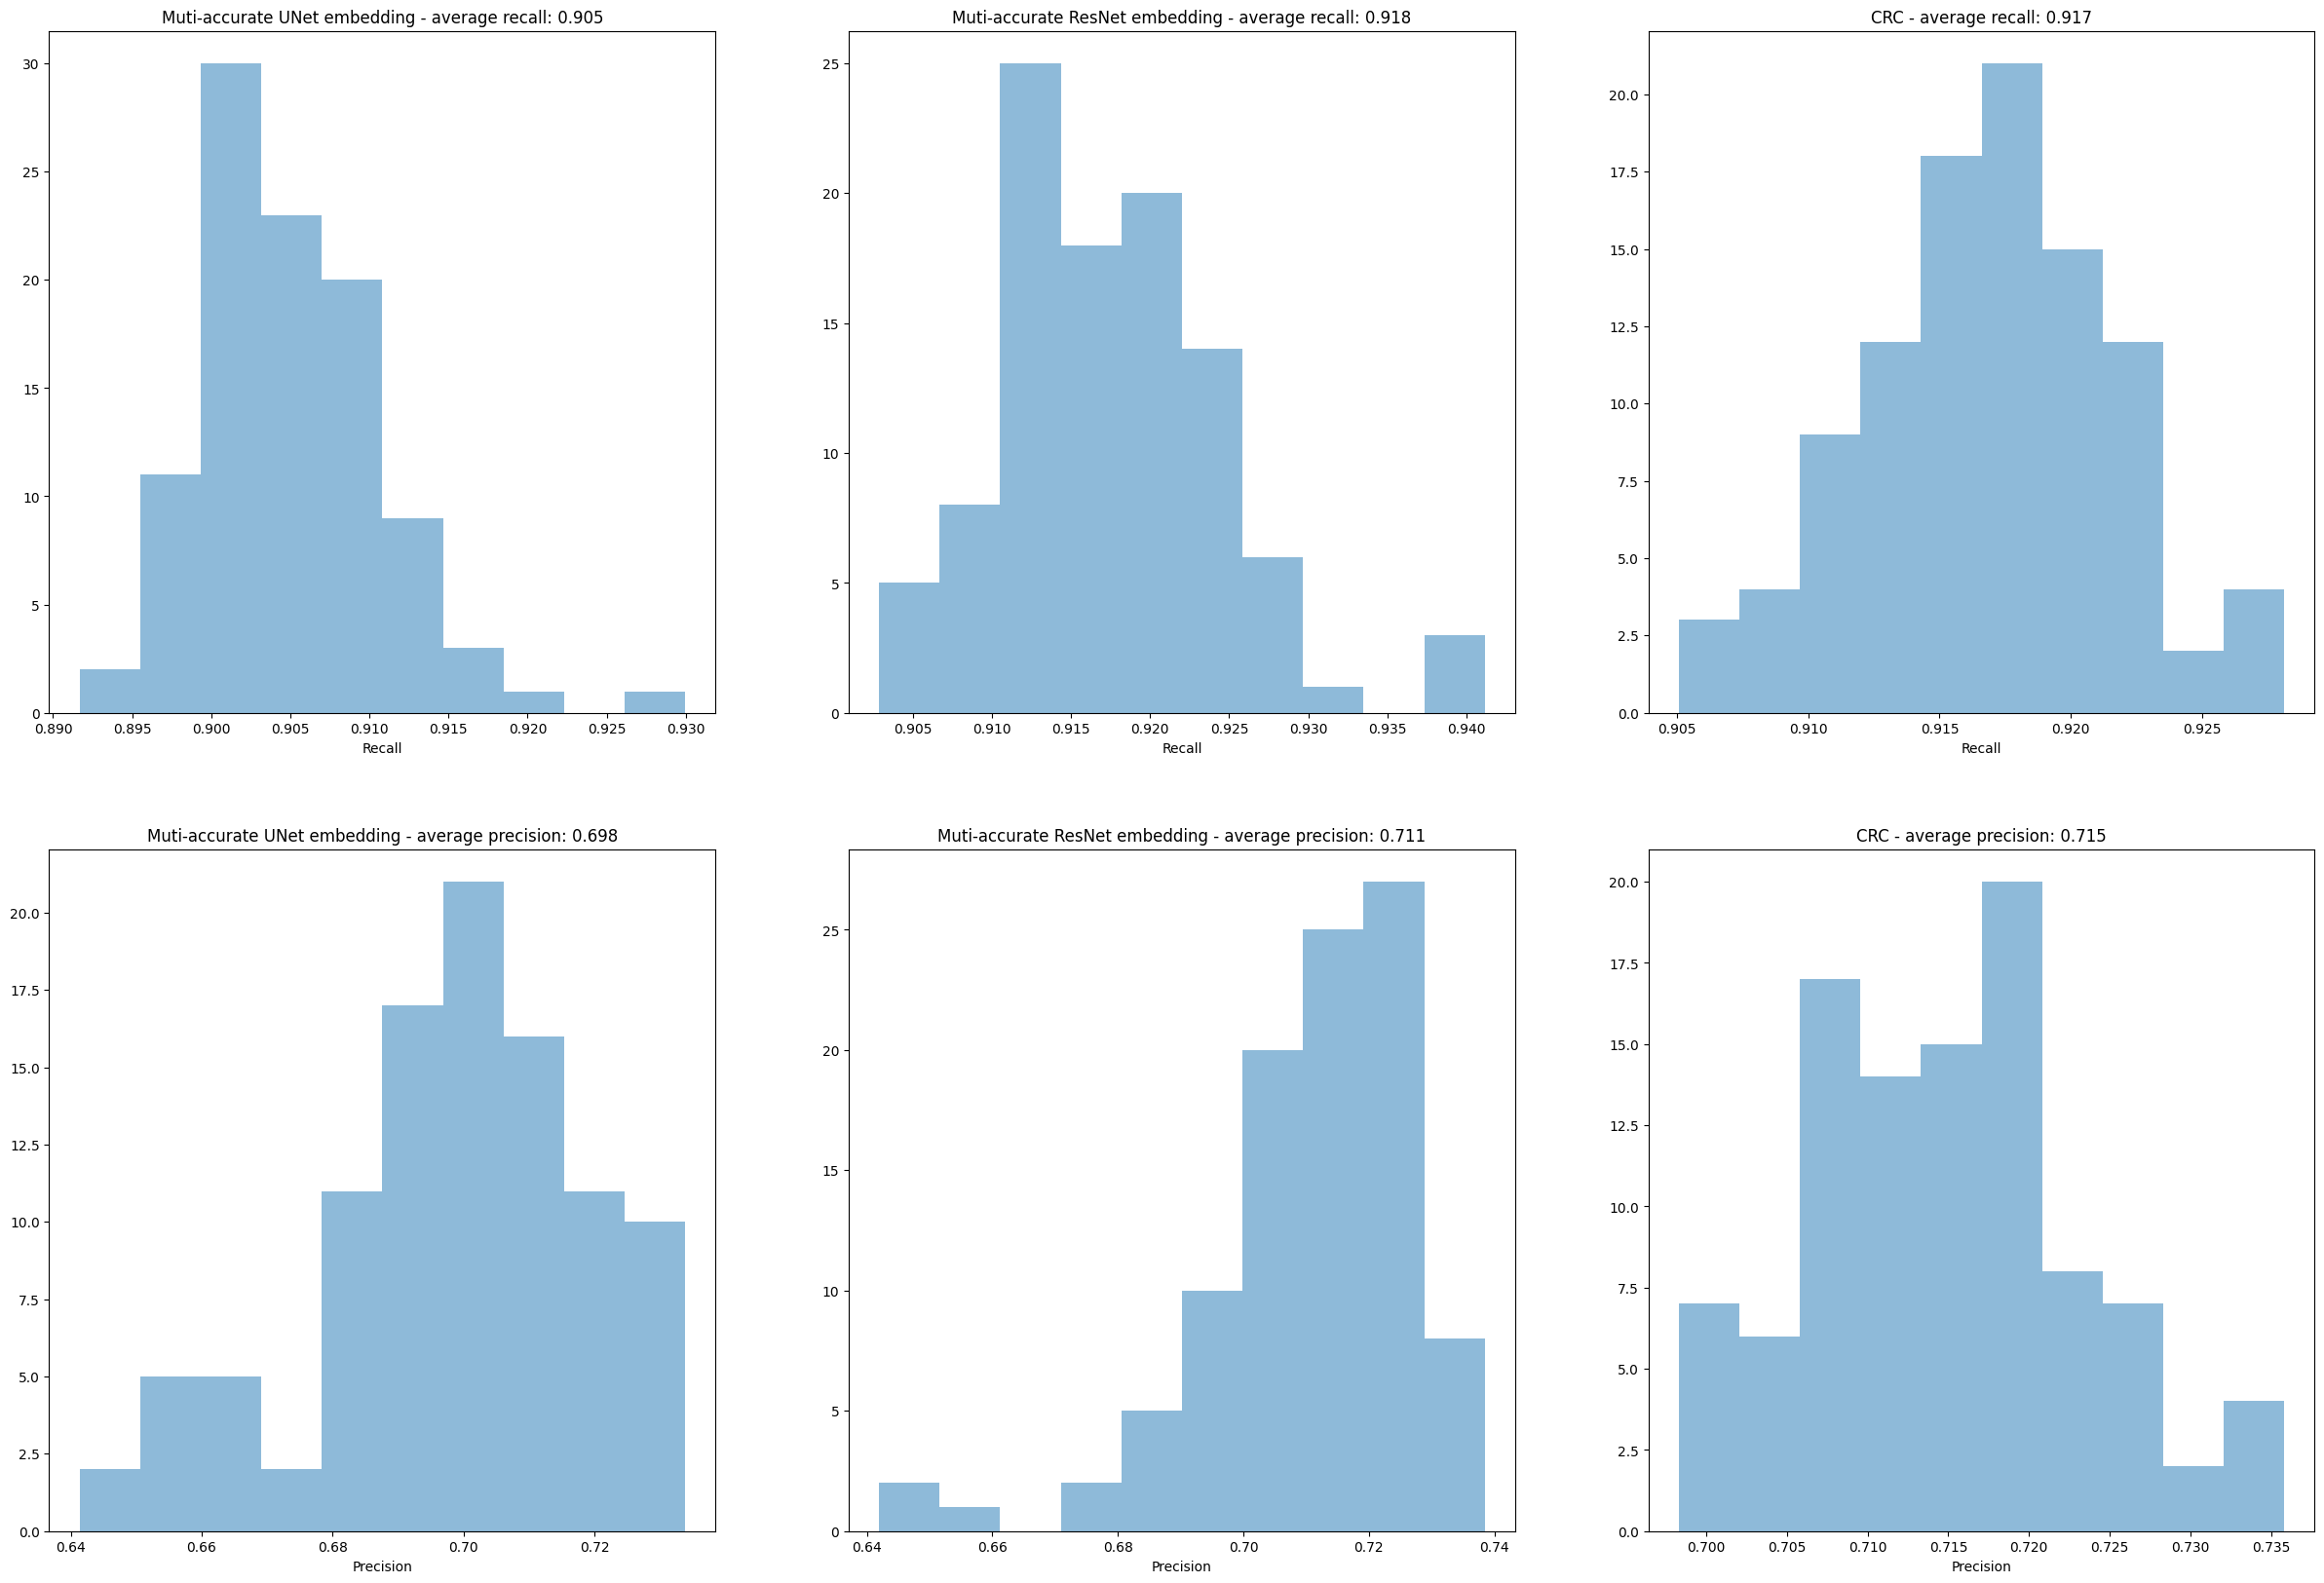

In [15]:
s = 10
nrow = 2
ncol = 3
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recalls_unet, bins=10, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate UNet embedding - average recall: {np.nanmean(recalls_unet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recalls_resnet, bins=10, alpha=.5)
ax[0, 1].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recalls_resnet):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[0, 2].hist(recalls_crc, bins=10, alpha=.5)
ax[0, 2].set_title(f"CRC - average recall: {np.nanmean(recalls_crc):.3f}")
ax[0, 2].set_xlabel("Recall")

ax[1, 0].hist(precisions_unet, bins=10, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate UNet embedding - average precision: {np.nanmean(precisions_unet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precisions_resnet, bins=10, alpha=.5)
ax[1, 1].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precisions_resnet):.3f}")
ax[1, 1].set_xlabel("Precision")

ax[1, 2].hist(precisions_crc, bins=10, alpha=.5)
ax[1, 2].set_title(f"CRC - average precision: {np.nanmean(precisions_crc):.3f}")
ax[1, 2].set_xlabel("Precision")